## This notebook aims to visualize the different asset distributions produced by CGAN

Running with less epochs

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


DEFINE LOOKBACK

In [ ]:
lookback = 1

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler


!pip install python-dotenv

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [ ]:
from drive.MyDrive.MasterThesis.FashionGANOLD2 import FashionGANOLD
from drive.MyDrive.MasterThesis.FashionGAN import FashionGAN
from drive.MyDrive.MasterThesis.BondGAN2 import BondGAN
from drive.MyDrive.MasterThesis.lambardGAN import LambardGAN
from drive.MyDrive.MasterThesis.simple_gan_portfolio import SimpleGANPortfolio
from drive.MyDrive.MasterThesis.gan_plotting import extensive_plotting
from drive.MyDrive.MasterThesis.shortrateGAN import shortRateGAN

### Parameters

In [ ]:
assets_0 = 1000000
liabilities_0 = 1000000 * 0.88
num_simulations = 10000
bof_0 = assets_0 - liabilities_0

gan_dict = {}

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [ ]:
def fetch_data_df():
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)

    reference_start_test_date = pd.to_datetime('2020-01-01')
    selected_columns_indices = [0,1,2,3,4,5,6]

    data_subset = df.iloc[:, selected_columns_indices]

    if not data_subset.index.is_monotonic_increasing:
        data_subset = data_subset.sort_index()

    ref_idx_position = data_subset.index.searchsorted(reference_start_test_date)

    actual_split_idx_position = max(0, ref_idx_position - 252)

    actual_split_date = data_subset.index[actual_split_idx_position]

    pre_test_df = data_subset[data_subset.index < actual_split_date]
    test_df = data_subset[data_subset.index >= actual_split_date]

    return pre_test_df, test_df


returns_df, test_returns_df = fetch_data_df()

In [ ]:
def create_windowed_returns_df(returns_df, window=252):
   windowed_data = {}

   for col in returns_df.columns:
       cumulative_returns = []
       for i in range(window, len(returns_df)):
           window_returns = returns_df[col].iloc[i-window:i]
           cumulative_return = (1 + window_returns).prod() - 1
           cumulative_returns.append(cumulative_return)
       windowed_data[col] = cumulative_returns

   return pd.DataFrame(windowed_data)
windowed_returns_df = create_windowed_returns_df(pd.concat([test_returns_df]), window=252)

windowed_returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
0,0.301306,0.456587,0.306436,0.109686,0.062752,0.140004,-0.004042
1,0.307087,0.491247,0.343185,0.108522,0.068356,0.141288,-0.004047
2,0.288173,0.447646,0.306412,0.118165,0.075596,0.134274,-0.004052
3,0.272796,0.419524,0.299679,0.116167,0.077008,0.128240,-0.004066
4,0.258579,0.406066,0.291122,0.115529,0.077033,0.124208,-0.004071


In [ ]:
asset_names = returns_df.columns
weights = np.array([0.07, 0.01, 0.18, 0.26, 0.34, 0.07, 0.07])


In [ ]:
returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000173


In [ ]:
def load_gan_model(asset_name, file, model_class=FashionGANOLD):
    model_path = f"/content/drive/MyDrive/gan_models_{file}/{asset_name}_gan.pt"
    checkpoint = torch.load(model_path, weights_only=False)

    asset_returns = returns_df[asset_name]


    if asset_name == 'HY':
        gan = model_class(asset_returns, asset_name, n_epochs=3000, lambda_gp =7, lag_periods=[14,90,180], cond_scale=0.01, lambda_skew = 0, lambda_kurtosis=0)

    elif asset_name == 'EONIA':
        #gan = model_class(asset_returns, asset_name, n_epochs=10000, lambda_gp = 7, cond_scale=0.1, lambda_skew=50)
        gan = model_class(asset_returns, asset_name, n_epochs=5000, lambda_gp =10, lambda_tail=0, lag_periods=[14,90,180],
            cond_scale=0.1, lambda_skew = 0)

    elif asset_name == 'IG':
        gan = model_class(asset_returns, asset_name, n_epochs=3000, lambda_gp =7, lag_periods=[14,90,180], cond_scale=0.01025, lambda_skew = 50)

    elif asset_name == 'GOV':
        gan = model_class(asset_returns, asset_name, n_epochs=3000,
                          lambda_gp = 2, lambda_tail=5, lag_periods=[14,90,180], cond_scale=0.25, lambda_skew=100)

    elif asset_name == 'REEL':
        gan = model_class(asset_returns, asset_name, n_epochs=4500,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.35, lambda_skew=130)

    elif asset_name == 'PE':
        gan = model_class(asset_returns, asset_name, n_epochs=3750,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.35)

    elif asset_name == 'MSCIWORLD':

      #gan = model_class(asset_returns, asset_name, n_epochs=3000,
       #                  lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.25)

      #gan = LambardGAN(asset_returns, asset_name, n_epochs=5000,
       #         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.3, lambda_skew = 0.5)

      gan = LambardGAN(asset_returns, asset_name, n_epochs=5000,
                  lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.29, lambda_skew = 0.5)




    gan.setup()



    # Load saved weights and scalers
    gan.generator.load_state_dict(checkpoint['generator'])
    gan.generator.eval()
    gan.discriminator.load_state_dict(checkpoint['discriminator'])
    gan.discriminator.eval()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    gan.generator.to(device)
    gan.discriminator.to(device)
    gan.cuda = torch.cuda.is_available()

    return gan




for asset_name in returns_df.columns:
    print(asset_name)

    if asset_name in ['IG', 'HY']:
        gan_dict[asset_name] = load_gan_model(asset_name, 1, BondGAN)

    elif asset_name == 'EONIA':
        #gan_dict[asset_name] = load_gan_model(asset_name, 1, shortRateGAN)
        gan_dict[asset_name] = load_gan_model(asset_name, 4, BondGAN)
    elif asset_name == 'MSCIWORLD':
        gan_dict[asset_name] = load_gan_model(asset_name, 3, LambardGAN)
    elif asset_name == 'REEL':
        gan_dict[asset_name] = load_gan_model(asset_name, 3, LambardGAN)
    else:
      gan_dict[asset_name] = load_gan_model(asset_name, 1, LambardGAN)


REEL
PE
MSCIWORLD
IG
GOV
HY
EONIA


In [ ]:
# Prelimenary  For reseting

for asset_name in gan_dict:
    gan_dict[asset_name].returns_series = returns_df[asset_name]

In [ ]:
all_dates = []

for asset_name in test_returns_df.columns:
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    print("Asset =", asset_name)
    i = 0
    for test_day in tqdm(test_returns_df.index[:-252], desc="Processing Dates", unit="dates"):
        i += 1
        new_return = test_returns_df.loc[test_day, asset_name]



        if test_day != test_returns_df.index[-1]:
            next_day = test_returns_df.index[test_returns_df.index.get_loc(test_day) + 1]
        else:
            print(f"Warning: {test_day} is the last day in the index, no next day available.")
            continue

        # test different lookbacks
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, lookback, next_day, save=True, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break
        all_dates.append(next_day)
        #scenarios_results.setdefault(asset_name, {})[next_day] = scenarios

    if foundNAN: break

Asset = REEL


Processing Dates: 100%|██████████| 1232/1232 [01:55<00:00, 10.70dates/s]


Asset = PE


Processing Dates: 100%|██████████| 1232/1232 [01:59<00:00, 10.30dates/s]


Asset = MSCIWORLD


Processing Dates: 100%|██████████| 1232/1232 [01:59<00:00, 10.34dates/s]


Asset = IG


Processing Dates: 100%|██████████| 1232/1232 [01:04<00:00, 19.10dates/s]


Asset = GOV


Processing Dates: 100%|██████████| 1232/1232 [01:59<00:00, 10.29dates/s]


Asset = HY


Processing Dates: 100%|██████████| 1232/1232 [01:04<00:00, 19.06dates/s]


Asset = EONIA


Processing Dates: 100%|██████████| 1232/1232 [01:04<00:00, 19.19dates/s]


## Making sure the window ends when we want to start testing

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2024-11-06 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2018-01-08,0.008221,0.002667,0.005650,0.000533,0.001131,0.000399,-0.00003
2018-01-09,-0.000640,0.006392,0.005812,-0.002456,-0.002873,-0.000071,-0.00001
2018-01-10,-0.016695,-0.000674,-0.004063,0.000027,-0.000964,-0.001790,-0.00001
2018-01-11,-0.014481,0.000106,-0.000953,0.000524,-0.002070,0.000699,-0.00001
2018-01-12,0.002552,0.002470,-0.002093,-0.000067,0.002069,0.000143,-0.00001


Everyone individually First

In [ ]:
def create_individual_asset_line(asset_name, deafult=True):
  df = historical_df[asset_name]

  n_windows = len(df) - 252 + 1

  window_start_dates = []
  window_end_dates = []
  realized_bof_values = []
  realized_asset_data = []

  for t in range(n_windows):
      # Get window data
      window_data = df.iloc[t:t+252]
      window_start_date = df.index[t]
      window_end_date = df.index[t+252-1]

      # Get returns and EONIA for this window
      window_returns = (window_data)

      # Calculate portfolio value at the end of the window
      # Starting from assets_0 each time
      portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return

      realized_asset_data.append(portfolio_value_end)

  if deafult:
    return realized_asset_data[252:]
  else:
    return realized_asset_data[:]

a1 = create_individual_asset_line('IG')
a2 = create_individual_asset_line('HY')
a3 = create_individual_asset_line('EONIA')
a4 = create_individual_asset_line('MSCIWORLD')
a5 = create_individual_asset_line('REEL')
a6 = create_individual_asset_line('PE')
a7 = create_individual_asset_line('GOV')

In [ ]:
import concurrent.futures
from functools import partial
from tqdm import tqdm


def process_date(date, asset_names, device="cuda"):
    gan_samples_cols = []
    for asset in asset_names:
        file_path = os.path.join(f"test_{date}", f"generated_returns_{asset}_scenarios.pt")
        asset_scenarios = torch.load(file_path, map_location=device).double()
        asset_cum = torch.prod(1 + asset_scenarios, dim=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    gan_samples = torch.cat(gan_samples_cols, dim=1)


    # Calculate VaR
    cumulative_returns = torch.prod(1 + gan_samples, dim=1) - 1  # Shape: (N,)

    final_asset_values = assets_0 * (1 + cumulative_returns)

    var = torch.quantile(final_asset_values, 0.005)




    if var > 1e6:
        var = 1e6


    return date, var

map = {
    'IG': a1,
    'HY': a2,
    'EONIA': a3,
    'MSCIWORLD': a4,
    'REEL': a5,
    'PE': a6,
    'GOV': a7
}


In [ ]:
for asset_name in returns_df.columns:
    print(asset_name)

    all_dates = set(all_dates)
    all_dates = sorted(all_dates)

    asset_var_result = {}
    for date in tqdm(all_dates, desc="Processing dates with GPU"):
        date, scr = process_date(date, asset_names=[asset_name])
        asset_var_result[date] = scr

    sorted_dates = sorted(asset_var_result.keys())
    scr_values = [asset_var_result[date].cpu() if hasattr(asset_var_result[date], 'cpu') else asset_var_result[date] for date in sorted_dates]


    plt.figure(figsize=(10, 6))
    plt.plot(scr_values, linestyle='-', label='SCR')
    plt.plot(map[asset_name], linestyle='-', label='Realized Delta BOF')


    plt.xlabel("Window")
    plt.ylabel("Assets")
    plt.title("VaR v.s. Actual")
    plt.grid(False)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Ensure arrays are same length
    min_length = min(len(scr_values), len(map[asset_name]))
    scr_trimmed = scr_values[:min_length]
    realized_trimmed = map[asset_name][:min_length]

    # Store the two lines in CSV
    df_output = pd.DataFrame({
      'SCR': scr_trimmed,
      'Realized_Delta_BOF': realized_trimmed
    })
    df_output.to_csv(f'{asset_name}_scr_vs_realized.csv', index=False)

REEL


Processing dates with GPU:   0%|          | 0/1232 [00:00<?, ?it/s]


NameError: name 'process_date' is not defined

In [ ]:
import os
print(os.listdir())
from google.colab import files
for asset_name in returns_df.columns[:]:
  files.download(f'{asset_name}_scr_vs_realized.csv')

In [ ]:
'''
# Create folder if it doesn't exist
import os
folder_path = '/content/drive/MyDrive/MasterThesis/MarginalResults'
os.makedirs(folder_path, exist_ok=True)

# Move all CSV files to Google Drive
csv_files = [f for f in os.listdir() if f.endswith('_scr_vs_realized.csv')]
for filename in csv_files:
   import shutil
   shutil.move(filename, f'{folder_path}/{filename}')

print(f"Moved {len(csv_files)} files to Google Drive/SCR_Results")
'''

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

In [ ]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]

    # Get returns and EONIA for this window
    window_returns = (window_data * weights).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]

    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return

    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()

    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0

    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values_1.append(delta_bof)

realized_delta_bof_values_1 = realized_delta_bof_values_1[252:]

## Does not work, since when we have a rolling BOF_0, and windows are overlapping, returns are counted over again multiple times, hence blowing up bof_0

To mitigate these i look at portfolio and liability values on a daily basis. I check the start and end values for all the different windows.

1233


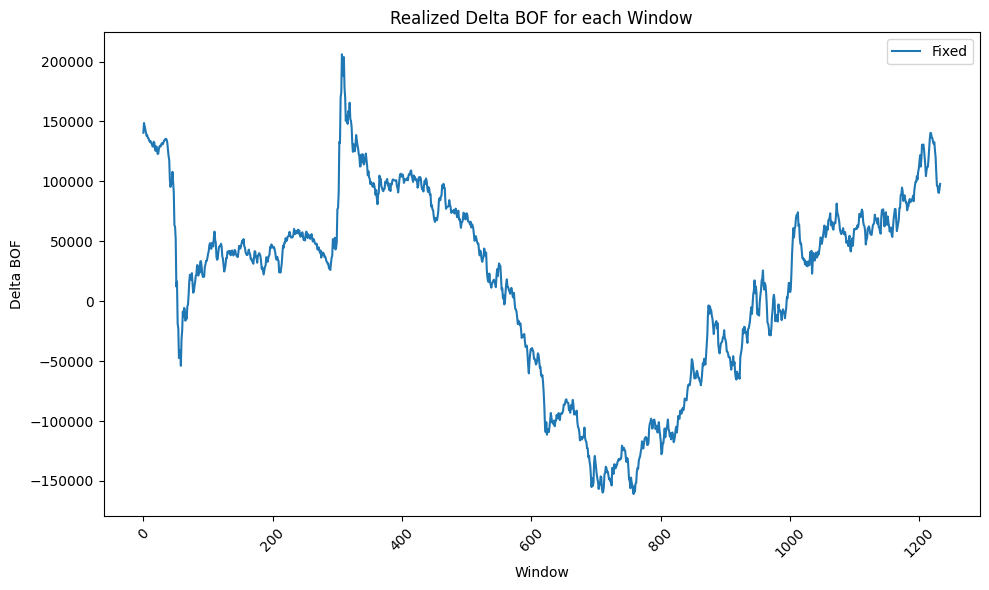

In [ ]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values = []

# For rolling approach, we need to track daily evolution of the portfolio
portfolio_values = [assets_0]  # Initialize with starting value
liability_values = [liabilities_0]  # Initialize with starting value

# First, calculate the full evolution of portfolio and liabilities day by day
for i in range(len(historical_df)):
    if i == 0:
        continue  # Skip first day as we already have initial values

    daily_return = (historical_df.iloc[i] * weights).sum()
    daily_eonia = historical_df.iloc[i, -1]

    new_portfolio_value = portfolio_values[-1] * (1 + daily_return)
    new_liability_value = liability_values[-1] * (1 + daily_eonia)

    portfolio_values.append(new_portfolio_value)
    liability_values.append(new_liability_value)

# Now calculate BOF for each window using the pre-calculated values
for t in range(n_windows):
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]

    # Get BOF at start and end of window
    bof_start = portfolio_values[t] - liability_values[t]
    bof_end = portfolio_values[t+252-1] - liability_values[t+252-1]

    # Calculate delta BOF for this window
    delta_bof = bof_end - bof_start

    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values.append(delta_bof)

print(len(realized_delta_bof_values_1))
plt.figure(figsize=(10, 6))
plt.plot(realized_delta_bof_values_1, linestyle='-', label="Fixed")
plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("Realized Delta BOF for each Window")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
!pip install copulae

from scipy.stats import t as t_dist, rankdata
from scipy.stats import expon
from copulae import ClaytonCopula

class PortfolioAggregation:
    def __init__(self, gan_samples, weights, confidence=0.995, device="cuda"):
        self.device = device
        if not isinstance(gan_samples, torch.Tensor):
            self.gan_samples = torch.tensor(gan_samples, dtype=torch.float64, device=self.device)
        else:
            self.gan_samples = gan_samples.to(self.device)

        if not isinstance(weights, torch.Tensor):
            self.weights = torch.tensor(weights, dtype=self.gan_samples.dtype, device=self.device)
        else:
            self.weights = weights.to(device=self.device, dtype=self.gan_samples.dtype)

        self.assets_0 = torch.tensor(1000000.0, dtype=self.gan_samples.dtype, device=self.device)
        self.liabilities_0 = self.assets_0 * 0.88
        self.n_simulations = self.gan_samples.shape[0]
        self.n_assets = self.gan_samples.shape[1]
        self.confidence = confidence
        self.bof0 = self.assets_0 - self.liabilities_0

    def apply_tstudent_copula(self, corr_matrix, dof=3):
        gan_samples_np = self.gan_samples.cpu().numpy()
        n_sims, n_assets = gan_samples_np.shape

        uniform_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            ranks = rankdata(gan_samples_np[:, i], method='average')
            uniform_samples[:, i] = ranks / (n_sims + 1)

        t_samples = t_dist.ppf(uniform_samples, df=dof)
        t_samples = np.clip(t_samples, -10, 10)

        L = np.linalg.cholesky(corr_matrix)
        independent_t = t_dist.rvs(df=dof, size=(n_sims, n_assets))
        correlated_t = independent_t @ L.T
        uniform_new = t_dist.cdf(correlated_t, df=dof)

        copula_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            sorted_original = np.sort(gan_samples_np[:, i])
            indices = np.clip((uniform_new[:, i] * (n_sims - 1)).astype(int), 0, n_sims - 1)
            copula_samples[:, i] = sorted_original[indices]

        return torch.tensor(copula_samples, dtype=self.gan_samples.dtype, device=self.device)

    """
    def apply_clayton_copula(self, theta=3.0):
        gan_samples_np = self.gan_samples.cpu().numpy()
        n_sims, n_assets = gan_samples_np.shape

        uniform_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            ranks = rankdata(gan_samples_np[:, i], method='average')
            uniform_samples[:, i] = ranks / (n_sims + 1)

        U = np.random.uniform(0, 1, (n_sims, n_assets))
        clayton_uniform = np.zeros_like(U)
        clayton_uniform[:, 0] = U[:, 0]

        for i in range(1, n_assets):
            clayton_uniform[:, i] = ((U[:, i] ** (-theta/(1+theta*(i))) - 1) *
                                    clayton_uniform[:, 0] ** (-theta) + 1) ** (-1/theta)

        copula_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            sorted_original = np.sort(gan_samples_np[:, i])
            indices = np.clip((clayton_uniform[:, i] * (n_sims - 1)).astype(int), 0, n_sims - 1)
            copula_samples[:, i] = sorted_original[indices]

        return torch.tensor(copula_samples, dtype=self.gan_samples.dtype, device=self.device)
      """

    def apply_clayton_copula(self, theta=1):
        gan_samples_np = self.gan_samples.cpu().numpy()
        n_sims, n_assets = gan_samples_np.shape

        uniform_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            ranks = rankdata(gan_samples_np[:, i], method='average')
            uniform_samples[:, i] = ranks / (n_sims + 1)

        copula = ClaytonCopula(dim=n_assets)
        copula.params = theta
        clayton_uniform = copula.random(n_sims)

        copula_samples = np.zeros_like(gan_samples_np)
        for i in range(n_assets):
            sorted_original = np.sort(gan_samples_np[:, i])
            indices = np.clip((clayton_uniform[:, i] * (n_sims - 1)).astype(int), 0, n_sims - 1)
            copula_samples[:, i] = sorted_original[indices]

        return torch.tensor(copula_samples, dtype=self.gan_samples.dtype, device=self.device)


    def calculate_scr(self, corr_matrix=None, copula='t'):
        if corr_matrix is not None:
            if copula == 't':
                samples = self.apply_tstudent_copula(corr_matrix)
            elif copula == 'c':
                samples = self.apply_clayton_copula()
        else:
            samples = self.gan_samples

        portfolio_returns = torch.matmul(samples, self.weights)
        eonia_returns = samples[:, -1]

        assets_t1 = self.assets_0 * (1 + portfolio_returns)
        liabilities_t1 = self.liabilities_0 * (1 + eonia_returns)
        bof_t1 = assets_t1 - liabilities_t1

        delta_bof = bof_t1 - self.bof0

        sorted_delta_bof, _ = torch.sort(delta_bof)
        idx = int(self.n_simulations * (1 - self.confidence))
        scr = sorted_delta_bof[idx].item()

        return delta_bof, scr

In [ ]:
returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000173


In [ ]:
import concurrent.futures
from functools import partial
from tqdm import tqdm

def compute_corr_matrix(df):
  window_length = 252

  cumulative_returns_per_window = {asset: [] for asset in df.columns}

  for i in range(len(df) - window_length + 1):
      window_data = df.iloc[i: i + window_length]

      cumulative_returns_this_window = (1 + window_data).prod(axis=0) - 1

      for asset in df.columns:
          cumulative_returns_per_window[asset].append(cumulative_returns_this_window[asset])

  cumulative_returns_df = pd.DataFrame(cumulative_returns_per_window)

  correlation_matrix_cumulative_returns = cumulative_returns_df.corr()

  corr_matrix = correlation_matrix_cumulative_returns

  return corr_matrix

In [ ]:
delta_bof_results = {}

def process_date(date, corr_matrix, asset_names, device="cuda"):
    gan_samples_cols = []
    for asset in asset_names:
        file_path = os.path.join(f"test_{date}", f"generated_returns_{asset}_scenarios.pt")
        asset_scenarios = torch.load(file_path, map_location=device).double()

        asset_cum = torch.prod(1 + asset_scenarios, dim=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    gan_samples = torch.cat(gan_samples_cols, dim=1)

    if not isinstance(weights, torch.Tensor):
        weights_tensor = torch.tensor(weights, dtype=torch.float64, device=device)
    else:
        weights_tensor = weights.to(device)

    portfolio = PortfolioAggregation(gan_samples, weights_tensor, device=device)


    delta_bof, scr = portfolio.calculate_scr(corr_matrix=corr_matrix, copula="c")

    delta_bof_results[date] = delta_bof.cpu()

    if scr > 0:
        scr = 0.0
    print(scr)
    return date, scr


asset_names = list(returns_df.columns)
all_dates = set(all_dates)
all_dates = sorted(all_dates)

portfolio_scr_results = {}

df1, df2 = returns_df.copy(), test_returns_df.copy()

corr_matrix = compute_corr_matrix(df1)

for date in tqdm(all_dates, desc="Processing dates with GPU"):
    df1 = pd.concat([df1, df2.loc[[date]]])

    date, scr = process_date(date, corr_matrix, asset_names=asset_names)
    portfolio_scr_results[date] = scr

Processing dates with GPU:   0%|          | 1/1232 [00:01<22:56,  1.12s/it]

-146709.01524601015


Processing dates with GPU:   0%|          | 2/1232 [00:01<16:48,  1.22it/s]

-153221.86996681243


Processing dates with GPU:   0%|          | 3/1232 [00:02<13:40,  1.50it/s]

-145501.181784275


Processing dates with GPU:   0%|          | 4/1232 [00:02<11:41,  1.75it/s]

-144643.21896556357


Processing dates with GPU:   0%|          | 5/1232 [00:03<10:35,  1.93it/s]

-144650.14166866546


Processing dates with GPU:   0%|          | 6/1232 [00:03<09:49,  2.08it/s]

-137034.57429491007


Processing dates with GPU:   1%|          | 7/1232 [00:03<09:03,  2.26it/s]

-142033.38364274194


Processing dates with GPU:   1%|          | 8/1232 [00:04<08:43,  2.34it/s]

-144324.91853292217


Processing dates with GPU:   1%|          | 9/1232 [00:04<08:28,  2.41it/s]

-152814.98609905178


Processing dates with GPU:   1%|          | 10/1232 [00:05<08:15,  2.47it/s]

-148603.700495751


Processing dates with GPU:   1%|          | 11/1232 [00:05<08:10,  2.49it/s]

-142091.72211175377


Processing dates with GPU:   1%|          | 12/1232 [00:05<07:59,  2.54it/s]

-145660.8374389537


Processing dates with GPU:   1%|          | 13/1232 [00:06<07:52,  2.58it/s]

-150136.87005289947


Processing dates with GPU:   1%|          | 14/1232 [00:06<07:45,  2.62it/s]

-146808.0057832353


Processing dates with GPU:   1%|          | 15/1232 [00:06<07:40,  2.64it/s]

-145678.40018597676


Processing dates with GPU:   1%|▏         | 16/1232 [00:07<07:37,  2.66it/s]

-156877.96536740917


Processing dates with GPU:   1%|▏         | 17/1232 [00:07<07:37,  2.65it/s]

-153549.55412312865


Processing dates with GPU:   1%|▏         | 18/1232 [00:08<07:38,  2.65it/s]

-162876.74769092572


Processing dates with GPU:   2%|▏         | 19/1232 [00:08<07:35,  2.66it/s]

-141557.1157754215


Processing dates with GPU:   2%|▏         | 20/1232 [00:08<07:37,  2.65it/s]

-141769.003583238


Processing dates with GPU:   2%|▏         | 21/1232 [00:09<07:31,  2.68it/s]

-150218.61935035326


Processing dates with GPU:   2%|▏         | 22/1232 [00:09<07:26,  2.71it/s]

-160941.59614995786


Processing dates with GPU:   2%|▏         | 23/1232 [00:09<07:23,  2.72it/s]

-145566.65776859398


Processing dates with GPU:   2%|▏         | 24/1232 [00:10<07:22,  2.73it/s]

-151582.77244593808


Processing dates with GPU:   2%|▏         | 25/1232 [00:10<07:21,  2.73it/s]

-156692.55899333803


Processing dates with GPU:   2%|▏         | 26/1232 [00:10<07:19,  2.75it/s]

-152178.96573278762


Processing dates with GPU:   2%|▏         | 27/1232 [00:11<07:14,  2.77it/s]

-144160.964468934


Processing dates with GPU:   2%|▏         | 28/1232 [00:11<07:11,  2.79it/s]

-156358.39486666815


Processing dates with GPU:   2%|▏         | 29/1232 [00:11<07:08,  2.81it/s]

-142089.98557797528


Processing dates with GPU:   2%|▏         | 30/1232 [00:12<07:11,  2.79it/s]

-150249.6386856793


Processing dates with GPU:   3%|▎         | 31/1232 [00:12<07:08,  2.80it/s]

-145778.86391312908


Processing dates with GPU:   3%|▎         | 32/1232 [00:13<07:08,  2.80it/s]

-147108.30499554612


Processing dates with GPU:   3%|▎         | 33/1232 [00:13<07:05,  2.82it/s]

-146800.97524710023


Processing dates with GPU:   3%|▎         | 34/1232 [00:13<07:03,  2.83it/s]

-146790.18158258882


Processing dates with GPU:   3%|▎         | 35/1232 [00:14<07:03,  2.83it/s]

-168761.05283646646


Processing dates with GPU:   3%|▎         | 36/1232 [00:14<07:03,  2.82it/s]

-153935.4755646697


Processing dates with GPU:   3%|▎         | 37/1232 [00:14<06:55,  2.87it/s]

-150870.93255009933


Processing dates with GPU:   3%|▎         | 38/1232 [00:15<06:54,  2.88it/s]

-148276.55282479024


Processing dates with GPU:   3%|▎         | 39/1232 [00:15<06:59,  2.84it/s]

-140365.62878675305


Processing dates with GPU:   3%|▎         | 40/1232 [00:15<06:55,  2.87it/s]

-154366.2016010197


Processing dates with GPU:   3%|▎         | 41/1232 [00:16<06:53,  2.88it/s]

-157136.57449529006


Processing dates with GPU:   3%|▎         | 42/1232 [00:16<06:51,  2.89it/s]

-148043.90936197178


Processing dates with GPU:   3%|▎         | 43/1232 [00:16<06:58,  2.84it/s]

-168027.4468804316


Processing dates with GPU:   4%|▎         | 44/1232 [00:17<06:55,  2.86it/s]

-155479.53439180274


Processing dates with GPU:   4%|▎         | 45/1232 [00:17<06:56,  2.85it/s]

-145042.08221830986


Processing dates with GPU:   4%|▎         | 46/1232 [00:17<06:53,  2.87it/s]

-154855.26300254022


Processing dates with GPU:   4%|▍         | 47/1232 [00:18<06:49,  2.89it/s]

-151837.6342160732


Processing dates with GPU:   4%|▍         | 48/1232 [00:18<06:46,  2.91it/s]

-143679.25761873275


Processing dates with GPU:   4%|▍         | 49/1232 [00:18<06:45,  2.92it/s]

-145151.42015562777


Processing dates with GPU:   4%|▍         | 50/1232 [00:19<06:43,  2.93it/s]

-144928.1924890565


Processing dates with GPU:   4%|▍         | 51/1232 [00:19<06:45,  2.92it/s]

-145792.56301384314


Processing dates with GPU:   4%|▍         | 52/1232 [00:20<06:51,  2.87it/s]

-154525.7126062509


Processing dates with GPU:   4%|▍         | 53/1232 [00:20<06:55,  2.84it/s]

-158577.8402170639


Processing dates with GPU:   4%|▍         | 54/1232 [00:20<07:03,  2.78it/s]

-153043.74743955967


Processing dates with GPU:   4%|▍         | 55/1232 [00:21<07:03,  2.78it/s]

-147174.38108732936


Processing dates with GPU:   5%|▍         | 56/1232 [00:21<06:59,  2.80it/s]

-156815.5287575894


Processing dates with GPU:   5%|▍         | 57/1232 [00:21<06:55,  2.83it/s]

-150344.157417833


Processing dates with GPU:   5%|▍         | 58/1232 [00:22<06:53,  2.84it/s]

-147795.76014832046


Processing dates with GPU:   5%|▍         | 59/1232 [00:22<06:51,  2.85it/s]

-150970.83975203126


Processing dates with GPU:   5%|▍         | 60/1232 [00:22<06:52,  2.84it/s]

-150033.73394658323


Processing dates with GPU:   5%|▍         | 61/1232 [00:23<06:50,  2.85it/s]

-149896.1858652901


Processing dates with GPU:   5%|▌         | 62/1232 [00:23<06:52,  2.83it/s]

-147065.0169628507


Processing dates with GPU:   5%|▌         | 63/1232 [00:23<06:53,  2.83it/s]

-148829.66130876774


Processing dates with GPU:   5%|▌         | 64/1232 [00:24<06:47,  2.86it/s]

-144131.72548877925


Processing dates with GPU:   5%|▌         | 65/1232 [00:24<06:53,  2.82it/s]

-144576.88364999217


Processing dates with GPU:   5%|▌         | 66/1232 [00:24<06:54,  2.82it/s]

-140511.42006296746


Processing dates with GPU:   5%|▌         | 67/1232 [00:25<06:51,  2.83it/s]

-143161.612584654


Processing dates with GPU:   6%|▌         | 68/1232 [00:25<06:48,  2.85it/s]

-148715.68283530592


Processing dates with GPU:   6%|▌         | 69/1232 [00:26<06:47,  2.85it/s]

-161406.03222956404


Processing dates with GPU:   6%|▌         | 70/1232 [00:26<06:46,  2.86it/s]

-155068.64905858703


Processing dates with GPU:   6%|▌         | 71/1232 [00:26<06:48,  2.84it/s]

-153936.63102316135


Processing dates with GPU:   6%|▌         | 72/1232 [00:27<06:43,  2.87it/s]

-147724.00568375387


Processing dates with GPU:   6%|▌         | 73/1232 [00:27<06:41,  2.88it/s]

-159060.5110261552


Processing dates with GPU:   6%|▌         | 74/1232 [00:27<06:40,  2.89it/s]

-148283.64139111072


Processing dates with GPU:   6%|▌         | 75/1232 [00:28<06:39,  2.90it/s]

-145490.35077666095


Processing dates with GPU:   6%|▌         | 76/1232 [00:28<06:42,  2.88it/s]

-143970.29800345504


Processing dates with GPU:   6%|▋         | 77/1232 [00:28<06:38,  2.89it/s]

-138537.38192217587


Processing dates with GPU:   6%|▋         | 78/1232 [00:29<06:41,  2.88it/s]

-152382.82102934108


Processing dates with GPU:   6%|▋         | 79/1232 [00:29<06:38,  2.89it/s]

-150978.53870020132


Processing dates with GPU:   6%|▋         | 80/1232 [00:29<06:37,  2.90it/s]

-166658.58867642633


Processing dates with GPU:   7%|▋         | 81/1232 [00:30<06:42,  2.86it/s]

-160949.02868614555


Processing dates with GPU:   7%|▋         | 82/1232 [00:30<06:49,  2.81it/s]

-151128.2320600266


Processing dates with GPU:   7%|▋         | 83/1232 [00:30<06:47,  2.82it/s]

-154349.27130099328


Processing dates with GPU:   7%|▋         | 84/1232 [00:31<06:46,  2.82it/s]

-154723.1159837708


Processing dates with GPU:   7%|▋         | 85/1232 [00:31<06:43,  2.84it/s]

-145716.5381721952


Processing dates with GPU:   7%|▋         | 86/1232 [00:31<06:43,  2.84it/s]

-144219.54549941933


Processing dates with GPU:   7%|▋         | 87/1232 [00:32<06:45,  2.83it/s]

-149496.63586508355


Processing dates with GPU:   7%|▋         | 88/1232 [00:32<07:10,  2.66it/s]

-160481.86895875167


Processing dates with GPU:   7%|▋         | 89/1232 [00:33<07:25,  2.57it/s]

-153635.5032185089


Processing dates with GPU:   7%|▋         | 90/1232 [00:33<07:34,  2.51it/s]

-153000.5378691696


Processing dates with GPU:   7%|▋         | 91/1232 [00:33<07:29,  2.54it/s]

-153522.40155990154


Processing dates with GPU:   7%|▋         | 92/1232 [00:34<07:29,  2.53it/s]

-149049.08290375315


Processing dates with GPU:   8%|▊         | 93/1232 [00:34<07:26,  2.55it/s]

-146603.8566809399


Processing dates with GPU:   8%|▊         | 94/1232 [00:35<07:18,  2.60it/s]

-153938.64948052505


Processing dates with GPU:   8%|▊         | 95/1232 [00:35<07:12,  2.63it/s]

-150902.31207459758


Processing dates with GPU:   8%|▊         | 96/1232 [00:35<07:09,  2.65it/s]

-153731.74763335846


Processing dates with GPU:   8%|▊         | 97/1232 [00:36<07:07,  2.65it/s]

-157333.51641102252


Processing dates with GPU:   8%|▊         | 98/1232 [00:36<07:03,  2.68it/s]

-157437.30125570833


Processing dates with GPU:   8%|▊         | 99/1232 [00:36<07:05,  2.66it/s]

-151626.1564238622


Processing dates with GPU:   8%|▊         | 100/1232 [00:37<07:03,  2.68it/s]

-159100.966557191


Processing dates with GPU:   8%|▊         | 101/1232 [00:37<07:04,  2.67it/s]

-160867.76199003088


Processing dates with GPU:   8%|▊         | 102/1232 [00:38<07:02,  2.68it/s]

-147580.70241088967


Processing dates with GPU:   8%|▊         | 103/1232 [00:38<07:05,  2.65it/s]

-154077.94469797716


Processing dates with GPU:   8%|▊         | 104/1232 [00:38<07:06,  2.64it/s]

-151334.3026193363


Processing dates with GPU:   9%|▊         | 105/1232 [00:39<07:05,  2.65it/s]

-152438.1842546208


Processing dates with GPU:   9%|▊         | 106/1232 [00:39<07:02,  2.67it/s]

-143048.1280973961


Processing dates with GPU:   9%|▊         | 107/1232 [00:40<07:04,  2.65it/s]

-142588.65121716878


Processing dates with GPU:   9%|▉         | 108/1232 [00:40<07:02,  2.66it/s]

-159892.1086884957


Processing dates with GPU:   9%|▉         | 109/1232 [00:40<06:58,  2.69it/s]

-153944.39926294284


Processing dates with GPU:   9%|▉         | 110/1232 [00:41<06:57,  2.69it/s]

-154998.94978837785


Processing dates with GPU:   9%|▉         | 111/1232 [00:41<06:51,  2.72it/s]

-154605.75684175303


Processing dates with GPU:   9%|▉         | 112/1232 [00:41<06:50,  2.73it/s]

-156644.95598387532


Processing dates with GPU:   9%|▉         | 113/1232 [00:42<06:50,  2.73it/s]

-149296.838623764


Processing dates with GPU:   9%|▉         | 114/1232 [00:42<06:48,  2.74it/s]

-158430.78688136896


Processing dates with GPU:   9%|▉         | 115/1232 [00:42<06:50,  2.72it/s]

-162754.23276578786


Processing dates with GPU:   9%|▉         | 116/1232 [00:43<06:50,  2.72it/s]

-171876.38282027806


Processing dates with GPU:   9%|▉         | 117/1232 [00:43<06:36,  2.81it/s]

-161051.69948656939


Processing dates with GPU:  10%|▉         | 118/1232 [00:44<06:44,  2.76it/s]

-158107.40439033392


Processing dates with GPU:  10%|▉         | 119/1232 [00:44<06:57,  2.67it/s]

-168550.39573503018


Processing dates with GPU:  10%|▉         | 120/1232 [00:44<07:02,  2.63it/s]

-154088.8546282841


Processing dates with GPU:  10%|▉         | 121/1232 [00:45<07:06,  2.61it/s]

-155196.31717919186


Processing dates with GPU:  10%|▉         | 122/1232 [00:45<07:10,  2.58it/s]

-158940.58098599745


Processing dates with GPU:  10%|▉         | 123/1232 [00:46<07:19,  2.52it/s]

-156960.5070970417


Processing dates with GPU:  10%|█         | 124/1232 [00:46<07:17,  2.53it/s]

-150592.0600893281


Processing dates with GPU:  10%|█         | 125/1232 [00:46<07:16,  2.53it/s]

-148667.4447345048


Processing dates with GPU:  10%|█         | 126/1232 [00:47<07:17,  2.53it/s]

-161391.50398202846


Processing dates with GPU:  10%|█         | 127/1232 [00:47<07:15,  2.54it/s]

-153585.73689474387


Processing dates with GPU:  10%|█         | 128/1232 [00:47<07:17,  2.53it/s]

-150991.36619976314


Processing dates with GPU:  10%|█         | 129/1232 [00:48<07:15,  2.53it/s]

-146687.93833314464


Processing dates with GPU:  11%|█         | 130/1232 [00:48<07:16,  2.52it/s]

-159101.3106210844


Processing dates with GPU:  11%|█         | 131/1232 [00:49<07:17,  2.52it/s]

-142353.64121431846


Processing dates with GPU:  11%|█         | 132/1232 [00:49<07:13,  2.54it/s]

-152956.34275073092


Processing dates with GPU:  11%|█         | 133/1232 [00:49<07:15,  2.52it/s]

-154334.8726871052


Processing dates with GPU:  11%|█         | 134/1232 [00:50<07:14,  2.53it/s]

-158868.41325707268


Processing dates with GPU:  11%|█         | 135/1232 [00:50<07:13,  2.53it/s]

-151719.42382768774


Processing dates with GPU:  11%|█         | 136/1232 [00:51<07:18,  2.50it/s]

-153812.7764130414


Processing dates with GPU:  11%|█         | 137/1232 [00:51<07:20,  2.49it/s]

-154912.14326701895


Processing dates with GPU:  11%|█         | 138/1232 [00:51<07:22,  2.47it/s]

-153645.96532960574


Processing dates with GPU:  11%|█▏        | 139/1232 [00:52<07:23,  2.46it/s]

-141783.55115954345


Processing dates with GPU:  11%|█▏        | 140/1232 [00:52<07:26,  2.45it/s]

-158112.73270296073


Processing dates with GPU:  11%|█▏        | 141/1232 [00:53<07:22,  2.47it/s]

-140162.17540405004


Processing dates with GPU:  12%|█▏        | 142/1232 [00:53<07:19,  2.48it/s]

-154550.1327181612


Processing dates with GPU:  12%|█▏        | 143/1232 [00:54<07:18,  2.48it/s]

-148875.35657916602


Processing dates with GPU:  12%|█▏        | 144/1232 [00:54<07:12,  2.52it/s]

-152951.1515755715


Processing dates with GPU:  12%|█▏        | 145/1232 [00:54<07:13,  2.51it/s]

-148276.66909204784


Processing dates with GPU:  12%|█▏        | 146/1232 [00:55<07:11,  2.52it/s]

-152250.2418290563


Processing dates with GPU:  12%|█▏        | 147/1232 [00:55<07:15,  2.49it/s]

-153633.8013560446


Processing dates with GPU:  12%|█▏        | 148/1232 [00:56<07:15,  2.49it/s]

-157007.37442502496


Processing dates with GPU:  12%|█▏        | 149/1232 [00:56<07:20,  2.46it/s]

-149791.80550451344


Processing dates with GPU:  12%|█▏        | 150/1232 [00:56<07:17,  2.47it/s]

-148671.50240915548


Processing dates with GPU:  12%|█▏        | 151/1232 [00:57<07:14,  2.49it/s]

-159077.5085046267


Processing dates with GPU:  12%|█▏        | 152/1232 [00:57<07:15,  2.48it/s]

-152715.09307374223


Processing dates with GPU:  12%|█▏        | 153/1232 [00:58<07:15,  2.48it/s]

-150992.2925121393


Processing dates with GPU:  12%|█▎        | 154/1232 [00:58<07:10,  2.50it/s]

-161686.80630631722


Processing dates with GPU:  13%|█▎        | 155/1232 [00:58<07:10,  2.50it/s]

-164228.4649616792


Processing dates with GPU:  13%|█▎        | 156/1232 [00:59<07:15,  2.47it/s]

-155258.22038909583


Processing dates with GPU:  13%|█▎        | 157/1232 [00:59<07:10,  2.50it/s]

-167169.20578187518


Processing dates with GPU:  13%|█▎        | 158/1232 [01:00<07:13,  2.48it/s]

-167948.19455050677


Processing dates with GPU:  13%|█▎        | 159/1232 [01:00<07:15,  2.47it/s]

-147472.74052662635


Processing dates with GPU:  13%|█▎        | 160/1232 [01:00<07:12,  2.48it/s]

-150642.80532681977


Processing dates with GPU:  13%|█▎        | 161/1232 [01:01<07:09,  2.49it/s]

-149941.10965766595


Processing dates with GPU:  13%|█▎        | 162/1232 [01:01<07:06,  2.51it/s]

-150134.3111206761


Processing dates with GPU:  13%|█▎        | 163/1232 [01:02<07:08,  2.50it/s]

-152306.47084552154


Processing dates with GPU:  13%|█▎        | 164/1232 [01:02<07:03,  2.52it/s]

-150647.2841720034


Processing dates with GPU:  13%|█▎        | 165/1232 [01:02<07:01,  2.53it/s]

-142881.91490453866


Processing dates with GPU:  13%|█▎        | 166/1232 [01:03<07:05,  2.50it/s]

-139564.66289422684


Processing dates with GPU:  14%|█▎        | 167/1232 [01:03<07:10,  2.48it/s]

-150522.46994702483


Processing dates with GPU:  14%|█▎        | 168/1232 [01:04<07:06,  2.50it/s]

-158351.29704768106


Processing dates with GPU:  14%|█▎        | 169/1232 [01:04<07:07,  2.48it/s]

-160553.78176790988


Processing dates with GPU:  14%|█▍        | 170/1232 [01:04<07:11,  2.46it/s]

-167263.9508401528


Processing dates with GPU:  14%|█▍        | 171/1232 [01:05<07:13,  2.45it/s]

-142585.88997207652


Processing dates with GPU:  14%|█▍        | 172/1232 [01:05<07:09,  2.47it/s]

-156407.87410970381


Processing dates with GPU:  14%|█▍        | 173/1232 [01:06<07:07,  2.47it/s]

-143162.7378425094


Processing dates with GPU:  14%|█▍        | 174/1232 [01:06<07:03,  2.50it/s]

-147976.18264978728


Processing dates with GPU:  14%|█▍        | 175/1232 [01:06<07:01,  2.51it/s]

-143952.224554245


Processing dates with GPU:  14%|█▍        | 176/1232 [01:07<07:03,  2.49it/s]

-160053.18119299365


Processing dates with GPU:  14%|█▍        | 177/1232 [01:07<07:05,  2.48it/s]

-142420.75416030549


Processing dates with GPU:  14%|█▍        | 178/1232 [01:08<07:03,  2.49it/s]

-146271.4976513835


Processing dates with GPU:  15%|█▍        | 179/1232 [01:08<07:04,  2.48it/s]

-144277.43376656482


Processing dates with GPU:  15%|█▍        | 180/1232 [01:08<07:04,  2.48it/s]

-148681.5402515633


Processing dates with GPU:  15%|█▍        | 181/1232 [01:09<07:01,  2.49it/s]

-156811.00823137385


Processing dates with GPU:  15%|█▍        | 182/1232 [01:09<07:02,  2.49it/s]

-144675.45704205218


Processing dates with GPU:  15%|█▍        | 183/1232 [01:10<07:02,  2.48it/s]

-144312.7037916457


Processing dates with GPU:  15%|█▍        | 184/1232 [01:10<06:58,  2.50it/s]

-152386.13923161966


Processing dates with GPU:  15%|█▌        | 185/1232 [01:10<06:57,  2.51it/s]

-156895.40013332665


Processing dates with GPU:  15%|█▌        | 186/1232 [01:11<06:59,  2.50it/s]

-159308.26098820567


Processing dates with GPU:  15%|█▌        | 187/1232 [01:11<06:55,  2.52it/s]

-152428.16243369214


Processing dates with GPU:  15%|█▌        | 188/1232 [01:12<06:56,  2.51it/s]

-143400.48585357226


Processing dates with GPU:  15%|█▌        | 189/1232 [01:12<06:57,  2.50it/s]

-151044.2167839927


Processing dates with GPU:  15%|█▌        | 190/1232 [01:12<06:56,  2.50it/s]

-147595.6364183809


Processing dates with GPU:  16%|█▌        | 191/1232 [01:13<06:56,  2.50it/s]

-150378.33194170287


Processing dates with GPU:  16%|█▌        | 192/1232 [01:13<06:55,  2.51it/s]

-147138.7994782203


Processing dates with GPU:  16%|█▌        | 193/1232 [01:14<06:55,  2.50it/s]

-159854.4153844315


Processing dates with GPU:  16%|█▌        | 194/1232 [01:14<06:54,  2.50it/s]

-155990.9590806875


Processing dates with GPU:  16%|█▌        | 195/1232 [01:14<06:52,  2.52it/s]

-153423.23721744632


Processing dates with GPU:  16%|█▌        | 196/1232 [01:15<06:54,  2.50it/s]

-157192.90526537108


Processing dates with GPU:  16%|█▌        | 197/1232 [01:15<06:55,  2.49it/s]

-148980.2072132196


Processing dates with GPU:  16%|█▌        | 198/1232 [01:16<06:57,  2.48it/s]

-151112.95242634718


Processing dates with GPU:  16%|█▌        | 199/1232 [01:16<06:56,  2.48it/s]

-151188.4565080182


Processing dates with GPU:  16%|█▌        | 200/1232 [01:16<07:00,  2.45it/s]

-147731.8481793875


Processing dates with GPU:  16%|█▋        | 201/1232 [01:17<07:03,  2.43it/s]

-158655.16750095063


Processing dates with GPU:  16%|█▋        | 202/1232 [01:17<07:04,  2.43it/s]

-160805.86651290057


Processing dates with GPU:  16%|█▋        | 203/1232 [01:18<07:00,  2.45it/s]

-159313.1166095161


Processing dates with GPU:  17%|█▋        | 204/1232 [01:18<06:58,  2.46it/s]

-141122.9294514882


Processing dates with GPU:  17%|█▋        | 205/1232 [01:18<06:55,  2.47it/s]

-164259.54560955917


Processing dates with GPU:  17%|█▋        | 206/1232 [01:19<06:55,  2.47it/s]

-146071.4648509808


Processing dates with GPU:  17%|█▋        | 207/1232 [01:19<06:52,  2.49it/s]

-152789.7460644329


Processing dates with GPU:  17%|█▋        | 208/1232 [01:20<06:53,  2.48it/s]

-141113.93105721427


Processing dates with GPU:  17%|█▋        | 209/1232 [01:20<06:56,  2.46it/s]

-136123.1214526007


Processing dates with GPU:  17%|█▋        | 210/1232 [01:20<06:53,  2.47it/s]

-145748.80470986117


Processing dates with GPU:  17%|█▋        | 211/1232 [01:21<06:48,  2.50it/s]

-146305.12497294217


Processing dates with GPU:  17%|█▋        | 212/1232 [01:21<06:49,  2.49it/s]

-155693.5185307403


Processing dates with GPU:  17%|█▋        | 213/1232 [01:22<06:50,  2.48it/s]

-149352.39902398514


Processing dates with GPU:  17%|█▋        | 214/1232 [01:22<06:48,  2.49it/s]

-143190.51954335172


Processing dates with GPU:  17%|█▋        | 215/1232 [01:22<06:48,  2.49it/s]

-141412.73890087323


Processing dates with GPU:  18%|█▊        | 216/1232 [01:23<06:48,  2.48it/s]

-149669.810363963


Processing dates with GPU:  18%|█▊        | 217/1232 [01:23<06:45,  2.50it/s]

-155282.3240067535


Processing dates with GPU:  18%|█▊        | 218/1232 [01:24<06:46,  2.49it/s]

-152289.56292661617


Processing dates with GPU:  18%|█▊        | 219/1232 [01:24<06:47,  2.49it/s]

-135245.03947251162


Processing dates with GPU:  18%|█▊        | 220/1232 [01:24<06:47,  2.48it/s]

-139792.28673028678


Processing dates with GPU:  18%|█▊        | 221/1232 [01:25<06:48,  2.48it/s]

-140049.34353174805


Processing dates with GPU:  18%|█▊        | 222/1232 [01:25<06:44,  2.49it/s]

-139581.3164157233


Processing dates with GPU:  18%|█▊        | 223/1232 [01:26<06:45,  2.49it/s]

-145377.01534986414


Processing dates with GPU:  18%|█▊        | 224/1232 [01:26<06:43,  2.50it/s]

-152048.65531112102


Processing dates with GPU:  18%|█▊        | 225/1232 [01:26<06:43,  2.50it/s]

-151403.75500556268


Processing dates with GPU:  18%|█▊        | 226/1232 [01:27<06:46,  2.47it/s]

-140553.76379657898


Processing dates with GPU:  18%|█▊        | 227/1232 [01:27<06:49,  2.45it/s]

-133854.9292276631


Processing dates with GPU:  19%|█▊        | 228/1232 [01:28<06:48,  2.46it/s]

-150097.02706861764


Processing dates with GPU:  19%|█▊        | 229/1232 [01:28<06:46,  2.47it/s]

-152963.93946075067


Processing dates with GPU:  19%|█▊        | 230/1232 [01:29<06:47,  2.46it/s]

-158166.65600905474


Processing dates with GPU:  19%|█▉        | 231/1232 [01:29<06:48,  2.45it/s]

-154398.80991594272


Processing dates with GPU:  19%|█▉        | 232/1232 [01:29<06:48,  2.45it/s]

-147522.64560179948


Processing dates with GPU:  19%|█▉        | 233/1232 [01:30<06:44,  2.47it/s]

-159947.83815548278


Processing dates with GPU:  19%|█▉        | 234/1232 [01:30<06:36,  2.52it/s]

-152789.82713319955


Processing dates with GPU:  19%|█▉        | 235/1232 [01:30<06:30,  2.55it/s]

-142992.71783589572


Processing dates with GPU:  19%|█▉        | 236/1232 [01:31<06:23,  2.59it/s]

-146743.70398821775


Processing dates with GPU:  19%|█▉        | 237/1232 [01:31<06:23,  2.60it/s]

-147931.06441470853


Processing dates with GPU:  19%|█▉        | 238/1232 [01:32<06:21,  2.61it/s]

-144066.1703061465


Processing dates with GPU:  19%|█▉        | 239/1232 [01:32<06:24,  2.58it/s]

-143707.01270725462


Processing dates with GPU:  19%|█▉        | 240/1232 [01:32<06:28,  2.55it/s]

-148463.5981948959


Processing dates with GPU:  20%|█▉        | 241/1232 [01:33<06:28,  2.55it/s]

-138305.10429880046


Processing dates with GPU:  20%|█▉        | 242/1232 [01:33<06:28,  2.55it/s]

-143594.91531924554


Processing dates with GPU:  20%|█▉        | 243/1232 [01:34<06:27,  2.55it/s]

-152038.75292083283


Processing dates with GPU:  20%|█▉        | 244/1232 [01:34<06:27,  2.55it/s]

-144926.76030568208


Processing dates with GPU:  20%|█▉        | 245/1232 [01:34<06:27,  2.54it/s]

-153934.08890040778


Processing dates with GPU:  20%|█▉        | 246/1232 [01:35<06:28,  2.54it/s]

-155175.5528283451


Processing dates with GPU:  20%|██        | 247/1232 [01:35<06:25,  2.55it/s]

-148895.94629497617


Processing dates with GPU:  20%|██        | 248/1232 [01:36<06:25,  2.56it/s]

-151532.4805194299


Processing dates with GPU:  20%|██        | 249/1232 [01:36<06:26,  2.54it/s]

-142219.71940216282


Processing dates with GPU:  20%|██        | 250/1232 [01:36<06:28,  2.53it/s]

-165767.30255171913


Processing dates with GPU:  20%|██        | 251/1232 [01:37<06:28,  2.52it/s]

-154767.74013226386


Processing dates with GPU:  20%|██        | 252/1232 [01:37<06:29,  2.52it/s]

-144014.83892141655


Processing dates with GPU:  21%|██        | 253/1232 [01:38<06:28,  2.52it/s]

-147022.800361139


Processing dates with GPU:  21%|██        | 254/1232 [01:38<06:24,  2.54it/s]

-140809.02103856334


Processing dates with GPU:  21%|██        | 255/1232 [01:38<06:22,  2.56it/s]

-141278.95369302458


Processing dates with GPU:  21%|██        | 256/1232 [01:39<06:19,  2.57it/s]

-148712.92050570715


Processing dates with GPU:  21%|██        | 257/1232 [01:39<06:20,  2.56it/s]

-152735.69383077463


Processing dates with GPU:  21%|██        | 258/1232 [01:40<06:23,  2.54it/s]

-144697.3733738733


Processing dates with GPU:  21%|██        | 259/1232 [01:40<06:24,  2.53it/s]

-145297.90374864032


Processing dates with GPU:  21%|██        | 260/1232 [01:40<06:23,  2.54it/s]

-149663.6893816312


Processing dates with GPU:  21%|██        | 261/1232 [01:41<06:20,  2.55it/s]

-148762.41929093236


Processing dates with GPU:  21%|██▏       | 262/1232 [01:41<06:19,  2.56it/s]

-156940.5380339512


Processing dates with GPU:  21%|██▏       | 263/1232 [01:41<06:20,  2.54it/s]

-147996.49029058404


Processing dates with GPU:  21%|██▏       | 264/1232 [01:42<06:17,  2.56it/s]

-152802.9048347216


Processing dates with GPU:  22%|██▏       | 265/1232 [01:42<06:19,  2.55it/s]

-162159.6926263566


Processing dates with GPU:  22%|██▏       | 266/1232 [01:43<06:18,  2.55it/s]

-145313.77149986255


Processing dates with GPU:  22%|██▏       | 267/1232 [01:43<06:16,  2.56it/s]

-159999.30514732702


Processing dates with GPU:  22%|██▏       | 268/1232 [01:43<06:17,  2.55it/s]

-156375.86173825467


Processing dates with GPU:  22%|██▏       | 269/1232 [01:44<06:15,  2.57it/s]

-154187.06094877224


Processing dates with GPU:  22%|██▏       | 270/1232 [01:44<06:17,  2.55it/s]

-150429.1300812855


Processing dates with GPU:  22%|██▏       | 271/1232 [01:45<06:14,  2.56it/s]

-143720.24241717078


Processing dates with GPU:  22%|██▏       | 272/1232 [01:45<06:10,  2.59it/s]

-138192.4043875764


Processing dates with GPU:  22%|██▏       | 273/1232 [01:45<06:13,  2.57it/s]

-149169.4314265073


Processing dates with GPU:  22%|██▏       | 274/1232 [01:46<06:18,  2.53it/s]

-149507.2810911967


Processing dates with GPU:  22%|██▏       | 275/1232 [01:46<06:17,  2.53it/s]

-147105.01696973573


Processing dates with GPU:  22%|██▏       | 276/1232 [01:47<06:19,  2.52it/s]

-150403.34553322848


Processing dates with GPU:  22%|██▏       | 277/1232 [01:47<06:19,  2.51it/s]

-143691.783366684


Processing dates with GPU:  23%|██▎       | 278/1232 [01:47<06:21,  2.50it/s]

-149174.15490831598


Processing dates with GPU:  23%|██▎       | 279/1232 [01:48<06:24,  2.48it/s]

-147877.10105018644


Processing dates with GPU:  23%|██▎       | 280/1232 [01:48<06:26,  2.47it/s]

-145308.00085205922


Processing dates with GPU:  23%|██▎       | 281/1232 [01:49<06:27,  2.46it/s]

-154087.59977152734


Processing dates with GPU:  23%|██▎       | 282/1232 [01:49<06:25,  2.47it/s]

-149894.96560987958


Processing dates with GPU:  23%|██▎       | 283/1232 [01:49<06:25,  2.46it/s]

-141686.42040510196


Processing dates with GPU:  23%|██▎       | 284/1232 [01:50<06:27,  2.44it/s]

-153411.95717516693


Processing dates with GPU:  23%|██▎       | 285/1232 [01:50<06:28,  2.44it/s]

-150857.86178400356


Processing dates with GPU:  23%|██▎       | 286/1232 [01:51<06:29,  2.43it/s]

-141067.6593459932


Processing dates with GPU:  23%|██▎       | 287/1232 [01:51<06:24,  2.46it/s]

-147281.88430759392


Processing dates with GPU:  23%|██▎       | 288/1232 [01:51<06:22,  2.47it/s]

-141405.17618701665


Processing dates with GPU:  23%|██▎       | 289/1232 [01:52<06:22,  2.47it/s]

-157612.62930989487


Processing dates with GPU:  24%|██▎       | 290/1232 [01:52<06:17,  2.49it/s]

-140303.431306076


Processing dates with GPU:  24%|██▎       | 291/1232 [01:53<06:16,  2.50it/s]

-146212.1430224263


Processing dates with GPU:  24%|██▎       | 292/1232 [01:53<06:15,  2.50it/s]

-141754.8437516517


Processing dates with GPU:  24%|██▍       | 293/1232 [01:53<06:10,  2.53it/s]

-148085.23557212634


Processing dates with GPU:  24%|██▍       | 294/1232 [01:54<06:08,  2.55it/s]

-145664.6619650158


Processing dates with GPU:  24%|██▍       | 295/1232 [01:54<06:11,  2.52it/s]

-146992.44358022918


Processing dates with GPU:  24%|██▍       | 296/1232 [01:55<06:11,  2.52it/s]

-150403.6191159531


Processing dates with GPU:  24%|██▍       | 297/1232 [01:55<06:12,  2.51it/s]

-155426.65553740156


Processing dates with GPU:  24%|██▍       | 298/1232 [01:55<06:08,  2.53it/s]

-135392.6149644825


Processing dates with GPU:  24%|██▍       | 299/1232 [01:56<06:09,  2.53it/s]

-156645.9972921433


Processing dates with GPU:  24%|██▍       | 300/1232 [01:56<06:09,  2.52it/s]

-131348.02136422647


Processing dates with GPU:  24%|██▍       | 301/1232 [01:57<06:07,  2.53it/s]

-118549.33950239676


Processing dates with GPU:  25%|██▍       | 302/1232 [01:57<06:05,  2.54it/s]

-128652.53046093637


Processing dates with GPU:  25%|██▍       | 303/1232 [01:57<06:02,  2.56it/s]

-112287.86396969156


Processing dates with GPU:  25%|██▍       | 304/1232 [01:58<06:00,  2.57it/s]

-119421.11923985684


Processing dates with GPU:  25%|██▍       | 305/1232 [01:58<05:57,  2.59it/s]

-101480.17391456268


Processing dates with GPU:  25%|██▍       | 306/1232 [01:59<05:57,  2.59it/s]

-97002.47329347942


Processing dates with GPU:  25%|██▍       | 307/1232 [01:59<05:58,  2.58it/s]

-78666.05184372072


Processing dates with GPU:  25%|██▌       | 308/1232 [01:59<05:57,  2.59it/s]

-75106.50302177109


Processing dates with GPU:  25%|██▌       | 309/1232 [02:00<06:03,  2.54it/s]

-82394.30956430372


Processing dates with GPU:  25%|██▌       | 310/1232 [02:00<06:02,  2.55it/s]

-73193.71404640377


Processing dates with GPU:  25%|██▌       | 311/1232 [02:00<06:03,  2.53it/s]

-82200.40110034868


Processing dates with GPU:  25%|██▌       | 312/1232 [02:01<06:03,  2.53it/s]

-67365.69364410127


Processing dates with GPU:  25%|██▌       | 313/1232 [02:01<06:00,  2.55it/s]

-71790.69500402652


Processing dates with GPU:  25%|██▌       | 314/1232 [02:02<06:02,  2.53it/s]

-76707.66142067604


Processing dates with GPU:  26%|██▌       | 315/1232 [02:02<06:00,  2.54it/s]

-66974.21526901855


Processing dates with GPU:  26%|██▌       | 316/1232 [02:02<05:57,  2.56it/s]

-79787.45344412839


Processing dates with GPU:  26%|██▌       | 317/1232 [02:03<05:56,  2.57it/s]

-77610.18569157692


Processing dates with GPU:  26%|██▌       | 318/1232 [02:03<05:54,  2.58it/s]

-80880.56527812581


Processing dates with GPU:  26%|██▌       | 319/1232 [02:04<06:01,  2.53it/s]

-95530.70903876738


Processing dates with GPU:  26%|██▌       | 320/1232 [02:04<05:59,  2.54it/s]

-91986.16180477978


Processing dates with GPU:  26%|██▌       | 321/1232 [02:04<05:56,  2.56it/s]

-101025.66273555707


Processing dates with GPU:  26%|██▌       | 322/1232 [02:05<05:56,  2.55it/s]

-95398.71747436665


Processing dates with GPU:  26%|██▌       | 323/1232 [02:05<05:58,  2.54it/s]

-103146.94251353212


Processing dates with GPU:  26%|██▋       | 324/1232 [02:06<05:54,  2.56it/s]

-94742.91364169226


Processing dates with GPU:  26%|██▋       | 325/1232 [02:06<05:54,  2.56it/s]

-104223.31340099114


Processing dates with GPU:  26%|██▋       | 326/1232 [02:06<05:58,  2.53it/s]

-106289.12805042532


Processing dates with GPU:  27%|██▋       | 327/1232 [02:07<06:01,  2.51it/s]

-105452.14552236907


Processing dates with GPU:  27%|██▋       | 328/1232 [02:07<06:02,  2.49it/s]

-112014.77235251805


Processing dates with GPU:  27%|██▋       | 329/1232 [02:08<06:01,  2.50it/s]

-112968.6979287382


Processing dates with GPU:  27%|██▋       | 330/1232 [02:08<05:59,  2.51it/s]

-114144.20394287584


Processing dates with GPU:  27%|██▋       | 331/1232 [02:08<05:59,  2.50it/s]

-97601.26599099161


Processing dates with GPU:  27%|██▋       | 332/1232 [02:09<06:02,  2.49it/s]

-104861.24545166106


Processing dates with GPU:  27%|██▋       | 333/1232 [02:09<05:59,  2.50it/s]

-106244.43787123472


Processing dates with GPU:  27%|██▋       | 334/1232 [02:10<05:57,  2.51it/s]

-96709.96360218432


Processing dates with GPU:  27%|██▋       | 335/1232 [02:10<05:57,  2.51it/s]

-108929.44344118878


Processing dates with GPU:  27%|██▋       | 336/1232 [02:10<05:57,  2.51it/s]

-98425.15900412644


Processing dates with GPU:  27%|██▋       | 337/1232 [02:11<05:58,  2.50it/s]

-110864.77794017491


Processing dates with GPU:  27%|██▋       | 338/1232 [02:11<05:59,  2.49it/s]

-108662.920891079


Processing dates with GPU:  28%|██▊       | 339/1232 [02:12<05:56,  2.50it/s]

-126416.82869204448


Processing dates with GPU:  28%|██▊       | 340/1232 [02:12<05:55,  2.51it/s]

-122715.13815297897


Processing dates with GPU:  28%|██▊       | 341/1232 [02:12<05:54,  2.51it/s]

-119176.85488775733


Processing dates with GPU:  28%|██▊       | 342/1232 [02:13<05:52,  2.52it/s]

-116651.59514100768


Processing dates with GPU:  28%|██▊       | 343/1232 [02:13<05:52,  2.52it/s]

-126923.67961891659


Processing dates with GPU:  28%|██▊       | 344/1232 [02:14<05:56,  2.49it/s]

-119979.36581336416


Processing dates with GPU:  28%|██▊       | 345/1232 [02:14<05:53,  2.51it/s]

-105900.99096579105


Processing dates with GPU:  28%|██▊       | 346/1232 [02:14<05:52,  2.52it/s]

-115292.59212504141


Processing dates with GPU:  28%|██▊       | 347/1232 [02:15<05:56,  2.48it/s]

-106151.544222411


Processing dates with GPU:  28%|██▊       | 348/1232 [02:15<05:55,  2.49it/s]

-112015.74411228567


Processing dates with GPU:  28%|██▊       | 349/1232 [02:16<05:54,  2.49it/s]

-102183.01245134906


Processing dates with GPU:  28%|██▊       | 350/1232 [02:16<05:53,  2.50it/s]

-112199.79877624707


Processing dates with GPU:  28%|██▊       | 351/1232 [02:16<05:51,  2.51it/s]

-116957.3206699593


Processing dates with GPU:  29%|██▊       | 352/1232 [02:17<05:53,  2.49it/s]

-105713.97386334126


Processing dates with GPU:  29%|██▊       | 353/1232 [02:17<05:56,  2.47it/s]

-112444.55187031277


Processing dates with GPU:  29%|██▊       | 354/1232 [02:18<05:56,  2.46it/s]

-117385.26438875799


Processing dates with GPU:  29%|██▉       | 355/1232 [02:18<05:57,  2.45it/s]

-124474.38366529741


Processing dates with GPU:  29%|██▉       | 356/1232 [02:18<06:00,  2.43it/s]

-114904.30991696252


Processing dates with GPU:  29%|██▉       | 357/1232 [02:19<05:57,  2.45it/s]

-122398.14071437728


Processing dates with GPU:  29%|██▉       | 358/1232 [02:19<05:55,  2.46it/s]

-110313.59311144089


Processing dates with GPU:  29%|██▉       | 359/1232 [02:20<05:52,  2.48it/s]

-110205.41493516485


Processing dates with GPU:  29%|██▉       | 360/1232 [02:20<05:52,  2.47it/s]

-122995.71267695772


Processing dates with GPU:  29%|██▉       | 361/1232 [02:20<05:52,  2.47it/s]

-112359.84192786075


Processing dates with GPU:  29%|██▉       | 362/1232 [02:21<05:46,  2.51it/s]

-126242.99288467702


Processing dates with GPU:  29%|██▉       | 363/1232 [02:21<05:44,  2.52it/s]

-117493.02874599805


Processing dates with GPU:  30%|██▉       | 364/1232 [02:22<05:45,  2.51it/s]

-124886.06561337959


Processing dates with GPU:  30%|██▉       | 365/1232 [02:22<05:43,  2.52it/s]

-125447.81711465248


Processing dates with GPU:  30%|██▉       | 366/1232 [02:22<05:45,  2.50it/s]

-111989.54440255312


Processing dates with GPU:  30%|██▉       | 367/1232 [02:23<05:43,  2.52it/s]

-115775.61750332033


Processing dates with GPU:  30%|██▉       | 368/1232 [02:23<05:45,  2.50it/s]

-108849.55286052718


Processing dates with GPU:  30%|██▉       | 369/1232 [02:24<05:47,  2.49it/s]

-122922.32494586916


Processing dates with GPU:  30%|███       | 370/1232 [02:24<05:47,  2.48it/s]

-113432.9033847067


Processing dates with GPU:  30%|███       | 371/1232 [02:24<05:46,  2.49it/s]

-129019.68234872539


Processing dates with GPU:  30%|███       | 372/1232 [02:25<05:44,  2.49it/s]

-106558.29507971508


Processing dates with GPU:  30%|███       | 373/1232 [02:25<05:43,  2.50it/s]

-113155.90852832003


Processing dates with GPU:  30%|███       | 374/1232 [02:26<05:44,  2.49it/s]

-109096.01917443878


Processing dates with GPU:  30%|███       | 375/1232 [02:26<05:38,  2.53it/s]

-118147.2701015001


Processing dates with GPU:  31%|███       | 376/1232 [02:26<05:38,  2.53it/s]

-112339.64720349177


Processing dates with GPU:  31%|███       | 377/1232 [02:27<05:41,  2.51it/s]

-120930.59773261717


Processing dates with GPU:  31%|███       | 378/1232 [02:27<05:37,  2.53it/s]

-120391.51119252143


Processing dates with GPU:  31%|███       | 379/1232 [02:28<05:43,  2.49it/s]

-118588.31893993821


Processing dates with GPU:  31%|███       | 380/1232 [02:28<05:43,  2.48it/s]

-124554.7763041259


Processing dates with GPU:  31%|███       | 381/1232 [02:28<05:40,  2.50it/s]

-113132.51722114498


Processing dates with GPU:  31%|███       | 382/1232 [02:29<05:38,  2.51it/s]

-121126.89517372835


Processing dates with GPU:  31%|███       | 383/1232 [02:29<05:38,  2.51it/s]

-129735.6425716515


Processing dates with GPU:  31%|███       | 384/1232 [02:30<05:41,  2.49it/s]

-109921.49535002583


Processing dates with GPU:  31%|███▏      | 385/1232 [02:30<05:44,  2.46it/s]

-117424.49675000331


Processing dates with GPU:  31%|███▏      | 386/1232 [02:30<05:41,  2.48it/s]

-119506.5842118439


Processing dates with GPU:  31%|███▏      | 387/1232 [02:31<05:40,  2.48it/s]

-125512.7293903426


Processing dates with GPU:  31%|███▏      | 388/1232 [02:31<05:46,  2.43it/s]

-116414.50077539508


Processing dates with GPU:  32%|███▏      | 389/1232 [02:32<05:48,  2.42it/s]

-126054.02376729716


Processing dates with GPU:  32%|███▏      | 390/1232 [02:32<05:47,  2.42it/s]

-120111.3061580566


Processing dates with GPU:  32%|███▏      | 391/1232 [02:33<06:02,  2.32it/s]

-125265.84579814982


Processing dates with GPU:  32%|███▏      | 392/1232 [02:33<06:05,  2.30it/s]

-119157.3837803303


Processing dates with GPU:  32%|███▏      | 393/1232 [02:33<05:53,  2.38it/s]

-123303.54082631704


Processing dates with GPU:  32%|███▏      | 394/1232 [02:34<05:53,  2.37it/s]

-127139.64790277567


Processing dates with GPU:  32%|███▏      | 395/1232 [02:34<05:47,  2.41it/s]

-133355.2791694632


Processing dates with GPU:  32%|███▏      | 396/1232 [02:35<05:42,  2.44it/s]

-134680.13860982622


Processing dates with GPU:  32%|███▏      | 397/1232 [02:35<05:39,  2.46it/s]

-136799.14501344948


Processing dates with GPU:  32%|███▏      | 398/1232 [02:35<05:37,  2.47it/s]

-141129.90194182657


Processing dates with GPU:  32%|███▏      | 399/1232 [02:36<05:35,  2.48it/s]

-137009.8232806872


Processing dates with GPU:  32%|███▏      | 400/1232 [02:36<05:33,  2.49it/s]

-127786.67926448013


Processing dates with GPU:  33%|███▎      | 401/1232 [02:37<05:34,  2.48it/s]

-138316.31386472087


Processing dates with GPU:  33%|███▎      | 402/1232 [02:37<05:34,  2.48it/s]

-135054.81748243503


Processing dates with GPU:  33%|███▎      | 403/1232 [02:37<05:35,  2.47it/s]

-136701.11320599145


Processing dates with GPU:  33%|███▎      | 404/1232 [02:38<05:36,  2.46it/s]

-161211.01172583015


Processing dates with GPU:  33%|███▎      | 405/1232 [02:38<05:35,  2.47it/s]

-132783.36385627126


Processing dates with GPU:  33%|███▎      | 406/1232 [02:39<05:36,  2.46it/s]

-135802.61679565685


Processing dates with GPU:  33%|███▎      | 407/1232 [02:39<05:38,  2.44it/s]

-139555.57768680807


Processing dates with GPU:  33%|███▎      | 408/1232 [02:40<05:37,  2.44it/s]

-145504.11281071627


Processing dates with GPU:  33%|███▎      | 409/1232 [02:40<05:32,  2.47it/s]

-121919.36327760643


Processing dates with GPU:  33%|███▎      | 410/1232 [02:40<05:31,  2.48it/s]

-133416.1558598408


Processing dates with GPU:  33%|███▎      | 411/1232 [02:41<05:32,  2.47it/s]

-124330.19577404717


Processing dates with GPU:  33%|███▎      | 412/1232 [02:41<05:33,  2.46it/s]

-144514.22983814846


Processing dates with GPU:  34%|███▎      | 413/1232 [02:42<05:32,  2.46it/s]

-142057.13812693767


Processing dates with GPU:  34%|███▎      | 414/1232 [02:42<05:34,  2.44it/s]

-141212.60583715502


Processing dates with GPU:  34%|███▎      | 415/1232 [02:42<05:40,  2.40it/s]

-142915.3183638726


Processing dates with GPU:  34%|███▍      | 416/1232 [02:43<05:38,  2.41it/s]

-146460.12630277767


Processing dates with GPU:  34%|███▍      | 417/1232 [02:43<05:40,  2.40it/s]

-134823.33777192363


Processing dates with GPU:  34%|███▍      | 418/1232 [02:44<05:41,  2.39it/s]

-137779.0105985673


Processing dates with GPU:  34%|███▍      | 419/1232 [02:44<05:34,  2.43it/s]

-133720.1596764177


Processing dates with GPU:  34%|███▍      | 420/1232 [02:44<05:32,  2.44it/s]

-137823.50751622068


Processing dates with GPU:  34%|███▍      | 421/1232 [02:45<05:28,  2.47it/s]

-145782.18351192097


Processing dates with GPU:  34%|███▍      | 422/1232 [02:45<05:30,  2.45it/s]

-139506.5338182944


Processing dates with GPU:  34%|███▍      | 423/1232 [02:46<05:28,  2.47it/s]

-135053.39498797955


Processing dates with GPU:  34%|███▍      | 424/1232 [02:46<05:25,  2.48it/s]

-143582.53950101312


Processing dates with GPU:  34%|███▍      | 425/1232 [02:46<05:24,  2.49it/s]

-140261.24140315875


Processing dates with GPU:  35%|███▍      | 426/1232 [02:47<05:25,  2.48it/s]

-147434.98662146495


Processing dates with GPU:  35%|███▍      | 427/1232 [02:47<05:27,  2.46it/s]

-141718.2083161173


Processing dates with GPU:  35%|███▍      | 428/1232 [02:48<05:26,  2.46it/s]

-156641.7557853053


Processing dates with GPU:  35%|███▍      | 429/1232 [02:48<05:26,  2.46it/s]

-134040.08931828942


Processing dates with GPU:  35%|███▍      | 430/1232 [02:48<05:24,  2.47it/s]

-142322.39743857097


Processing dates with GPU:  35%|███▍      | 431/1232 [02:49<05:21,  2.49it/s]

-144089.318320103


Processing dates with GPU:  35%|███▌      | 432/1232 [02:49<05:22,  2.48it/s]

-140321.09229433862


Processing dates with GPU:  35%|███▌      | 433/1232 [02:50<05:20,  2.49it/s]

-140901.16683606128


Processing dates with GPU:  35%|███▌      | 434/1232 [02:50<05:19,  2.50it/s]

-146829.25606151065


Processing dates with GPU:  35%|███▌      | 435/1232 [02:50<05:17,  2.51it/s]

-140468.03254658286


Processing dates with GPU:  35%|███▌      | 436/1232 [02:51<05:14,  2.53it/s]

-133325.73122825206


Processing dates with GPU:  35%|███▌      | 437/1232 [02:51<05:16,  2.51it/s]

-133903.8990811234


Processing dates with GPU:  36%|███▌      | 438/1232 [02:52<05:18,  2.49it/s]

-134890.53653227445


Processing dates with GPU:  36%|███▌      | 439/1232 [02:52<05:18,  2.49it/s]

-151617.01679408143


Processing dates with GPU:  36%|███▌      | 440/1232 [02:52<05:15,  2.51it/s]

-137239.0124127292


Processing dates with GPU:  36%|███▌      | 441/1232 [02:53<05:17,  2.49it/s]

-143350.66724517616


Processing dates with GPU:  36%|███▌      | 442/1232 [02:53<05:16,  2.49it/s]

-135778.0949182663


Processing dates with GPU:  36%|███▌      | 443/1232 [02:54<05:18,  2.47it/s]

-147490.31026820792


Processing dates with GPU:  36%|███▌      | 444/1232 [02:54<05:19,  2.47it/s]

-140676.2405386992


Processing dates with GPU:  36%|███▌      | 445/1232 [02:54<05:20,  2.46it/s]

-151018.10815350036


Processing dates with GPU:  36%|███▌      | 446/1232 [02:55<05:21,  2.45it/s]

-140396.95399809757


Processing dates with GPU:  36%|███▋      | 447/1232 [02:55<05:20,  2.45it/s]

-144958.06590689346


Processing dates with GPU:  36%|███▋      | 448/1232 [02:56<05:21,  2.44it/s]

-136441.1116282756


Processing dates with GPU:  36%|███▋      | 449/1232 [02:56<05:17,  2.47it/s]

-145098.92156116047


Processing dates with GPU:  37%|███▋      | 450/1232 [02:57<05:10,  2.52it/s]

-142943.82196602738


Processing dates with GPU:  37%|███▋      | 451/1232 [02:57<05:11,  2.51it/s]

-143686.9600345475


Processing dates with GPU:  37%|███▋      | 452/1232 [02:57<05:11,  2.50it/s]

-149396.08222711599


Processing dates with GPU:  37%|███▋      | 453/1232 [02:58<05:11,  2.50it/s]

-138277.09047069494


Processing dates with GPU:  37%|███▋      | 454/1232 [02:58<05:08,  2.52it/s]

-140535.43687786395


Processing dates with GPU:  37%|███▋      | 455/1232 [02:58<05:05,  2.54it/s]

-143510.9921496933


Processing dates with GPU:  37%|███▋      | 456/1232 [02:59<05:09,  2.51it/s]

-132846.67349422327


Processing dates with GPU:  37%|███▋      | 457/1232 [02:59<05:08,  2.51it/s]

-139427.97082619357


Processing dates with GPU:  37%|███▋      | 458/1232 [03:00<05:08,  2.51it/s]

-141485.7323353549


Processing dates with GPU:  37%|███▋      | 459/1232 [03:00<05:09,  2.50it/s]

-147954.50174315216


Processing dates with GPU:  37%|███▋      | 460/1232 [03:00<05:08,  2.51it/s]

-140703.45166913827


Processing dates with GPU:  37%|███▋      | 461/1232 [03:01<05:05,  2.52it/s]

-141037.2556917253


Processing dates with GPU:  38%|███▊      | 462/1232 [03:01<05:08,  2.50it/s]

-138123.77871045982


Processing dates with GPU:  38%|███▊      | 463/1232 [03:02<05:08,  2.49it/s]

-144045.34142443084


Processing dates with GPU:  38%|███▊      | 464/1232 [03:02<05:07,  2.50it/s]

-145785.82668225304


Processing dates with GPU:  38%|███▊      | 465/1232 [03:02<05:08,  2.48it/s]

-142686.9929835439


Processing dates with GPU:  38%|███▊      | 466/1232 [03:03<05:09,  2.47it/s]

-145835.60430442507


Processing dates with GPU:  38%|███▊      | 467/1232 [03:03<05:09,  2.47it/s]

-148810.81424655148


Processing dates with GPU:  38%|███▊      | 468/1232 [03:04<05:09,  2.47it/s]

-143404.61331147584


Processing dates with GPU:  38%|███▊      | 469/1232 [03:04<05:08,  2.47it/s]

-141703.95755294233


Processing dates with GPU:  38%|███▊      | 470/1232 [03:05<05:05,  2.49it/s]

-152291.90587600158


Processing dates with GPU:  38%|███▊      | 471/1232 [03:05<05:05,  2.49it/s]

-140594.87689487007


Processing dates with GPU:  38%|███▊      | 472/1232 [03:05<05:05,  2.49it/s]

-133191.7277080221


Processing dates with GPU:  38%|███▊      | 473/1232 [03:06<05:04,  2.50it/s]

-128231.91637675196


Processing dates with GPU:  38%|███▊      | 474/1232 [03:06<05:04,  2.49it/s]

-142969.04467594088


Processing dates with GPU:  39%|███▊      | 475/1232 [03:07<05:01,  2.51it/s]

-126628.05392455589


Processing dates with GPU:  39%|███▊      | 476/1232 [03:07<05:03,  2.49it/s]

-141486.0815448293


Processing dates with GPU:  39%|███▊      | 477/1232 [03:07<05:05,  2.47it/s]

-123800.56666287931


Processing dates with GPU:  39%|███▉      | 478/1232 [03:08<05:05,  2.47it/s]

-140141.33740380488


Processing dates with GPU:  39%|███▉      | 479/1232 [03:08<05:03,  2.48it/s]

-149014.53568054782


Processing dates with GPU:  39%|███▉      | 480/1232 [03:09<05:03,  2.48it/s]

-135155.98060101573


Processing dates with GPU:  39%|███▉      | 481/1232 [03:09<05:03,  2.47it/s]

-137724.3464767742


Processing dates with GPU:  39%|███▉      | 482/1232 [03:09<04:59,  2.51it/s]

-140808.96844140603


Processing dates with GPU:  39%|███▉      | 483/1232 [03:10<04:58,  2.51it/s]

-135258.37110269873


Processing dates with GPU:  39%|███▉      | 484/1232 [03:10<04:56,  2.52it/s]

-144292.10032585962


Processing dates with GPU:  39%|███▉      | 485/1232 [03:11<04:58,  2.51it/s]

-158842.12254994246


Processing dates with GPU:  39%|███▉      | 486/1232 [03:11<04:59,  2.49it/s]

-129934.63537056476


Processing dates with GPU:  40%|███▉      | 487/1232 [03:11<04:57,  2.50it/s]

-172125.56081514643


Processing dates with GPU:  40%|███▉      | 488/1232 [03:12<05:04,  2.45it/s]

-171713.8881302277


Processing dates with GPU:  40%|███▉      | 489/1232 [03:12<05:01,  2.46it/s]

-157216.99620202824


Processing dates with GPU:  40%|███▉      | 490/1232 [03:13<05:01,  2.46it/s]

-167082.0321138522


Processing dates with GPU:  40%|███▉      | 491/1232 [03:13<05:01,  2.46it/s]

-168738.94276923523


Processing dates with GPU:  40%|███▉      | 492/1232 [03:13<05:00,  2.46it/s]

-175407.04950197728


Processing dates with GPU:  40%|████      | 493/1232 [03:14<04:58,  2.47it/s]

-174109.2735425922


Processing dates with GPU:  40%|████      | 494/1232 [03:14<04:59,  2.47it/s]

-175015.96052565763


Processing dates with GPU:  40%|████      | 495/1232 [03:15<05:00,  2.46it/s]

-165472.78908648377


Processing dates with GPU:  40%|████      | 496/1232 [03:15<04:58,  2.47it/s]

-166870.26268504525


Processing dates with GPU:  40%|████      | 497/1232 [03:15<04:57,  2.47it/s]

-162804.51663461525


Processing dates with GPU:  40%|████      | 498/1232 [03:16<04:54,  2.49it/s]

-171129.18622038886


Processing dates with GPU:  41%|████      | 499/1232 [03:16<04:55,  2.48it/s]

-157908.71908594877


Processing dates with GPU:  41%|████      | 500/1232 [03:17<04:54,  2.48it/s]

-167246.9837751916


Processing dates with GPU:  41%|████      | 501/1232 [03:17<04:54,  2.49it/s]

-169049.3372785322


Processing dates with GPU:  41%|████      | 502/1232 [03:17<04:53,  2.49it/s]

-158177.03409065912


Processing dates with GPU:  41%|████      | 503/1232 [03:18<04:55,  2.47it/s]

-165101.28430748766


Processing dates with GPU:  41%|████      | 504/1232 [03:18<04:53,  2.48it/s]

-163445.26467142918


Processing dates with GPU:  41%|████      | 505/1232 [03:19<04:53,  2.48it/s]

-167683.2037861154


Processing dates with GPU:  41%|████      | 506/1232 [03:19<04:54,  2.47it/s]

-174292.78514332324


Processing dates with GPU:  41%|████      | 507/1232 [03:19<04:57,  2.44it/s]

-168241.78234725317


Processing dates with GPU:  41%|████      | 508/1232 [03:20<04:56,  2.44it/s]

-177848.48640884727


Processing dates with GPU:  41%|████▏     | 509/1232 [03:20<04:55,  2.44it/s]

-179544.1219174174


Processing dates with GPU:  41%|████▏     | 510/1232 [03:21<04:53,  2.46it/s]

-183073.5537525206


Processing dates with GPU:  41%|████▏     | 511/1232 [03:21<04:51,  2.47it/s]

-166815.65101265872


Processing dates with GPU:  42%|████▏     | 512/1232 [03:21<04:49,  2.48it/s]

-148754.08394824353


Processing dates with GPU:  42%|████▏     | 513/1232 [03:22<04:48,  2.49it/s]

-176547.54658040951


Processing dates with GPU:  42%|████▏     | 514/1232 [03:22<04:48,  2.49it/s]

-168950.8918333603


Processing dates with GPU:  42%|████▏     | 515/1232 [03:23<04:46,  2.50it/s]

-174918.44454773527


Processing dates with GPU:  42%|████▏     | 516/1232 [03:23<04:47,  2.49it/s]

-173042.8725629188


Processing dates with GPU:  42%|████▏     | 517/1232 [03:23<04:45,  2.50it/s]

-186588.60874686402


Processing dates with GPU:  42%|████▏     | 518/1232 [03:24<04:44,  2.51it/s]

-180151.01248622872


Processing dates with GPU:  42%|████▏     | 519/1232 [03:24<04:44,  2.50it/s]

-164207.8701272112


Processing dates with GPU:  42%|████▏     | 520/1232 [03:25<04:44,  2.50it/s]

-180481.26207301032


Processing dates with GPU:  42%|████▏     | 521/1232 [03:25<04:44,  2.50it/s]

-182644.71282025392


Processing dates with GPU:  42%|████▏     | 522/1232 [03:25<04:44,  2.50it/s]

-173463.63447541476


Processing dates with GPU:  42%|████▏     | 523/1232 [03:26<04:43,  2.50it/s]

-192393.52303817729


Processing dates with GPU:  43%|████▎     | 524/1232 [03:26<04:45,  2.48it/s]

-167841.1526173614


Processing dates with GPU:  43%|████▎     | 525/1232 [03:27<04:44,  2.48it/s]

-191158.18024538946


Processing dates with GPU:  43%|████▎     | 526/1232 [03:27<04:46,  2.46it/s]

-182229.32643273985


Processing dates with GPU:  43%|████▎     | 527/1232 [03:27<04:44,  2.48it/s]

-179432.10366700322


Processing dates with GPU:  43%|████▎     | 528/1232 [03:28<04:46,  2.46it/s]

-179688.89140142768


Processing dates with GPU:  43%|████▎     | 529/1232 [03:28<04:46,  2.45it/s]

-167886.91222965985


Processing dates with GPU:  43%|████▎     | 530/1232 [03:29<04:46,  2.45it/s]

-182531.13918728952


Processing dates with GPU:  43%|████▎     | 531/1232 [03:29<04:45,  2.45it/s]

-171280.75685517397


Processing dates with GPU:  43%|████▎     | 532/1232 [03:30<04:41,  2.49it/s]

-176597.61718693154


Processing dates with GPU:  43%|████▎     | 533/1232 [03:30<04:41,  2.48it/s]

-167902.1238747245


Processing dates with GPU:  43%|████▎     | 534/1232 [03:30<04:42,  2.47it/s]

-172629.12460328673


Processing dates with GPU:  43%|████▎     | 535/1232 [03:31<04:42,  2.46it/s]

-175635.55956551805


Processing dates with GPU:  44%|████▎     | 536/1232 [03:31<04:44,  2.44it/s]

-177051.24887451238


Processing dates with GPU:  44%|████▎     | 537/1232 [03:32<04:46,  2.43it/s]

-170957.80903896166


Processing dates with GPU:  44%|████▎     | 538/1232 [03:32<04:45,  2.43it/s]

-173504.33017012686


Processing dates with GPU:  44%|████▍     | 539/1232 [03:32<04:47,  2.41it/s]

-163317.075463788


Processing dates with GPU:  44%|████▍     | 540/1232 [03:33<04:48,  2.40it/s]

-172637.2204264393


Processing dates with GPU:  44%|████▍     | 541/1232 [03:33<04:45,  2.42it/s]

-176216.7449819554


Processing dates with GPU:  44%|████▍     | 542/1232 [03:34<04:45,  2.42it/s]

-177569.9852071338


Processing dates with GPU:  44%|████▍     | 543/1232 [03:34<04:44,  2.43it/s]

-173176.1787108084


Processing dates with GPU:  44%|████▍     | 544/1232 [03:34<04:41,  2.45it/s]

-168524.3301543328


Processing dates with GPU:  44%|████▍     | 545/1232 [03:35<04:39,  2.45it/s]

-169934.46585161588


Processing dates with GPU:  44%|████▍     | 546/1232 [03:35<04:40,  2.45it/s]

-168271.8123715924


Processing dates with GPU:  44%|████▍     | 547/1232 [03:36<04:40,  2.44it/s]

-154972.57561547682


Processing dates with GPU:  44%|████▍     | 548/1232 [03:36<04:38,  2.46it/s]

-172356.67021440947


Processing dates with GPU:  45%|████▍     | 549/1232 [03:36<04:36,  2.47it/s]

-168750.15978930017


Processing dates with GPU:  45%|████▍     | 550/1232 [03:37<04:33,  2.49it/s]

-173127.92571813997


Processing dates with GPU:  45%|████▍     | 551/1232 [03:37<04:33,  2.49it/s]

-166536.89460122422


Processing dates with GPU:  45%|████▍     | 552/1232 [03:38<04:32,  2.50it/s]

-176045.64656536456


Processing dates with GPU:  45%|████▍     | 553/1232 [03:38<04:32,  2.49it/s]

-169834.60509591654


Processing dates with GPU:  45%|████▍     | 554/1232 [03:38<04:32,  2.49it/s]

-181360.84713220247


Processing dates with GPU:  45%|████▌     | 555/1232 [03:39<04:35,  2.46it/s]

-163518.37396508467


Processing dates with GPU:  45%|████▌     | 556/1232 [03:39<04:35,  2.45it/s]

-179706.681445154


Processing dates with GPU:  45%|████▌     | 557/1232 [03:40<04:36,  2.44it/s]

-160520.2264211811


Processing dates with GPU:  45%|████▌     | 558/1232 [03:40<04:38,  2.42it/s]

-156005.5257509636


Processing dates with GPU:  45%|████▌     | 559/1232 [03:41<04:35,  2.44it/s]

-179757.31436504284


Processing dates with GPU:  45%|████▌     | 560/1232 [03:41<04:31,  2.47it/s]

-171839.1526658215


Processing dates with GPU:  46%|████▌     | 561/1232 [03:41<04:29,  2.49it/s]

-161455.55762397987


Processing dates with GPU:  46%|████▌     | 562/1232 [03:42<04:28,  2.49it/s]

-155360.29989112855


Processing dates with GPU:  46%|████▌     | 563/1232 [03:42<04:27,  2.50it/s]

-159649.5019466274


Processing dates with GPU:  46%|████▌     | 564/1232 [03:43<04:28,  2.49it/s]

-166273.63923376717


Processing dates with GPU:  46%|████▌     | 565/1232 [03:43<04:29,  2.47it/s]

-164974.41404906707


Processing dates with GPU:  46%|████▌     | 566/1232 [03:43<04:31,  2.45it/s]

-172019.3609111713


Processing dates with GPU:  46%|████▌     | 567/1232 [03:44<04:31,  2.45it/s]

-154899.33891155454


Processing dates with GPU:  46%|████▌     | 568/1232 [03:44<04:30,  2.46it/s]

-164889.1763081915


Processing dates with GPU:  46%|████▌     | 569/1232 [03:45<04:31,  2.45it/s]

-171182.75746663893


Processing dates with GPU:  46%|████▋     | 570/1232 [03:45<04:28,  2.47it/s]

-171933.58015674213


Processing dates with GPU:  46%|████▋     | 571/1232 [03:45<04:30,  2.44it/s]

-167304.42421754554


Processing dates with GPU:  46%|████▋     | 572/1232 [03:46<04:29,  2.45it/s]

-175040.98949997535


Processing dates with GPU:  47%|████▋     | 573/1232 [03:46<04:26,  2.47it/s]

-180167.7913771955


Processing dates with GPU:  47%|████▋     | 574/1232 [03:47<04:25,  2.48it/s]

-171624.3719034721


Processing dates with GPU:  47%|████▋     | 575/1232 [03:47<04:23,  2.49it/s]

-169368.84638417908


Processing dates with GPU:  47%|████▋     | 576/1232 [03:47<04:22,  2.50it/s]

-163308.82503386145


Processing dates with GPU:  47%|████▋     | 577/1232 [03:48<04:21,  2.51it/s]

-165071.44964670832


Processing dates with GPU:  47%|████▋     | 578/1232 [03:48<04:21,  2.50it/s]

-169274.0205405485


Processing dates with GPU:  47%|████▋     | 579/1232 [03:49<04:19,  2.52it/s]

-166390.54401382536


Processing dates with GPU:  47%|████▋     | 580/1232 [03:49<04:19,  2.52it/s]

-165030.24648109835


Processing dates with GPU:  47%|████▋     | 581/1232 [03:49<04:18,  2.52it/s]

-170871.1989312016


Processing dates with GPU:  47%|████▋     | 582/1232 [03:50<04:21,  2.49it/s]

-175091.2755432031


Processing dates with GPU:  47%|████▋     | 583/1232 [03:50<04:22,  2.47it/s]

-161022.25452159625


Processing dates with GPU:  47%|████▋     | 584/1232 [03:51<04:20,  2.49it/s]

-162911.0480189087


Processing dates with GPU:  47%|████▋     | 585/1232 [03:51<04:20,  2.48it/s]

-167720.02954611962


Processing dates with GPU:  48%|████▊     | 586/1232 [03:51<04:17,  2.51it/s]

-177478.55546918674


Processing dates with GPU:  48%|████▊     | 587/1232 [03:52<04:14,  2.53it/s]

-165165.54435402388


Processing dates with GPU:  48%|████▊     | 588/1232 [03:52<04:15,  2.52it/s]

-170199.7884602386


Processing dates with GPU:  48%|████▊     | 589/1232 [03:53<04:14,  2.52it/s]

-158294.99573107262


Processing dates with GPU:  48%|████▊     | 590/1232 [03:53<04:12,  2.54it/s]

-157677.08245219942


Processing dates with GPU:  48%|████▊     | 591/1232 [03:53<04:11,  2.55it/s]

-158826.92172502063


Processing dates with GPU:  48%|████▊     | 592/1232 [03:54<04:14,  2.51it/s]

-161553.40101762465


Processing dates with GPU:  48%|████▊     | 593/1232 [03:54<04:15,  2.50it/s]

-159303.7344531176


Processing dates with GPU:  48%|████▊     | 594/1232 [03:55<04:14,  2.51it/s]

-166896.80282867025


Processing dates with GPU:  48%|████▊     | 595/1232 [03:55<04:13,  2.51it/s]

-161270.4004313046


Processing dates with GPU:  48%|████▊     | 596/1232 [03:55<04:13,  2.51it/s]

-169780.8405129502


Processing dates with GPU:  48%|████▊     | 597/1232 [03:56<04:12,  2.51it/s]

-164961.58646174264


Processing dates with GPU:  49%|████▊     | 598/1232 [03:56<04:12,  2.51it/s]

-172931.7566160626


Processing dates with GPU:  49%|████▊     | 599/1232 [03:57<04:11,  2.52it/s]

-166608.34536455479


Processing dates with GPU:  49%|████▊     | 600/1232 [03:57<04:12,  2.50it/s]

-170413.25848040043


Processing dates with GPU:  49%|████▉     | 601/1232 [03:57<04:09,  2.52it/s]

-173965.43720783363


Processing dates with GPU:  49%|████▉     | 602/1232 [03:58<04:11,  2.50it/s]

-180514.9149442208


Processing dates with GPU:  49%|████▉     | 603/1232 [03:58<04:11,  2.50it/s]

-170102.97706374724


Processing dates with GPU:  49%|████▉     | 604/1232 [03:59<04:09,  2.51it/s]

-162367.79248412198


Processing dates with GPU:  49%|████▉     | 605/1232 [03:59<04:08,  2.53it/s]

-167121.6288242411


Processing dates with GPU:  49%|████▉     | 606/1232 [03:59<04:07,  2.53it/s]

-160720.30852038588


Processing dates with GPU:  49%|████▉     | 607/1232 [04:00<04:07,  2.53it/s]

-167801.09341112408


Processing dates with GPU:  49%|████▉     | 608/1232 [04:00<04:06,  2.53it/s]

-167914.13454385998


Processing dates with GPU:  49%|████▉     | 609/1232 [04:01<04:07,  2.52it/s]

-180519.81623873336


Processing dates with GPU:  50%|████▉     | 610/1232 [04:01<04:07,  2.51it/s]

-167103.08208461234


Processing dates with GPU:  50%|████▉     | 611/1232 [04:01<04:08,  2.50it/s]

-154019.36008861766


Processing dates with GPU:  50%|████▉     | 612/1232 [04:02<04:07,  2.50it/s]

-166333.28933397122


Processing dates with GPU:  50%|████▉     | 613/1232 [04:02<04:07,  2.50it/s]

-163218.72069249814


Processing dates with GPU:  50%|████▉     | 614/1232 [04:03<04:05,  2.52it/s]

-170119.13770853903


Processing dates with GPU:  50%|████▉     | 615/1232 [04:03<04:04,  2.52it/s]

-152396.4597136766


Processing dates with GPU:  50%|█████     | 616/1232 [04:03<04:05,  2.51it/s]

-161686.68343528255


Processing dates with GPU:  50%|█████     | 617/1232 [04:04<04:02,  2.54it/s]

-173203.76661340345


Processing dates with GPU:  50%|█████     | 618/1232 [04:04<04:04,  2.51it/s]

-162530.92576687422


Processing dates with GPU:  50%|█████     | 619/1232 [04:04<04:00,  2.54it/s]

-169750.85350628605


Processing dates with GPU:  50%|█████     | 620/1232 [04:05<03:59,  2.56it/s]

-164410.65805615264


Processing dates with GPU:  50%|█████     | 621/1232 [04:05<03:58,  2.57it/s]

-168214.92813647806


Processing dates with GPU:  50%|█████     | 622/1232 [04:06<03:57,  2.57it/s]

-150691.03746097


Processing dates with GPU:  51%|█████     | 623/1232 [04:06<03:59,  2.55it/s]

-164861.88176067814


Processing dates with GPU:  51%|█████     | 624/1232 [04:06<03:59,  2.54it/s]

-160760.97561474808


Processing dates with GPU:  51%|█████     | 625/1232 [04:07<04:00,  2.53it/s]

-172574.67658065562


Processing dates with GPU:  51%|█████     | 626/1232 [04:07<03:59,  2.53it/s]

-180504.75131896115


Processing dates with GPU:  51%|█████     | 627/1232 [04:08<03:59,  2.53it/s]

-175230.5992792478


Processing dates with GPU:  51%|█████     | 628/1232 [04:08<03:59,  2.52it/s]

-167568.78214867285


Processing dates with GPU:  51%|█████     | 629/1232 [04:08<04:00,  2.50it/s]

-165219.43458039628


Processing dates with GPU:  51%|█████     | 630/1232 [04:09<03:56,  2.54it/s]

-161084.7657260556


Processing dates with GPU:  51%|█████     | 631/1232 [04:09<03:56,  2.54it/s]

-165757.77117757313


Processing dates with GPU:  51%|█████▏    | 632/1232 [04:10<03:57,  2.53it/s]

-166861.5568306028


Processing dates with GPU:  51%|█████▏    | 633/1232 [04:10<03:58,  2.51it/s]

-172617.16113951907


Processing dates with GPU:  51%|█████▏    | 634/1232 [04:10<03:57,  2.52it/s]

-169398.91227561724


Processing dates with GPU:  52%|█████▏    | 635/1232 [04:11<03:56,  2.53it/s]

-168451.24552504462


Processing dates with GPU:  52%|█████▏    | 636/1232 [04:11<03:55,  2.53it/s]

-169557.038254085


Processing dates with GPU:  52%|█████▏    | 637/1232 [04:12<03:55,  2.52it/s]

-171469.2144553687


Processing dates with GPU:  52%|█████▏    | 638/1232 [04:12<03:55,  2.52it/s]

-161782.12407554674


Processing dates with GPU:  52%|█████▏    | 639/1232 [04:12<03:56,  2.51it/s]

-172403.70015884202


Processing dates with GPU:  52%|█████▏    | 640/1232 [04:13<03:55,  2.51it/s]

-166497.8681515666


Processing dates with GPU:  52%|█████▏    | 641/1232 [04:13<03:56,  2.50it/s]

-168994.62584676326


Processing dates with GPU:  52%|█████▏    | 642/1232 [04:14<03:57,  2.49it/s]

-180585.51746640855


Processing dates with GPU:  52%|█████▏    | 643/1232 [04:14<03:58,  2.47it/s]

-166337.92126539606


Processing dates with GPU:  52%|█████▏    | 644/1232 [04:14<04:00,  2.45it/s]

-168527.26251072926


Processing dates with GPU:  52%|█████▏    | 645/1232 [04:15<04:01,  2.43it/s]

-155168.04574956512


Processing dates with GPU:  52%|█████▏    | 646/1232 [04:15<04:00,  2.44it/s]

-162333.37858076242


Processing dates with GPU:  53%|█████▎    | 647/1232 [04:16<04:00,  2.43it/s]

-171796.30979169207


Processing dates with GPU:  53%|█████▎    | 648/1232 [04:16<04:01,  2.42it/s]

-167319.70937201788


Processing dates with GPU:  53%|█████▎    | 649/1232 [04:17<04:01,  2.41it/s]

-163192.8870826693


Processing dates with GPU:  53%|█████▎    | 650/1232 [04:17<04:01,  2.41it/s]

-174766.56202313886


Processing dates with GPU:  53%|█████▎    | 651/1232 [04:17<03:59,  2.43it/s]

-164732.5516258584


Processing dates with GPU:  53%|█████▎    | 652/1232 [04:18<03:55,  2.46it/s]

-165104.03025185957


Processing dates with GPU:  53%|█████▎    | 653/1232 [04:18<03:51,  2.50it/s]

-164936.07418779028


Processing dates with GPU:  53%|█████▎    | 654/1232 [04:19<03:52,  2.49it/s]

-167423.60927182657


Processing dates with GPU:  53%|█████▎    | 655/1232 [04:19<03:51,  2.49it/s]

-164598.94999332493


Processing dates with GPU:  53%|█████▎    | 656/1232 [04:19<03:50,  2.50it/s]

-167528.79138329113


Processing dates with GPU:  53%|█████▎    | 657/1232 [04:20<03:50,  2.49it/s]

-156296.8613014723


Processing dates with GPU:  53%|█████▎    | 658/1232 [04:20<03:49,  2.50it/s]

-178995.83593036898


Processing dates with GPU:  53%|█████▎    | 659/1232 [04:21<03:49,  2.50it/s]

-165272.80337390956


Processing dates with GPU:  54%|█████▎    | 660/1232 [04:21<03:47,  2.51it/s]

-160340.7118933691


Processing dates with GPU:  54%|█████▎    | 661/1232 [04:21<03:48,  2.50it/s]

-155245.16174300958


Processing dates with GPU:  54%|█████▎    | 662/1232 [04:22<03:49,  2.49it/s]

-162294.1392350361


Processing dates with GPU:  54%|█████▍    | 663/1232 [04:22<03:47,  2.50it/s]

-163802.64685572207


Processing dates with GPU:  54%|█████▍    | 664/1232 [04:23<03:46,  2.50it/s]

-148535.9720662929


Processing dates with GPU:  54%|█████▍    | 665/1232 [04:23<03:44,  2.53it/s]

-169206.41510668024


Processing dates with GPU:  54%|█████▍    | 666/1232 [04:23<03:43,  2.53it/s]

-163620.70698603045


Processing dates with GPU:  54%|█████▍    | 667/1232 [04:24<03:43,  2.53it/s]

-173141.03927140287


Processing dates with GPU:  54%|█████▍    | 668/1232 [04:24<03:42,  2.53it/s]

-173335.58113740652


Processing dates with GPU:  54%|█████▍    | 669/1232 [04:24<03:43,  2.52it/s]

-176434.7915401914


Processing dates with GPU:  54%|█████▍    | 670/1232 [04:25<03:42,  2.52it/s]

-167494.13181068678


Processing dates with GPU:  54%|█████▍    | 671/1232 [04:25<03:42,  2.52it/s]

-166745.1486916357


Processing dates with GPU:  55%|█████▍    | 672/1232 [04:26<03:42,  2.51it/s]

-173052.98421943793


Processing dates with GPU:  55%|█████▍    | 673/1232 [04:26<03:41,  2.52it/s]

-160692.35382856452


Processing dates with GPU:  55%|█████▍    | 674/1232 [04:26<03:42,  2.50it/s]

-178834.46355671133


Processing dates with GPU:  55%|█████▍    | 675/1232 [04:27<03:41,  2.51it/s]

-165018.68112183595


Processing dates with GPU:  55%|█████▍    | 676/1232 [04:27<03:40,  2.52it/s]

-175882.14103192615


Processing dates with GPU:  55%|█████▍    | 677/1232 [04:28<03:39,  2.53it/s]

-166220.76483275346


Processing dates with GPU:  55%|█████▌    | 678/1232 [04:28<03:38,  2.53it/s]

-167482.4057148412


Processing dates with GPU:  55%|█████▌    | 679/1232 [04:28<03:41,  2.50it/s]

-159617.64917298115


Processing dates with GPU:  55%|█████▌    | 680/1232 [04:29<03:41,  2.50it/s]

-173289.17047643976


Processing dates with GPU:  55%|█████▌    | 681/1232 [04:29<03:42,  2.48it/s]

-165084.4783189143


Processing dates with GPU:  55%|█████▌    | 682/1232 [04:30<03:41,  2.48it/s]

-165212.6155967689


Processing dates with GPU:  55%|█████▌    | 683/1232 [04:30<03:41,  2.48it/s]

-168802.3989335848


Processing dates with GPU:  56%|█████▌    | 684/1232 [04:30<03:41,  2.47it/s]

-168021.08567550045


Processing dates with GPU:  56%|█████▌    | 685/1232 [04:31<03:42,  2.46it/s]

-164892.01374039426


Processing dates with GPU:  56%|█████▌    | 686/1232 [04:31<03:42,  2.46it/s]

-157003.20566428383


Processing dates with GPU:  56%|█████▌    | 687/1232 [04:32<03:40,  2.47it/s]

-173334.4859988487


Processing dates with GPU:  56%|█████▌    | 688/1232 [04:32<03:40,  2.46it/s]

-164347.13997743325


Processing dates with GPU:  56%|█████▌    | 689/1232 [04:33<03:40,  2.46it/s]

-176900.89152627462


Processing dates with GPU:  56%|█████▌    | 690/1232 [04:33<03:40,  2.46it/s]

-163407.99709222023


Processing dates with GPU:  56%|█████▌    | 691/1232 [04:33<03:40,  2.45it/s]

-169014.04891948518


Processing dates with GPU:  56%|█████▌    | 692/1232 [04:34<03:42,  2.43it/s]

-161940.84860713128


Processing dates with GPU:  56%|█████▋    | 693/1232 [04:34<03:39,  2.45it/s]

-175588.0071004508


Processing dates with GPU:  56%|█████▋    | 694/1232 [04:35<03:40,  2.44it/s]

-152625.6137308583


Processing dates with GPU:  56%|█████▋    | 695/1232 [04:35<03:39,  2.45it/s]

-171178.2280210693


Processing dates with GPU:  56%|█████▋    | 696/1232 [04:35<03:38,  2.45it/s]

-163148.59889053204


Processing dates with GPU:  57%|█████▋    | 697/1232 [04:36<03:36,  2.47it/s]

-168617.13265748438


Processing dates with GPU:  57%|█████▋    | 698/1232 [04:36<03:37,  2.45it/s]

-166462.12985648564


Processing dates with GPU:  57%|█████▋    | 699/1232 [04:37<03:37,  2.45it/s]

-166784.78469953104


Processing dates with GPU:  57%|█████▋    | 700/1232 [04:37<03:35,  2.47it/s]

-168300.4308477831


Processing dates with GPU:  57%|█████▋    | 701/1232 [04:37<03:34,  2.48it/s]

-168932.08229498402


Processing dates with GPU:  57%|█████▋    | 702/1232 [04:38<03:33,  2.49it/s]

-166348.2244511625


Processing dates with GPU:  57%|█████▋    | 703/1232 [04:38<03:32,  2.49it/s]

-146556.71088917286


Processing dates with GPU:  57%|█████▋    | 704/1232 [04:39<03:31,  2.49it/s]

-169939.2076339724


Processing dates with GPU:  57%|█████▋    | 705/1232 [04:39<03:32,  2.48it/s]

-177315.82046107494


Processing dates with GPU:  57%|█████▋    | 706/1232 [04:39<03:32,  2.47it/s]

-163741.39052243275


Processing dates with GPU:  57%|█████▋    | 707/1232 [04:40<03:32,  2.47it/s]

-161372.50772778725


Processing dates with GPU:  57%|█████▋    | 708/1232 [04:40<03:30,  2.49it/s]

-166968.98448705848


Processing dates with GPU:  58%|█████▊    | 709/1232 [04:41<03:30,  2.48it/s]

-165685.28811675054


Processing dates with GPU:  58%|█████▊    | 710/1232 [04:41<03:29,  2.49it/s]

-154571.42630856333


Processing dates with GPU:  58%|█████▊    | 711/1232 [04:41<03:30,  2.48it/s]

-166380.01413339307


Processing dates with GPU:  58%|█████▊    | 712/1232 [04:42<03:29,  2.48it/s]

-162463.95044278726


Processing dates with GPU:  58%|█████▊    | 713/1232 [04:42<03:29,  2.48it/s]

-169475.09710380563


Processing dates with GPU:  58%|█████▊    | 714/1232 [04:43<03:30,  2.46it/s]

-159365.8444333236


Processing dates with GPU:  58%|█████▊    | 715/1232 [04:43<03:30,  2.46it/s]

-172543.31563514518


Processing dates with GPU:  58%|█████▊    | 716/1232 [04:43<03:28,  2.48it/s]

-165102.40919718787


Processing dates with GPU:  58%|█████▊    | 717/1232 [04:44<03:26,  2.49it/s]

-161765.49660587555


Processing dates with GPU:  58%|█████▊    | 718/1232 [04:44<03:24,  2.51it/s]

-172138.7217957744


Processing dates with GPU:  58%|█████▊    | 719/1232 [04:45<03:25,  2.50it/s]

-174172.95669965085


Processing dates with GPU:  58%|█████▊    | 720/1232 [04:45<03:22,  2.52it/s]

-155550.417464133


Processing dates with GPU:  59%|█████▊    | 721/1232 [04:45<03:22,  2.52it/s]

-156530.95284267399


Processing dates with GPU:  59%|█████▊    | 722/1232 [04:46<03:23,  2.50it/s]

-161973.41486450937


Processing dates with GPU:  59%|█████▊    | 723/1232 [04:46<03:23,  2.50it/s]

-164803.62489325763


Processing dates with GPU:  59%|█████▉    | 724/1232 [04:47<03:22,  2.51it/s]

-169550.96976470703


Processing dates with GPU:  59%|█████▉    | 725/1232 [04:47<03:22,  2.50it/s]

-174227.55430485436


Processing dates with GPU:  59%|█████▉    | 726/1232 [04:47<03:22,  2.50it/s]

-157815.73680885462


Processing dates with GPU:  59%|█████▉    | 727/1232 [04:48<03:21,  2.51it/s]

-168859.36467527598


Processing dates with GPU:  59%|█████▉    | 728/1232 [04:48<03:20,  2.52it/s]

-162342.38467737124


Processing dates with GPU:  59%|█████▉    | 729/1232 [04:49<03:18,  2.53it/s]

-165083.94838986045


Processing dates with GPU:  59%|█████▉    | 730/1232 [04:49<03:18,  2.53it/s]

-163527.84821183723


Processing dates with GPU:  59%|█████▉    | 731/1232 [04:49<03:18,  2.53it/s]

-156550.127428915


Processing dates with GPU:  59%|█████▉    | 732/1232 [04:50<03:20,  2.50it/s]

-152367.7186317388


Processing dates with GPU:  59%|█████▉    | 733/1232 [04:50<03:17,  2.52it/s]

-151207.2407500007


Processing dates with GPU:  60%|█████▉    | 734/1232 [04:51<03:19,  2.50it/s]

-172750.49892255862


Processing dates with GPU:  60%|█████▉    | 735/1232 [04:51<03:18,  2.51it/s]

-167374.28423393902


Processing dates with GPU:  60%|█████▉    | 736/1232 [04:51<03:16,  2.52it/s]

-166374.58386136475


Processing dates with GPU:  60%|█████▉    | 737/1232 [04:52<03:16,  2.52it/s]

-162567.35104303993


Processing dates with GPU:  60%|█████▉    | 738/1232 [04:52<03:14,  2.54it/s]

-149977.96898886363


Processing dates with GPU:  60%|█████▉    | 739/1232 [04:53<03:12,  2.56it/s]

-160900.55567960837


Processing dates with GPU:  60%|██████    | 740/1232 [04:53<03:12,  2.55it/s]

-168504.5995045883


Processing dates with GPU:  60%|██████    | 741/1232 [04:53<03:13,  2.54it/s]

-163915.1762584506


Processing dates with GPU:  60%|██████    | 742/1232 [04:54<03:12,  2.55it/s]

-149323.25804661016


Processing dates with GPU:  60%|██████    | 743/1232 [04:54<03:12,  2.54it/s]

-158660.6897840507


Processing dates with GPU:  60%|██████    | 744/1232 [04:55<03:13,  2.52it/s]

-160802.6019877966


Processing dates with GPU:  60%|██████    | 745/1232 [04:55<03:13,  2.52it/s]

-155945.16756257578


Processing dates with GPU:  61%|██████    | 746/1232 [04:55<03:12,  2.53it/s]

-157293.62976529647


Processing dates with GPU:  61%|██████    | 747/1232 [04:56<03:12,  2.52it/s]

-164286.7977925823


Processing dates with GPU:  61%|██████    | 748/1232 [04:56<03:11,  2.53it/s]

-160444.25558644952


Processing dates with GPU:  61%|██████    | 749/1232 [04:57<03:09,  2.55it/s]

-165456.71209247422


Processing dates with GPU:  61%|██████    | 750/1232 [04:57<03:09,  2.54it/s]

-166597.95298483153


Processing dates with GPU:  61%|██████    | 751/1232 [04:57<03:10,  2.53it/s]

-163346.20750238793


Processing dates with GPU:  61%|██████    | 752/1232 [04:58<03:10,  2.52it/s]

-156411.8322280445


Processing dates with GPU:  61%|██████    | 753/1232 [04:58<03:08,  2.54it/s]

-170484.67086154735


Processing dates with GPU:  61%|██████    | 754/1232 [04:59<03:11,  2.50it/s]

-165440.08054664324


Processing dates with GPU:  61%|██████▏   | 755/1232 [04:59<03:10,  2.50it/s]

-165970.2690908641


Processing dates with GPU:  61%|██████▏   | 756/1232 [04:59<03:10,  2.49it/s]

-158924.80586500524


Processing dates with GPU:  61%|██████▏   | 757/1232 [05:00<03:11,  2.48it/s]

-163193.70563295495


Processing dates with GPU:  62%|██████▏   | 758/1232 [05:00<03:12,  2.47it/s]

-174666.14585256285


Processing dates with GPU:  62%|██████▏   | 759/1232 [05:01<03:12,  2.46it/s]

-165153.35459207022


Processing dates with GPU:  62%|██████▏   | 760/1232 [05:01<03:13,  2.44it/s]

-162161.38369264605


Processing dates with GPU:  62%|██████▏   | 761/1232 [05:01<03:12,  2.45it/s]

-155660.79606063687


Processing dates with GPU:  62%|██████▏   | 762/1232 [05:02<03:11,  2.46it/s]

-178284.73755344376


Processing dates with GPU:  62%|██████▏   | 763/1232 [05:02<03:09,  2.47it/s]

-170923.91008259868


Processing dates with GPU:  62%|██████▏   | 764/1232 [05:03<03:08,  2.48it/s]

-162116.1079286615


Processing dates with GPU:  62%|██████▏   | 765/1232 [05:03<03:08,  2.47it/s]

-164342.42034070578


Processing dates with GPU:  62%|██████▏   | 766/1232 [05:03<03:08,  2.48it/s]

-164926.8856420602


Processing dates with GPU:  62%|██████▏   | 767/1232 [05:04<03:09,  2.45it/s]

-162964.14326550008


Processing dates with GPU:  62%|██████▏   | 768/1232 [05:04<03:11,  2.42it/s]

-160611.16240249516


Processing dates with GPU:  62%|██████▏   | 769/1232 [05:05<03:14,  2.38it/s]

-161113.93344820372


Processing dates with GPU:  62%|██████▎   | 770/1232 [05:05<03:18,  2.33it/s]

-160272.98253735423


Processing dates with GPU:  63%|██████▎   | 771/1232 [05:06<03:17,  2.33it/s]

-168340.64640543668


Processing dates with GPU:  63%|██████▎   | 772/1232 [05:06<03:19,  2.31it/s]

-154036.98296632385


Processing dates with GPU:  63%|██████▎   | 773/1232 [05:06<03:20,  2.28it/s]

-159081.21886557702


Processing dates with GPU:  63%|██████▎   | 774/1232 [05:07<03:21,  2.27it/s]

-155255.38210910477


Processing dates with GPU:  63%|██████▎   | 775/1232 [05:07<03:19,  2.29it/s]

-160205.22302517085


Processing dates with GPU:  63%|██████▎   | 776/1232 [05:08<03:17,  2.31it/s]

-163817.92732657446


Processing dates with GPU:  63%|██████▎   | 777/1232 [05:08<03:16,  2.31it/s]

-172165.47119121742


Processing dates with GPU:  63%|██████▎   | 778/1232 [05:09<03:16,  2.31it/s]

-169878.5872868034


Processing dates with GPU:  63%|██████▎   | 779/1232 [05:09<03:15,  2.32it/s]

-165389.36386919103


Processing dates with GPU:  63%|██████▎   | 780/1232 [05:09<03:17,  2.29it/s]

-168611.36769930588


Processing dates with GPU:  63%|██████▎   | 781/1232 [05:10<03:15,  2.31it/s]

-155051.6144864438


Processing dates with GPU:  63%|██████▎   | 782/1232 [05:10<03:15,  2.31it/s]

-156686.5803500124


Processing dates with GPU:  64%|██████▎   | 783/1232 [05:11<03:14,  2.31it/s]

-160884.42203191936


Processing dates with GPU:  64%|██████▎   | 784/1232 [05:11<03:15,  2.30it/s]

-152112.0351857188


Processing dates with GPU:  64%|██████▎   | 785/1232 [05:12<03:12,  2.32it/s]

-165284.50602888002


Processing dates with GPU:  64%|██████▍   | 786/1232 [05:12<03:12,  2.31it/s]

-162805.7911748723


Processing dates with GPU:  64%|██████▍   | 787/1232 [05:12<03:11,  2.32it/s]

-159107.3289392793


Processing dates with GPU:  64%|██████▍   | 788/1232 [05:13<03:10,  2.33it/s]

-169739.879166772


Processing dates with GPU:  64%|██████▍   | 789/1232 [05:13<03:11,  2.32it/s]

-159350.1386409517


Processing dates with GPU:  64%|██████▍   | 790/1232 [05:14<03:10,  2.32it/s]

-161068.8310643856


Processing dates with GPU:  64%|██████▍   | 791/1232 [05:14<03:06,  2.36it/s]

-159522.5284657312


Processing dates with GPU:  64%|██████▍   | 792/1232 [05:15<03:03,  2.40it/s]

-158252.33957782201


Processing dates with GPU:  64%|██████▍   | 793/1232 [05:15<03:01,  2.42it/s]

-145864.29193105502


Processing dates with GPU:  64%|██████▍   | 794/1232 [05:15<02:59,  2.44it/s]

-165896.68942678533


Processing dates with GPU:  65%|██████▍   | 795/1232 [05:16<02:57,  2.46it/s]

-168828.39348972123


Processing dates with GPU:  65%|██████▍   | 796/1232 [05:16<02:57,  2.45it/s]

-155292.69883004006


Processing dates with GPU:  65%|██████▍   | 797/1232 [05:17<02:56,  2.46it/s]

-151045.9293527411


Processing dates with GPU:  65%|██████▍   | 798/1232 [05:17<02:57,  2.44it/s]

-141847.9620848935


Processing dates with GPU:  65%|██████▍   | 799/1232 [05:17<02:57,  2.45it/s]

-156774.86583676178


Processing dates with GPU:  65%|██████▍   | 800/1232 [05:18<02:55,  2.46it/s]

-150101.0594718902


Processing dates with GPU:  65%|██████▌   | 801/1232 [05:18<02:56,  2.45it/s]

-152414.49407746713


Processing dates with GPU:  65%|██████▌   | 802/1232 [05:19<02:55,  2.45it/s]

-144116.21750916052


Processing dates with GPU:  65%|██████▌   | 803/1232 [05:19<02:54,  2.46it/s]

-150642.29539541632


Processing dates with GPU:  65%|██████▌   | 804/1232 [05:19<02:52,  2.48it/s]

-145602.81277600292


Processing dates with GPU:  65%|██████▌   | 805/1232 [05:20<02:51,  2.50it/s]

-134801.69383372692


Processing dates with GPU:  65%|██████▌   | 806/1232 [05:20<02:49,  2.51it/s]

-140707.95768310875


Processing dates with GPU:  66%|██████▌   | 807/1232 [05:21<02:48,  2.52it/s]

-150724.72794801905


Processing dates with GPU:  66%|██████▌   | 808/1232 [05:21<02:48,  2.51it/s]

-124153.38512939494


Processing dates with GPU:  66%|██████▌   | 809/1232 [05:21<02:48,  2.51it/s]

-128526.59095982113


Processing dates with GPU:  66%|██████▌   | 810/1232 [05:22<02:47,  2.51it/s]

-136844.5895049607


Processing dates with GPU:  66%|██████▌   | 811/1232 [05:22<02:46,  2.53it/s]

-132609.31521695165


Processing dates with GPU:  66%|██████▌   | 812/1232 [05:23<02:46,  2.52it/s]

-117622.55371608085


Processing dates with GPU:  66%|██████▌   | 813/1232 [05:23<02:46,  2.52it/s]

-126049.77125782054


Processing dates with GPU:  66%|██████▌   | 814/1232 [05:23<02:46,  2.51it/s]

-131157.3481426991


Processing dates with GPU:  66%|██████▌   | 815/1232 [05:24<02:45,  2.52it/s]

-119996.3391798978


Processing dates with GPU:  66%|██████▌   | 816/1232 [05:24<02:44,  2.52it/s]

-140867.51081188745


Processing dates with GPU:  66%|██████▋   | 817/1232 [05:25<02:44,  2.52it/s]

-115795.83445820841


Processing dates with GPU:  66%|██████▋   | 818/1232 [05:25<02:44,  2.52it/s]

-126427.34203614155


Processing dates with GPU:  66%|██████▋   | 819/1232 [05:25<02:43,  2.52it/s]

-120797.38642938843


Processing dates with GPU:  67%|██████▋   | 820/1232 [05:26<02:43,  2.52it/s]

-117945.40865166299


Processing dates with GPU:  67%|██████▋   | 821/1232 [05:26<02:41,  2.54it/s]

-127011.15701980272


Processing dates with GPU:  67%|██████▋   | 822/1232 [05:27<02:41,  2.54it/s]

-122974.9205938502


Processing dates with GPU:  67%|██████▋   | 823/1232 [05:27<02:40,  2.54it/s]

-132827.38294643478


Processing dates with GPU:  67%|██████▋   | 824/1232 [05:27<02:40,  2.55it/s]

-120017.63880610629


Processing dates with GPU:  67%|██████▋   | 825/1232 [05:28<02:39,  2.55it/s]

-124519.66344438621


Processing dates with GPU:  67%|██████▋   | 826/1232 [05:28<02:39,  2.54it/s]

-132678.12847395544


Processing dates with GPU:  67%|██████▋   | 827/1232 [05:29<02:39,  2.54it/s]

-126671.17963547318


Processing dates with GPU:  67%|██████▋   | 828/1232 [05:29<02:40,  2.52it/s]

-129057.35395776678


Processing dates with GPU:  67%|██████▋   | 829/1232 [05:29<02:39,  2.53it/s]

-134285.3364830726


Processing dates with GPU:  67%|██████▋   | 830/1232 [05:30<02:40,  2.51it/s]

-128928.01811678102


Processing dates with GPU:  67%|██████▋   | 831/1232 [05:30<02:39,  2.52it/s]

-129105.22066693625


Processing dates with GPU:  68%|██████▊   | 832/1232 [05:31<02:39,  2.50it/s]

-131942.37788425165


Processing dates with GPU:  68%|██████▊   | 833/1232 [05:31<02:39,  2.50it/s]

-137036.55634341494


Processing dates with GPU:  68%|██████▊   | 834/1232 [05:31<02:39,  2.50it/s]

-115840.05932283634


Processing dates with GPU:  68%|██████▊   | 835/1232 [05:32<02:38,  2.50it/s]

-123802.10365781654


Processing dates with GPU:  68%|██████▊   | 836/1232 [05:32<02:37,  2.51it/s]

-130431.24180626869


Processing dates with GPU:  68%|██████▊   | 837/1232 [05:33<02:36,  2.52it/s]

-125296.99626970291


Processing dates with GPU:  68%|██████▊   | 838/1232 [05:33<02:34,  2.55it/s]

-127389.92303347331


Processing dates with GPU:  68%|██████▊   | 839/1232 [05:33<02:33,  2.56it/s]

-136903.63564545044


Processing dates with GPU:  68%|██████▊   | 840/1232 [05:34<02:33,  2.56it/s]

-129281.68410192162


Processing dates with GPU:  68%|██████▊   | 841/1232 [05:34<02:33,  2.55it/s]

-124806.180915065


Processing dates with GPU:  68%|██████▊   | 842/1232 [05:34<02:32,  2.55it/s]

-135882.7484538135


Processing dates with GPU:  68%|██████▊   | 843/1232 [05:35<02:33,  2.54it/s]

-113152.00115063146


Processing dates with GPU:  69%|██████▊   | 844/1232 [05:35<02:35,  2.50it/s]

-127119.31570088933


Processing dates with GPU:  69%|██████▊   | 845/1232 [05:36<02:35,  2.49it/s]

-138239.6933905637


Processing dates with GPU:  69%|██████▊   | 846/1232 [05:36<02:35,  2.49it/s]

-126476.91066074907


Processing dates with GPU:  69%|██████▉   | 847/1232 [05:36<02:34,  2.49it/s]

-136510.24614124268


Processing dates with GPU:  69%|██████▉   | 848/1232 [05:37<02:34,  2.48it/s]

-138023.26449621352


Processing dates with GPU:  69%|██████▉   | 849/1232 [05:37<02:33,  2.50it/s]

-128111.41160528746


Processing dates with GPU:  69%|██████▉   | 850/1232 [05:38<02:31,  2.52it/s]

-123387.72463177168


Processing dates with GPU:  69%|██████▉   | 851/1232 [05:38<02:30,  2.53it/s]

-116380.22656311444


Processing dates with GPU:  69%|██████▉   | 852/1232 [05:38<02:30,  2.53it/s]

-134785.6321482208


Processing dates with GPU:  69%|██████▉   | 853/1232 [05:39<02:29,  2.53it/s]

-134276.87539579906


Processing dates with GPU:  69%|██████▉   | 854/1232 [05:39<02:28,  2.55it/s]

-125483.52966240782


Processing dates with GPU:  69%|██████▉   | 855/1232 [05:40<02:29,  2.53it/s]

-122960.1621704204


Processing dates with GPU:  69%|██████▉   | 856/1232 [05:40<02:29,  2.52it/s]

-122013.87975153106


Processing dates with GPU:  70%|██████▉   | 857/1232 [05:40<02:28,  2.53it/s]

-120555.32253666618


Processing dates with GPU:  70%|██████▉   | 858/1232 [05:41<02:26,  2.54it/s]

-127044.97714533727


Processing dates with GPU:  70%|██████▉   | 859/1232 [05:41<02:27,  2.53it/s]

-143912.42216967186


Processing dates with GPU:  70%|██████▉   | 860/1232 [05:42<02:27,  2.52it/s]

-127208.96259603219


Processing dates with GPU:  70%|██████▉   | 861/1232 [05:42<02:27,  2.52it/s]

-129467.53705469228


Processing dates with GPU:  70%|██████▉   | 862/1232 [05:42<02:27,  2.50it/s]

-127593.10283410642


Processing dates with GPU:  70%|███████   | 863/1232 [05:43<02:26,  2.52it/s]

-123463.54468437168


Processing dates with GPU:  70%|███████   | 864/1232 [05:43<02:25,  2.53it/s]

-129578.42055484327


Processing dates with GPU:  70%|███████   | 865/1232 [05:44<02:25,  2.52it/s]

-125564.20476896514


Processing dates with GPU:  70%|███████   | 866/1232 [05:44<02:27,  2.49it/s]

-125349.52502411173


Processing dates with GPU:  70%|███████   | 867/1232 [05:44<02:26,  2.49it/s]

-128046.3211522142


Processing dates with GPU:  70%|███████   | 868/1232 [05:45<02:26,  2.48it/s]

-130894.0454595508


Processing dates with GPU:  71%|███████   | 869/1232 [05:45<02:26,  2.47it/s]

-132741.6093069543


Processing dates with GPU:  71%|███████   | 870/1232 [05:46<02:25,  2.48it/s]

-130157.77435934963


Processing dates with GPU:  71%|███████   | 871/1232 [05:46<02:25,  2.48it/s]

-134926.12807206938


Processing dates with GPU:  71%|███████   | 872/1232 [05:46<02:26,  2.45it/s]

-119330.61089692463


Processing dates with GPU:  71%|███████   | 873/1232 [05:47<02:26,  2.44it/s]

-108451.08128453384


Processing dates with GPU:  71%|███████   | 874/1232 [05:47<02:26,  2.44it/s]

-114273.59559150494


Processing dates with GPU:  71%|███████   | 875/1232 [05:48<02:27,  2.43it/s]

-130039.12086066918


Processing dates with GPU:  71%|███████   | 876/1232 [05:48<02:26,  2.43it/s]

-124703.31073428877


Processing dates with GPU:  71%|███████   | 877/1232 [05:49<02:25,  2.44it/s]

-123263.21192761464


Processing dates with GPU:  71%|███████▏  | 878/1232 [05:49<02:25,  2.43it/s]

-118846.50439398037


Processing dates with GPU:  71%|███████▏  | 879/1232 [05:49<02:26,  2.41it/s]

-105163.64181018202


Processing dates with GPU:  71%|███████▏  | 880/1232 [05:50<02:24,  2.43it/s]

-121824.15729578375


Processing dates with GPU:  72%|███████▏  | 881/1232 [05:50<02:23,  2.44it/s]

-116692.92243296269


Processing dates with GPU:  72%|███████▏  | 882/1232 [05:51<02:23,  2.45it/s]

-112009.29698458884


Processing dates with GPU:  72%|███████▏  | 883/1232 [05:51<02:22,  2.46it/s]

-111654.07868604723


Processing dates with GPU:  72%|███████▏  | 884/1232 [05:51<02:21,  2.47it/s]

-111220.23275436298


Processing dates with GPU:  72%|███████▏  | 885/1232 [05:52<02:19,  2.48it/s]

-114978.35794902244


Processing dates with GPU:  72%|███████▏  | 886/1232 [05:52<02:19,  2.49it/s]

-125023.33479468815


Processing dates with GPU:  72%|███████▏  | 887/1232 [05:53<02:17,  2.50it/s]

-130093.5217052655


Processing dates with GPU:  72%|███████▏  | 888/1232 [05:53<02:18,  2.49it/s]

-130280.72186642839


Processing dates with GPU:  72%|███████▏  | 889/1232 [05:53<02:17,  2.49it/s]

-122634.57072766311


Processing dates with GPU:  72%|███████▏  | 890/1232 [05:54<02:16,  2.51it/s]

-123623.42985877756


Processing dates with GPU:  72%|███████▏  | 891/1232 [05:54<02:15,  2.52it/s]

-121025.97413767222


Processing dates with GPU:  72%|███████▏  | 892/1232 [05:55<02:15,  2.51it/s]

-136234.79394627374


Processing dates with GPU:  72%|███████▏  | 893/1232 [05:55<02:14,  2.52it/s]

-134055.17084743304


Processing dates with GPU:  73%|███████▎  | 894/1232 [05:55<02:15,  2.50it/s]

-136754.38785623433


Processing dates with GPU:  73%|███████▎  | 895/1232 [05:56<02:14,  2.51it/s]

-137307.79126972042


Processing dates with GPU:  73%|███████▎  | 896/1232 [05:56<02:13,  2.51it/s]

-134753.76523050456


Processing dates with GPU:  73%|███████▎  | 897/1232 [05:57<02:13,  2.52it/s]

-134454.23096635903


Processing dates with GPU:  73%|███████▎  | 898/1232 [05:57<02:12,  2.52it/s]

-135340.39702093182


Processing dates with GPU:  73%|███████▎  | 899/1232 [05:57<02:11,  2.53it/s]

-141650.50791106338


Processing dates with GPU:  73%|███████▎  | 900/1232 [05:58<02:11,  2.52it/s]

-124845.82292788464


Processing dates with GPU:  73%|███████▎  | 901/1232 [05:58<02:11,  2.51it/s]

-126533.28820552432


Processing dates with GPU:  73%|███████▎  | 902/1232 [05:59<02:10,  2.54it/s]

-128254.98677253735


Processing dates with GPU:  73%|███████▎  | 903/1232 [05:59<02:08,  2.56it/s]

-120418.9521071274


Processing dates with GPU:  73%|███████▎  | 904/1232 [05:59<02:07,  2.57it/s]

-121091.44744443172


Processing dates with GPU:  73%|███████▎  | 905/1232 [06:00<02:07,  2.56it/s]

-140315.87619739457


Processing dates with GPU:  74%|███████▎  | 906/1232 [06:00<02:07,  2.56it/s]

-132025.5990375242


Processing dates with GPU:  74%|███████▎  | 907/1232 [06:00<02:05,  2.58it/s]

-116434.19390949479


Processing dates with GPU:  74%|███████▎  | 908/1232 [06:01<02:06,  2.57it/s]

-151065.3962083629


Processing dates with GPU:  74%|███████▍  | 909/1232 [06:01<02:07,  2.52it/s]

-123173.9052894382


Processing dates with GPU:  74%|███████▍  | 910/1232 [06:02<02:08,  2.52it/s]

-117207.18828286312


Processing dates with GPU:  74%|███████▍  | 911/1232 [06:02<02:06,  2.53it/s]

-125752.60138600855


Processing dates with GPU:  74%|███████▍  | 912/1232 [06:02<02:05,  2.56it/s]

-130707.86505199096


Processing dates with GPU:  74%|███████▍  | 913/1232 [06:03<02:05,  2.54it/s]

-124735.56327943783


Processing dates with GPU:  74%|███████▍  | 914/1232 [06:03<02:06,  2.52it/s]

-138106.73647655162


Processing dates with GPU:  74%|███████▍  | 915/1232 [06:04<02:05,  2.54it/s]

-127565.58612749982


Processing dates with GPU:  74%|███████▍  | 916/1232 [06:04<02:04,  2.53it/s]

-124147.3553805569


Processing dates with GPU:  74%|███████▍  | 917/1232 [06:04<02:05,  2.52it/s]

-129595.14461176051


Processing dates with GPU:  75%|███████▍  | 918/1232 [06:05<02:03,  2.53it/s]

-125567.7629756867


Processing dates with GPU:  75%|███████▍  | 919/1232 [06:05<02:03,  2.54it/s]

-144881.50579871284


Processing dates with GPU:  75%|███████▍  | 920/1232 [06:06<02:02,  2.54it/s]

-131279.82287878974


Processing dates with GPU:  75%|███████▍  | 921/1232 [06:06<02:02,  2.54it/s]

-132779.2817446749


Processing dates with GPU:  75%|███████▍  | 922/1232 [06:06<02:02,  2.52it/s]

-141499.89022414119


Processing dates with GPU:  75%|███████▍  | 923/1232 [06:07<02:03,  2.51it/s]

-131510.10034796165


Processing dates with GPU:  75%|███████▌  | 924/1232 [06:07<02:01,  2.53it/s]

-136405.88826072542


Processing dates with GPU:  75%|███████▌  | 925/1232 [06:08<02:01,  2.52it/s]

-127933.5649758511


Processing dates with GPU:  75%|███████▌  | 926/1232 [06:08<02:00,  2.54it/s]

-130650.8689972451


Processing dates with GPU:  75%|███████▌  | 927/1232 [06:08<01:58,  2.58it/s]

-123609.0529669585


Processing dates with GPU:  75%|███████▌  | 928/1232 [06:09<01:57,  2.58it/s]

-123611.76329713396


Processing dates with GPU:  75%|███████▌  | 929/1232 [06:09<01:57,  2.57it/s]

-134824.11448515707


Processing dates with GPU:  75%|███████▌  | 930/1232 [06:10<01:58,  2.55it/s]

-133940.3636330195


Processing dates with GPU:  76%|███████▌  | 931/1232 [06:10<01:58,  2.53it/s]

-141242.68390769698


Processing dates with GPU:  76%|███████▌  | 932/1232 [06:10<02:00,  2.49it/s]

-136749.69390487054


Processing dates with GPU:  76%|███████▌  | 933/1232 [06:11<01:59,  2.51it/s]

-125464.92329639022


Processing dates with GPU:  76%|███████▌  | 934/1232 [06:11<01:58,  2.51it/s]

-140209.17444321862


Processing dates with GPU:  76%|███████▌  | 935/1232 [06:12<01:58,  2.51it/s]

-148006.50837052008


Processing dates with GPU:  76%|███████▌  | 936/1232 [06:12<01:57,  2.51it/s]

-138778.88172886602


Processing dates with GPU:  76%|███████▌  | 937/1232 [06:12<01:58,  2.48it/s]

-140522.2896672471


Processing dates with GPU:  76%|███████▌  | 938/1232 [06:13<01:58,  2.48it/s]

-138256.67017235828


Processing dates with GPU:  76%|███████▌  | 939/1232 [06:13<01:57,  2.49it/s]

-138481.73295999842


Processing dates with GPU:  76%|███████▋  | 940/1232 [06:14<01:58,  2.47it/s]

-143779.90821755596


Processing dates with GPU:  76%|███████▋  | 941/1232 [06:14<01:57,  2.48it/s]

-146711.21160565666


Processing dates with GPU:  76%|███████▋  | 942/1232 [06:14<01:56,  2.49it/s]

-137498.043262876


Processing dates with GPU:  77%|███████▋  | 943/1232 [06:15<01:56,  2.49it/s]

-134203.32124245993


Processing dates with GPU:  77%|███████▋  | 944/1232 [06:15<01:56,  2.48it/s]

-112213.9920169817


Processing dates with GPU:  77%|███████▋  | 945/1232 [06:16<01:55,  2.49it/s]

-129501.39587728668


Processing dates with GPU:  77%|███████▋  | 946/1232 [06:16<01:53,  2.52it/s]

-129899.91659872327


Processing dates with GPU:  77%|███████▋  | 947/1232 [06:16<01:53,  2.51it/s]

-138844.14175162185


Processing dates with GPU:  77%|███████▋  | 948/1232 [06:17<01:53,  2.50it/s]

-125990.56061506097


Processing dates with GPU:  77%|███████▋  | 949/1232 [06:17<01:52,  2.51it/s]

-126643.2594854635


Processing dates with GPU:  77%|███████▋  | 950/1232 [06:18<01:52,  2.50it/s]

-133435.8370951974


Processing dates with GPU:  77%|███████▋  | 951/1232 [06:18<01:52,  2.50it/s]

-125438.14147495374


Processing dates with GPU:  77%|███████▋  | 952/1232 [06:18<01:52,  2.49it/s]

-119177.7383313002


Processing dates with GPU:  77%|███████▋  | 953/1232 [06:19<01:51,  2.51it/s]

-123684.06789047155


Processing dates with GPU:  77%|███████▋  | 954/1232 [06:19<01:50,  2.51it/s]

-126547.65904137399


Processing dates with GPU:  78%|███████▊  | 955/1232 [06:20<01:50,  2.52it/s]

-122772.47012179636


Processing dates with GPU:  78%|███████▊  | 956/1232 [06:20<01:49,  2.52it/s]

-127381.19170146575


Processing dates with GPU:  78%|███████▊  | 957/1232 [06:20<01:49,  2.51it/s]

-127994.28955761914


Processing dates with GPU:  78%|███████▊  | 958/1232 [06:21<01:47,  2.55it/s]

-130298.62881127396


Processing dates with GPU:  78%|███████▊  | 959/1232 [06:21<01:47,  2.55it/s]

-135794.0566089379


Processing dates with GPU:  78%|███████▊  | 960/1232 [06:22<01:47,  2.52it/s]

-136652.26523736026


Processing dates with GPU:  78%|███████▊  | 961/1232 [06:22<01:47,  2.53it/s]

-146384.09525247477


Processing dates with GPU:  78%|███████▊  | 962/1232 [06:22<01:47,  2.51it/s]

-115039.28955086786


Processing dates with GPU:  78%|███████▊  | 963/1232 [06:23<01:46,  2.52it/s]

-137790.6865807915


Processing dates with GPU:  78%|███████▊  | 964/1232 [06:23<01:46,  2.51it/s]

-124187.40318768437


Processing dates with GPU:  78%|███████▊  | 965/1232 [06:24<01:46,  2.51it/s]

-127221.8863712881


Processing dates with GPU:  78%|███████▊  | 966/1232 [06:24<01:45,  2.53it/s]

-134263.69103544182


Processing dates with GPU:  78%|███████▊  | 967/1232 [06:24<01:45,  2.52it/s]

-139487.33949539496


Processing dates with GPU:  79%|███████▊  | 968/1232 [06:25<01:45,  2.49it/s]

-135476.260066477


Processing dates with GPU:  79%|███████▊  | 969/1232 [06:25<01:45,  2.49it/s]

-129158.87302567018


Processing dates with GPU:  79%|███████▊  | 970/1232 [06:26<01:44,  2.50it/s]

-130685.1646265923


Processing dates with GPU:  79%|███████▉  | 971/1232 [06:26<01:44,  2.51it/s]

-140580.53101789986


Processing dates with GPU:  79%|███████▉  | 972/1232 [06:26<01:43,  2.51it/s]

-139480.0123303961


Processing dates with GPU:  79%|███████▉  | 973/1232 [06:27<01:44,  2.48it/s]

-130568.0113406668


Processing dates with GPU:  79%|███████▉  | 974/1232 [06:27<01:44,  2.47it/s]

-134741.0772854744


Processing dates with GPU:  79%|███████▉  | 975/1232 [06:28<01:44,  2.45it/s]

-138877.58587048668


Processing dates with GPU:  79%|███████▉  | 976/1232 [06:28<01:43,  2.47it/s]

-143359.09506389627


Processing dates with GPU:  79%|███████▉  | 977/1232 [06:28<01:42,  2.48it/s]

-132385.8719270773


Processing dates with GPU:  79%|███████▉  | 978/1232 [06:29<01:42,  2.48it/s]

-130605.82470450294


Processing dates with GPU:  79%|███████▉  | 979/1232 [06:29<01:42,  2.46it/s]

-139288.58334118733


Processing dates with GPU:  80%|███████▉  | 980/1232 [06:30<01:42,  2.46it/s]

-136183.71143120772


Processing dates with GPU:  80%|███████▉  | 981/1232 [06:30<01:41,  2.46it/s]

-130292.85491683043


Processing dates with GPU:  80%|███████▉  | 982/1232 [06:30<01:41,  2.45it/s]

-130343.75900440826


Processing dates with GPU:  80%|███████▉  | 983/1232 [06:31<01:41,  2.46it/s]

-137117.81816264277


Processing dates with GPU:  80%|███████▉  | 984/1232 [06:31<01:40,  2.48it/s]

-128581.42940079537


Processing dates with GPU:  80%|███████▉  | 985/1232 [06:32<01:38,  2.50it/s]

-130395.33208440605


Processing dates with GPU:  80%|████████  | 986/1232 [06:32<01:39,  2.48it/s]

-141582.22765667853


Processing dates with GPU:  80%|████████  | 987/1232 [06:32<01:38,  2.49it/s]

-144221.35712145525


Processing dates with GPU:  80%|████████  | 988/1232 [06:33<01:38,  2.47it/s]

-146658.54907008423


Processing dates with GPU:  80%|████████  | 989/1232 [06:33<01:37,  2.48it/s]

-139191.74498133908


Processing dates with GPU:  80%|████████  | 990/1232 [06:34<01:37,  2.49it/s]

-139313.58613046375


Processing dates with GPU:  80%|████████  | 991/1232 [06:34<01:35,  2.51it/s]

-153588.06181300816


Processing dates with GPU:  81%|████████  | 992/1232 [06:34<01:35,  2.51it/s]

-142959.3798836834


Processing dates with GPU:  81%|████████  | 993/1232 [06:35<01:34,  2.52it/s]

-133911.48256730416


Processing dates with GPU:  81%|████████  | 994/1232 [06:35<01:34,  2.52it/s]

-134843.80570296862


Processing dates with GPU:  81%|████████  | 995/1232 [06:36<01:34,  2.51it/s]

-148752.5594549745


Processing dates with GPU:  81%|████████  | 996/1232 [06:36<01:33,  2.53it/s]

-142644.07066191814


Processing dates with GPU:  81%|████████  | 997/1232 [06:36<01:33,  2.52it/s]

-140602.21311967843


Processing dates with GPU:  81%|████████  | 998/1232 [06:37<01:32,  2.52it/s]

-139522.2408432283


Processing dates with GPU:  81%|████████  | 999/1232 [06:37<01:32,  2.51it/s]

-129659.5703602666


Processing dates with GPU:  81%|████████  | 1000/1232 [06:38<01:32,  2.52it/s]

-128831.07862889429


Processing dates with GPU:  81%|████████▏ | 1001/1232 [06:38<01:31,  2.52it/s]

-148696.18206831196


Processing dates with GPU:  81%|████████▏ | 1002/1232 [06:38<01:32,  2.50it/s]

-136079.69394534


Processing dates with GPU:  81%|████████▏ | 1003/1232 [06:39<01:31,  2.52it/s]

-142292.2212425802


Processing dates with GPU:  81%|████████▏ | 1004/1232 [06:39<01:32,  2.47it/s]

-135063.2041765902


Processing dates with GPU:  82%|████████▏ | 1005/1232 [06:40<01:31,  2.49it/s]

-125286.07394677622


Processing dates with GPU:  82%|████████▏ | 1006/1232 [06:40<01:30,  2.50it/s]

-146905.48455834098


Processing dates with GPU:  82%|████████▏ | 1007/1232 [06:40<01:29,  2.51it/s]

-130573.61273675936


Processing dates with GPU:  82%|████████▏ | 1008/1232 [06:41<01:29,  2.51it/s]

-152065.47779254045


Processing dates with GPU:  82%|████████▏ | 1009/1232 [06:41<01:28,  2.53it/s]

-127409.87475299754


Processing dates with GPU:  82%|████████▏ | 1010/1232 [06:42<01:28,  2.52it/s]

-135890.68544741825


Processing dates with GPU:  82%|████████▏ | 1011/1232 [06:42<01:28,  2.50it/s]

-126443.93572325201


Processing dates with GPU:  82%|████████▏ | 1012/1232 [06:42<01:27,  2.50it/s]

-133475.5570445396


Processing dates with GPU:  82%|████████▏ | 1013/1232 [06:43<01:28,  2.49it/s]

-138666.30833488377


Processing dates with GPU:  82%|████████▏ | 1014/1232 [06:43<01:28,  2.46it/s]

-138749.67267470818


Processing dates with GPU:  82%|████████▏ | 1015/1232 [06:44<01:27,  2.48it/s]

-135150.26526862488


Processing dates with GPU:  82%|████████▏ | 1016/1232 [06:44<01:27,  2.47it/s]

-141518.91490378138


Processing dates with GPU:  83%|████████▎ | 1017/1232 [06:44<01:27,  2.47it/s]

-150178.19944682042


Processing dates with GPU:  83%|████████▎ | 1018/1232 [06:45<01:26,  2.47it/s]

-131889.69255375618


Processing dates with GPU:  83%|████████▎ | 1019/1232 [06:45<01:26,  2.45it/s]

-147110.66699133778


Processing dates with GPU:  83%|████████▎ | 1020/1232 [06:46<01:27,  2.44it/s]

-146815.26318675268


Processing dates with GPU:  83%|████████▎ | 1021/1232 [06:46<01:27,  2.42it/s]

-148159.1326830017


Processing dates with GPU:  83%|████████▎ | 1022/1232 [06:46<01:26,  2.41it/s]

-150251.3935460858


Processing dates with GPU:  83%|████████▎ | 1023/1232 [06:47<01:26,  2.41it/s]

-151027.32801325212


Processing dates with GPU:  83%|████████▎ | 1024/1232 [06:47<01:25,  2.43it/s]

-143876.81399114302


Processing dates with GPU:  83%|████████▎ | 1025/1232 [06:48<01:24,  2.44it/s]

-131175.67085077497


Processing dates with GPU:  83%|████████▎ | 1026/1232 [06:48<01:24,  2.45it/s]

-153934.4171257459


Processing dates with GPU:  83%|████████▎ | 1027/1232 [06:48<01:23,  2.45it/s]

-147961.7905994266


Processing dates with GPU:  83%|████████▎ | 1028/1232 [06:49<01:22,  2.47it/s]

-140783.52349832922


Processing dates with GPU:  84%|████████▎ | 1029/1232 [06:49<01:22,  2.46it/s]

-145563.31948903122


Processing dates with GPU:  84%|████████▎ | 1030/1232 [06:50<01:22,  2.46it/s]

-144186.04770345124


Processing dates with GPU:  84%|████████▎ | 1031/1232 [06:50<01:21,  2.46it/s]

-153429.27327644464


Processing dates with GPU:  84%|████████▍ | 1032/1232 [06:51<01:22,  2.43it/s]

-145990.37501113594


Processing dates with GPU:  84%|████████▍ | 1033/1232 [06:51<01:21,  2.44it/s]

-153654.54242662527


Processing dates with GPU:  84%|████████▍ | 1034/1232 [06:51<01:20,  2.45it/s]

-137171.62053868466


Processing dates with GPU:  84%|████████▍ | 1035/1232 [06:52<01:19,  2.47it/s]

-141932.61756648915


Processing dates with GPU:  84%|████████▍ | 1036/1232 [06:52<01:19,  2.45it/s]

-155314.2433990459


Processing dates with GPU:  84%|████████▍ | 1037/1232 [06:53<01:19,  2.46it/s]

-141507.54104887764


Processing dates with GPU:  84%|████████▍ | 1038/1232 [06:53<01:18,  2.48it/s]

-137621.19541340345


Processing dates with GPU:  84%|████████▍ | 1039/1232 [06:53<01:17,  2.50it/s]

-155425.30807147047


Processing dates with GPU:  84%|████████▍ | 1040/1232 [06:54<01:16,  2.51it/s]

-135812.0518495842


Processing dates with GPU:  84%|████████▍ | 1041/1232 [06:54<01:15,  2.52it/s]

-128706.55371206149


Processing dates with GPU:  85%|████████▍ | 1042/1232 [06:55<01:16,  2.50it/s]

-147958.78065659478


Processing dates with GPU:  85%|████████▍ | 1043/1232 [06:55<01:15,  2.51it/s]

-144586.8031825082


Processing dates with GPU:  85%|████████▍ | 1044/1232 [06:55<01:15,  2.50it/s]

-136073.75651318103


Processing dates with GPU:  85%|████████▍ | 1045/1232 [06:56<01:14,  2.51it/s]

-130868.75251781568


Processing dates with GPU:  85%|████████▍ | 1046/1232 [06:56<01:14,  2.51it/s]

-148360.38576725754


Processing dates with GPU:  85%|████████▍ | 1047/1232 [06:57<01:13,  2.51it/s]

-136672.22638744977


Processing dates with GPU:  85%|████████▌ | 1048/1232 [06:57<01:12,  2.53it/s]

-148800.05215353973


Processing dates with GPU:  85%|████████▌ | 1049/1232 [06:57<01:12,  2.52it/s]

-144195.67076452018


Processing dates with GPU:  85%|████████▌ | 1050/1232 [06:58<01:12,  2.52it/s]

-146227.7478494629


Processing dates with GPU:  85%|████████▌ | 1051/1232 [06:58<01:11,  2.54it/s]

-151281.0595591711


Processing dates with GPU:  85%|████████▌ | 1052/1232 [06:59<01:11,  2.53it/s]

-144021.6743514915


Processing dates with GPU:  85%|████████▌ | 1053/1232 [06:59<01:10,  2.54it/s]

-146378.02539570606


Processing dates with GPU:  86%|████████▌ | 1054/1232 [06:59<01:09,  2.56it/s]

-142538.7874051066


Processing dates with GPU:  86%|████████▌ | 1055/1232 [07:00<01:09,  2.56it/s]

-146417.27348760422


Processing dates with GPU:  86%|████████▌ | 1056/1232 [07:00<01:09,  2.54it/s]

-140952.16927045805


Processing dates with GPU:  86%|████████▌ | 1057/1232 [07:00<01:09,  2.52it/s]

-154365.14591210335


Processing dates with GPU:  86%|████████▌ | 1058/1232 [07:01<01:09,  2.51it/s]

-144484.99078122282


Processing dates with GPU:  86%|████████▌ | 1059/1232 [07:01<01:09,  2.50it/s]

-144068.95016106532


Processing dates with GPU:  86%|████████▌ | 1060/1232 [07:02<01:09,  2.49it/s]

-139430.7881996067


Processing dates with GPU:  86%|████████▌ | 1061/1232 [07:02<01:09,  2.48it/s]

-164167.1467210902


Processing dates with GPU:  86%|████████▌ | 1062/1232 [07:03<01:09,  2.46it/s]

-154039.5011643204


Processing dates with GPU:  86%|████████▋ | 1063/1232 [07:03<01:08,  2.48it/s]

-145102.95431978966


Processing dates with GPU:  86%|████████▋ | 1064/1232 [07:03<01:07,  2.48it/s]

-154028.5563851872


Processing dates with GPU:  86%|████████▋ | 1065/1232 [07:04<01:06,  2.50it/s]

-150442.48530800536


Processing dates with GPU:  87%|████████▋ | 1066/1232 [07:04<01:06,  2.48it/s]

-153165.2901563202


Processing dates with GPU:  87%|████████▋ | 1067/1232 [07:05<01:07,  2.45it/s]

-141939.18985555333


Processing dates with GPU:  87%|████████▋ | 1068/1232 [07:05<01:06,  2.46it/s]

-153522.89431319875


Processing dates with GPU:  87%|████████▋ | 1069/1232 [07:05<01:06,  2.46it/s]

-150449.2629198815


Processing dates with GPU:  87%|████████▋ | 1070/1232 [07:06<01:05,  2.48it/s]

-145132.13913279842


Processing dates with GPU:  87%|████████▋ | 1071/1232 [07:06<01:04,  2.48it/s]

-147224.9489348228


Processing dates with GPU:  87%|████████▋ | 1072/1232 [07:07<01:04,  2.47it/s]

-153648.17637258174


Processing dates with GPU:  87%|████████▋ | 1073/1232 [07:07<01:04,  2.47it/s]

-148016.67950382154


Processing dates with GPU:  87%|████████▋ | 1074/1232 [07:07<01:03,  2.47it/s]

-171870.34199517115


Processing dates with GPU:  87%|████████▋ | 1075/1232 [07:08<01:03,  2.46it/s]

-151165.07549470814


Processing dates with GPU:  87%|████████▋ | 1076/1232 [07:08<01:03,  2.47it/s]

-150821.92476668302


Processing dates with GPU:  87%|████████▋ | 1077/1232 [07:09<01:03,  2.45it/s]

-166629.1831095612


Processing dates with GPU:  88%|████████▊ | 1078/1232 [07:09<01:02,  2.46it/s]

-149589.8019478242


Processing dates with GPU:  88%|████████▊ | 1079/1232 [07:09<01:02,  2.46it/s]

-151193.04962323012


Processing dates with GPU:  88%|████████▊ | 1080/1232 [07:10<01:01,  2.47it/s]

-149103.0976540486


Processing dates with GPU:  88%|████████▊ | 1081/1232 [07:10<01:01,  2.47it/s]

-145328.44568089547


Processing dates with GPU:  88%|████████▊ | 1082/1232 [07:11<01:00,  2.48it/s]

-148975.0266910065


Processing dates with GPU:  88%|████████▊ | 1083/1232 [07:11<01:00,  2.44it/s]

-162646.43393207062


Processing dates with GPU:  88%|████████▊ | 1084/1232 [07:11<01:00,  2.46it/s]

-157527.69030116056


Processing dates with GPU:  88%|████████▊ | 1085/1232 [07:12<00:59,  2.47it/s]

-159319.74440192047


Processing dates with GPU:  88%|████████▊ | 1086/1232 [07:12<00:59,  2.45it/s]

-154100.66644939512


Processing dates with GPU:  88%|████████▊ | 1087/1232 [07:13<00:59,  2.45it/s]

-157982.0508883444


Processing dates with GPU:  88%|████████▊ | 1088/1232 [07:13<00:58,  2.45it/s]

-153785.32534236764


Processing dates with GPU:  88%|████████▊ | 1089/1232 [07:13<00:57,  2.47it/s]

-149584.18980446574


Processing dates with GPU:  88%|████████▊ | 1090/1232 [07:14<00:57,  2.48it/s]

-162934.7793170443


Processing dates with GPU:  89%|████████▊ | 1091/1232 [07:14<00:56,  2.48it/s]

-154531.5337500557


Processing dates with GPU:  89%|████████▊ | 1092/1232 [07:15<00:56,  2.49it/s]

-157335.82350347657


Processing dates with GPU:  89%|████████▊ | 1093/1232 [07:15<00:55,  2.49it/s]

-162946.46066126216


Processing dates with GPU:  89%|████████▉ | 1094/1232 [07:15<00:55,  2.50it/s]

-149055.76195971388


Processing dates with GPU:  89%|████████▉ | 1095/1232 [07:16<00:55,  2.49it/s]

-151015.3564767443


Processing dates with GPU:  89%|████████▉ | 1096/1232 [07:16<00:54,  2.48it/s]

-151041.65929358348


Processing dates with GPU:  89%|████████▉ | 1097/1232 [07:17<00:54,  2.48it/s]

-167213.6680814781


Processing dates with GPU:  89%|████████▉ | 1098/1232 [07:17<00:54,  2.46it/s]

-161852.07203369658


Processing dates with GPU:  89%|████████▉ | 1099/1232 [07:17<00:53,  2.47it/s]

-155992.95665832015


Processing dates with GPU:  89%|████████▉ | 1100/1232 [07:18<00:53,  2.48it/s]

-158351.23952914064


Processing dates with GPU:  89%|████████▉ | 1101/1232 [07:18<00:52,  2.51it/s]

-143405.34935462498


Processing dates with GPU:  89%|████████▉ | 1102/1232 [07:19<00:51,  2.51it/s]

-149875.10770074965


Processing dates with GPU:  90%|████████▉ | 1103/1232 [07:19<00:51,  2.52it/s]

-158345.21806421934


Processing dates with GPU:  90%|████████▉ | 1104/1232 [07:19<00:50,  2.51it/s]

-155371.77240105416


Processing dates with GPU:  90%|████████▉ | 1105/1232 [07:20<00:50,  2.51it/s]

-150962.3090763092


Processing dates with GPU:  90%|████████▉ | 1106/1232 [07:20<00:49,  2.54it/s]

-140499.45121476834


Processing dates with GPU:  90%|████████▉ | 1107/1232 [07:21<00:49,  2.55it/s]

-153869.2528089435


Processing dates with GPU:  90%|████████▉ | 1108/1232 [07:21<00:48,  2.55it/s]

-167067.42161176144


Processing dates with GPU:  90%|█████████ | 1109/1232 [07:21<00:48,  2.54it/s]

-158408.72530589742


Processing dates with GPU:  90%|█████████ | 1110/1232 [07:22<00:48,  2.54it/s]

-150868.714805727


Processing dates with GPU:  90%|█████████ | 1111/1232 [07:22<00:47,  2.55it/s]

-148665.47615606722


Processing dates with GPU:  90%|█████████ | 1112/1232 [07:23<00:47,  2.54it/s]

-155046.906934569


Processing dates with GPU:  90%|█████████ | 1113/1232 [07:23<00:46,  2.55it/s]

-135763.00015357998


Processing dates with GPU:  90%|█████████ | 1114/1232 [07:23<00:46,  2.54it/s]

-156499.51281169208


Processing dates with GPU:  91%|█████████ | 1115/1232 [07:24<00:46,  2.51it/s]

-164816.5587250241


Processing dates with GPU:  91%|█████████ | 1116/1232 [07:24<00:46,  2.51it/s]

-156305.2048957462


Processing dates with GPU:  91%|█████████ | 1117/1232 [07:25<00:45,  2.54it/s]

-149136.97580213717


Processing dates with GPU:  91%|█████████ | 1118/1232 [07:25<00:44,  2.54it/s]

-153551.98276781093


Processing dates with GPU:  91%|█████████ | 1119/1232 [07:25<00:44,  2.55it/s]

-154926.80252770055


Processing dates with GPU:  91%|█████████ | 1120/1232 [07:26<00:44,  2.54it/s]

-159065.9737382587


Processing dates with GPU:  91%|█████████ | 1121/1232 [07:26<00:43,  2.55it/s]

-165067.45870811015


Processing dates with GPU:  91%|█████████ | 1122/1232 [07:27<00:43,  2.55it/s]

-161399.2941177584


Processing dates with GPU:  91%|█████████ | 1123/1232 [07:27<00:42,  2.55it/s]

-157619.64270632062


Processing dates with GPU:  91%|█████████ | 1124/1232 [07:27<00:42,  2.52it/s]

-153901.4141781407


Processing dates with GPU:  91%|█████████▏| 1125/1232 [07:28<00:42,  2.53it/s]

-167871.09070235537


Processing dates with GPU:  91%|█████████▏| 1126/1232 [07:28<00:42,  2.51it/s]

-143737.74633878493


Processing dates with GPU:  91%|█████████▏| 1127/1232 [07:29<00:42,  2.50it/s]

-144599.88164895913


Processing dates with GPU:  92%|█████████▏| 1128/1232 [07:29<00:41,  2.48it/s]

-165996.55020845588


Processing dates with GPU:  92%|█████████▏| 1129/1232 [07:29<00:41,  2.48it/s]

-150967.18637478573


Processing dates with GPU:  92%|█████████▏| 1130/1232 [07:30<00:41,  2.48it/s]

-161773.40919985482


Processing dates with GPU:  92%|█████████▏| 1131/1232 [07:30<00:40,  2.50it/s]

-154475.6468823522


Processing dates with GPU:  92%|█████████▏| 1132/1232 [07:31<00:39,  2.51it/s]

-154879.69443665433


Processing dates with GPU:  92%|█████████▏| 1133/1232 [07:31<00:39,  2.51it/s]

-156934.09892582498


Processing dates with GPU:  92%|█████████▏| 1134/1232 [07:31<00:39,  2.51it/s]

-165192.95828512963


Processing dates with GPU:  92%|█████████▏| 1135/1232 [07:32<00:38,  2.52it/s]

-171177.053092274


Processing dates with GPU:  92%|█████████▏| 1136/1232 [07:32<00:37,  2.53it/s]

-166271.93690106831


Processing dates with GPU:  92%|█████████▏| 1137/1232 [07:33<00:37,  2.53it/s]

-165718.5516988507


Processing dates with GPU:  92%|█████████▏| 1138/1232 [07:33<00:36,  2.55it/s]

-159753.5912938458


Processing dates with GPU:  92%|█████████▏| 1139/1232 [07:33<00:36,  2.52it/s]

-152098.32077858003


Processing dates with GPU:  93%|█████████▎| 1140/1232 [07:34<00:36,  2.53it/s]

-156900.12478154688


Processing dates with GPU:  93%|█████████▎| 1141/1232 [07:34<00:36,  2.52it/s]

-163606.9062097593


Processing dates with GPU:  93%|█████████▎| 1142/1232 [07:35<00:35,  2.53it/s]

-154701.7364999454


Processing dates with GPU:  93%|█████████▎| 1143/1232 [07:35<00:35,  2.53it/s]

-160867.08186315454


Processing dates with GPU:  93%|█████████▎| 1144/1232 [07:35<00:34,  2.54it/s]

-147652.74780681322


Processing dates with GPU:  93%|█████████▎| 1145/1232 [07:36<00:34,  2.54it/s]

-157903.8119517027


Processing dates with GPU:  93%|█████████▎| 1146/1232 [07:36<00:33,  2.54it/s]

-167822.55019190186


Processing dates with GPU:  93%|█████████▎| 1147/1232 [07:36<00:33,  2.52it/s]

-166507.2739228045


Processing dates with GPU:  93%|█████████▎| 1148/1232 [07:37<00:33,  2.53it/s]

-158874.33892452472


Processing dates with GPU:  93%|█████████▎| 1149/1232 [07:37<00:32,  2.52it/s]

-165577.82563900994


Processing dates with GPU:  93%|█████████▎| 1150/1232 [07:38<00:32,  2.50it/s]

-154996.86606852862


Processing dates with GPU:  93%|█████████▎| 1151/1232 [07:38<00:32,  2.51it/s]

-171576.48896825418


Processing dates with GPU:  94%|█████████▎| 1152/1232 [07:38<00:31,  2.51it/s]

-170597.02586218272


Processing dates with GPU:  94%|█████████▎| 1153/1232 [07:39<00:31,  2.50it/s]

-153205.56400005613


Processing dates with GPU:  94%|█████████▎| 1154/1232 [07:39<00:31,  2.50it/s]

-154093.34833322372


Processing dates with GPU:  94%|█████████▍| 1155/1232 [07:40<00:30,  2.50it/s]

-156109.35682881414


Processing dates with GPU:  94%|█████████▍| 1156/1232 [07:40<00:30,  2.50it/s]

-159806.7028469009


Processing dates with GPU:  94%|█████████▍| 1157/1232 [07:40<00:30,  2.48it/s]

-164783.65516519698


Processing dates with GPU:  94%|█████████▍| 1158/1232 [07:41<00:29,  2.48it/s]

-151414.49761338846


Processing dates with GPU:  94%|█████████▍| 1159/1232 [07:41<00:29,  2.46it/s]

-171641.6035397068


Processing dates with GPU:  94%|█████████▍| 1160/1232 [07:42<00:28,  2.48it/s]

-157421.7921771761


Processing dates with GPU:  94%|█████████▍| 1161/1232 [07:42<00:28,  2.50it/s]

-163291.16119315696


Processing dates with GPU:  94%|█████████▍| 1162/1232 [07:42<00:27,  2.51it/s]

-161430.10634621687


Processing dates with GPU:  94%|█████████▍| 1163/1232 [07:43<00:27,  2.53it/s]

-169669.77815612103


Processing dates with GPU:  94%|█████████▍| 1164/1232 [07:43<00:26,  2.53it/s]

-157926.76052022318


Processing dates with GPU:  95%|█████████▍| 1165/1232 [07:44<00:26,  2.55it/s]

-154762.50526190072


Processing dates with GPU:  95%|█████████▍| 1166/1232 [07:44<00:26,  2.53it/s]

-157215.06058071402


Processing dates with GPU:  95%|█████████▍| 1167/1232 [07:44<00:25,  2.55it/s]

-154635.1752402539


Processing dates with GPU:  95%|█████████▍| 1168/1232 [07:45<00:25,  2.54it/s]

-152430.7732031796


Processing dates with GPU:  95%|█████████▍| 1169/1232 [07:45<00:24,  2.54it/s]

-180446.7038159466


Processing dates with GPU:  95%|█████████▍| 1170/1232 [07:46<00:24,  2.54it/s]

-163991.6691479833


Processing dates with GPU:  95%|█████████▌| 1171/1232 [07:46<00:24,  2.54it/s]

-166533.29508579313


Processing dates with GPU:  95%|█████████▌| 1172/1232 [07:46<00:23,  2.54it/s]

-163300.43907305272


Processing dates with GPU:  95%|█████████▌| 1173/1232 [07:47<00:23,  2.54it/s]

-159065.04376245826


Processing dates with GPU:  95%|█████████▌| 1174/1232 [07:47<00:22,  2.55it/s]

-152820.70343995234


Processing dates with GPU:  95%|█████████▌| 1175/1232 [07:48<00:22,  2.58it/s]

-153230.30126131256


Processing dates with GPU:  95%|█████████▌| 1176/1232 [07:48<00:21,  2.56it/s]

-154866.20367986755


Processing dates with GPU:  96%|█████████▌| 1177/1232 [07:48<00:21,  2.55it/s]

-166551.27711571916


Processing dates with GPU:  96%|█████████▌| 1178/1232 [07:49<00:21,  2.55it/s]

-145120.6348790148


Processing dates with GPU:  96%|█████████▌| 1179/1232 [07:49<00:20,  2.56it/s]

-155842.1009171788


Processing dates with GPU:  96%|█████████▌| 1180/1232 [07:50<00:20,  2.55it/s]

-145340.17046644224


Processing dates with GPU:  96%|█████████▌| 1181/1232 [07:50<00:20,  2.53it/s]

-150758.07308133424


Processing dates with GPU:  96%|█████████▌| 1182/1232 [07:50<00:19,  2.53it/s]

-155797.2663363798


Processing dates with GPU:  96%|█████████▌| 1183/1232 [07:51<00:19,  2.54it/s]

-167167.295986181


Processing dates with GPU:  96%|█████████▌| 1184/1232 [07:51<00:18,  2.54it/s]

-157922.18807166372


Processing dates with GPU:  96%|█████████▌| 1185/1232 [07:52<00:18,  2.50it/s]

-161488.92791921343


Processing dates with GPU:  96%|█████████▋| 1186/1232 [07:52<00:18,  2.44it/s]

-157678.61667698855


Processing dates with GPU:  96%|█████████▋| 1187/1232 [07:52<00:18,  2.45it/s]

-165117.01366159075


Processing dates with GPU:  96%|█████████▋| 1188/1232 [07:53<00:18,  2.43it/s]

-153498.7821069404


Processing dates with GPU:  97%|█████████▋| 1189/1232 [07:53<00:17,  2.43it/s]

-160047.26482870686


Processing dates with GPU:  97%|█████████▋| 1190/1232 [07:54<00:17,  2.43it/s]

-152713.37545891025


Processing dates with GPU:  97%|█████████▋| 1191/1232 [07:54<00:16,  2.45it/s]

-149891.0646398072


Processing dates with GPU:  97%|█████████▋| 1192/1232 [07:54<00:16,  2.41it/s]

-167088.8315597307


Processing dates with GPU:  97%|█████████▋| 1193/1232 [07:55<00:16,  2.41it/s]

-154817.74238119612


Processing dates with GPU:  97%|█████████▋| 1194/1232 [07:55<00:15,  2.44it/s]

-168560.5582898782


Processing dates with GPU:  97%|█████████▋| 1195/1232 [07:56<00:14,  2.47it/s]

-154081.78346040798


Processing dates with GPU:  97%|█████████▋| 1196/1232 [07:56<00:14,  2.47it/s]

-156618.07693990134


Processing dates with GPU:  97%|█████████▋| 1197/1232 [07:56<00:14,  2.49it/s]

-167609.21355296648


Processing dates with GPU:  97%|█████████▋| 1198/1232 [07:57<00:13,  2.49it/s]

-173518.75115393428


Processing dates with GPU:  97%|█████████▋| 1199/1232 [07:57<00:13,  2.50it/s]

-167555.7401256325


Processing dates with GPU:  97%|█████████▋| 1200/1232 [07:58<00:12,  2.52it/s]

-157143.75174978736


Processing dates with GPU:  97%|█████████▋| 1201/1232 [07:58<00:12,  2.51it/s]

-153124.8925367993


Processing dates with GPU:  98%|█████████▊| 1202/1232 [07:58<00:11,  2.50it/s]

-152641.73081055377


Processing dates with GPU:  98%|█████████▊| 1203/1232 [07:59<00:11,  2.51it/s]

-161397.7613464687


Processing dates with GPU:  98%|█████████▊| 1204/1232 [07:59<00:11,  2.53it/s]

-150360.39030214492


Processing dates with GPU:  98%|█████████▊| 1205/1232 [08:00<00:10,  2.52it/s]

-155473.0122708208


Processing dates with GPU:  98%|█████████▊| 1206/1232 [08:00<00:10,  2.52it/s]

-146067.35826249653


Processing dates with GPU:  98%|█████████▊| 1207/1232 [08:00<00:09,  2.53it/s]

-154443.50710229448


Processing dates with GPU:  98%|█████████▊| 1208/1232 [08:01<00:09,  2.54it/s]

-171618.04554183385


Processing dates with GPU:  98%|█████████▊| 1209/1232 [08:01<00:09,  2.51it/s]

-148252.50383390358


Processing dates with GPU:  98%|█████████▊| 1210/1232 [08:02<00:08,  2.51it/s]

-140067.87937163783


Processing dates with GPU:  98%|█████████▊| 1211/1232 [08:02<00:08,  2.52it/s]

-170409.70234782132


Processing dates with GPU:  98%|█████████▊| 1212/1232 [08:02<00:07,  2.51it/s]

-156316.48919332435


Processing dates with GPU:  98%|█████████▊| 1213/1232 [08:03<00:07,  2.52it/s]

-149498.46186117595


Processing dates with GPU:  99%|█████████▊| 1214/1232 [08:03<00:07,  2.52it/s]

-156124.04492372763


Processing dates with GPU:  99%|█████████▊| 1215/1232 [08:04<00:06,  2.51it/s]

-154748.91263767355


Processing dates with GPU:  99%|█████████▊| 1216/1232 [08:04<00:06,  2.50it/s]

-156179.7746165822


Processing dates with GPU:  99%|█████████▉| 1217/1232 [08:04<00:06,  2.47it/s]

-151548.95965306764


Processing dates with GPU:  99%|█████████▉| 1218/1232 [08:05<00:05,  2.46it/s]

-157812.57490072923


Processing dates with GPU:  99%|█████████▉| 1219/1232 [08:05<00:05,  2.44it/s]

-157682.2031857213


Processing dates with GPU:  99%|█████████▉| 1220/1232 [08:06<00:04,  2.44it/s]

-156546.51624868158


Processing dates with GPU:  99%|█████████▉| 1221/1232 [08:06<00:04,  2.47it/s]

-154608.08772288472


Processing dates with GPU:  99%|█████████▉| 1222/1232 [08:06<00:04,  2.46it/s]

-155938.84800341004


Processing dates with GPU:  99%|█████████▉| 1223/1232 [08:07<00:03,  2.45it/s]

-147718.429344038


Processing dates with GPU:  99%|█████████▉| 1224/1232 [08:07<00:03,  2.47it/s]

-166123.81250150676


Processing dates with GPU:  99%|█████████▉| 1225/1232 [08:08<00:02,  2.47it/s]

-157595.64192342293


Processing dates with GPU: 100%|█████████▉| 1226/1232 [08:08<00:02,  2.46it/s]

-150669.25366438855


Processing dates with GPU: 100%|█████████▉| 1227/1232 [08:08<00:02,  2.44it/s]

-160665.9990710424


Processing dates with GPU: 100%|█████████▉| 1228/1232 [08:09<00:01,  2.47it/s]

-154298.08937081066


Processing dates with GPU: 100%|█████████▉| 1229/1232 [08:09<00:01,  2.47it/s]

-155055.42724616616


Processing dates with GPU: 100%|█████████▉| 1230/1232 [08:10<00:00,  2.48it/s]

-154568.8553858914


Processing dates with GPU: 100%|█████████▉| 1231/1232 [08:10<00:00,  2.49it/s]

-153033.7849370786


Processing dates with GPU: 100%|██████████| 1232/1232 [08:11<00:00,  2.51it/s]

-156363.05591966736


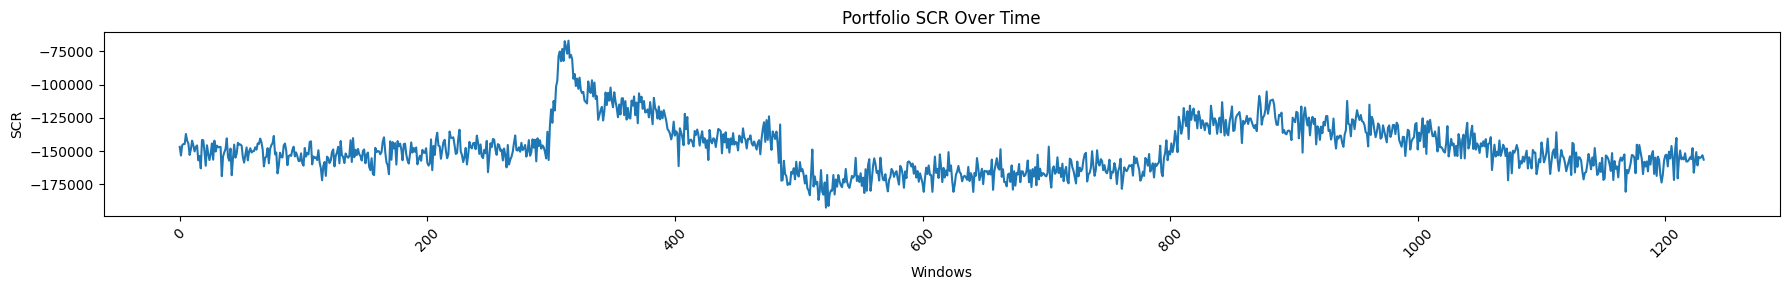

In [ ]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

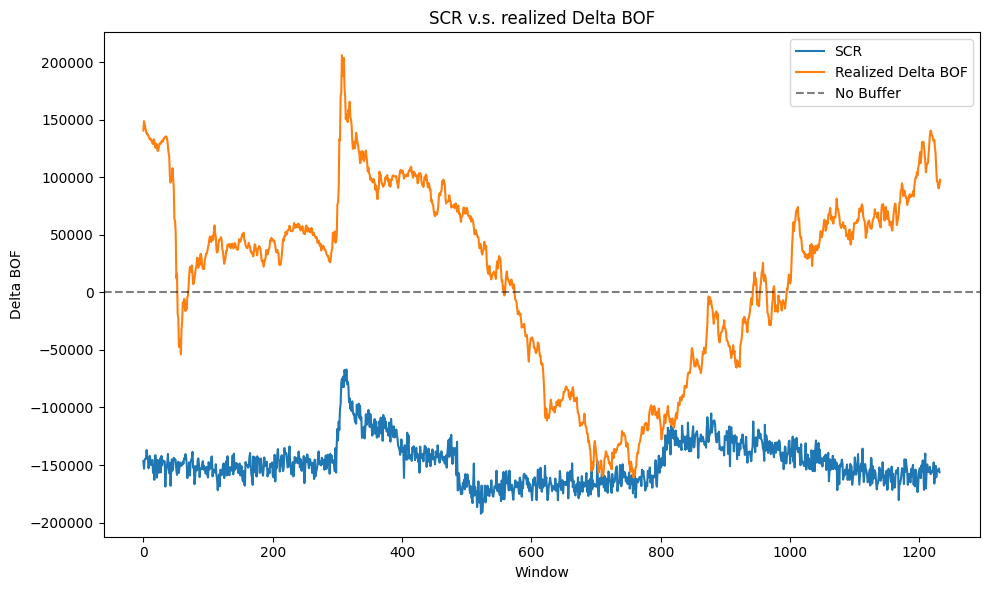

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

# Add a vertical dashed line - you can change the position as needed
plt.axhline(y=0, color='black', linestyle='--', label='No Buffer', alpha=0.5)

plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("SCR v.s. realized Delta BOF")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
b = realized_delta_bof_values_1[:-1]
breach = 0

for i in range(len(scr_values)):
  if scr_values[i] > b[i]:
    print(i)
    breach += 1
print(breach)

693
702
709
760
4


# Save Above

In [ ]:
ep = pd.DataFrame({
    'realized_delta_bof_values_1': realized_delta_bof_values_1[:-1],
    'scr_values': scr_values
})

# Save to CSV
ep.to_csv('/content/drive/MyDrive/MasterThesis/epistemic_7.csv', index=False)

ep.head()

,realized_delta_bof_values_1,scr_values
0,140624.031435,-146709.015246
1,148740.887546,-153221.869967
2,146156.794605,-145501.181784
3,143472.756474,-144643.218966
4,140659.074997,-144650.141669


In [ ]:
a = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_8.csv')
b = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_9.csv')
c = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_10.csv')
d = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_11.csv')
e = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_12.csv')
f = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_13.csv')
g = pd.read_csv('/content/drive/MyDrive/MasterThesis/epistemic_7.csv')

294941122.6928954
339466449.98474306
334113689.74074847
327429083.5440216
328119593.66653854
334993540.71313107
329060809.4010127


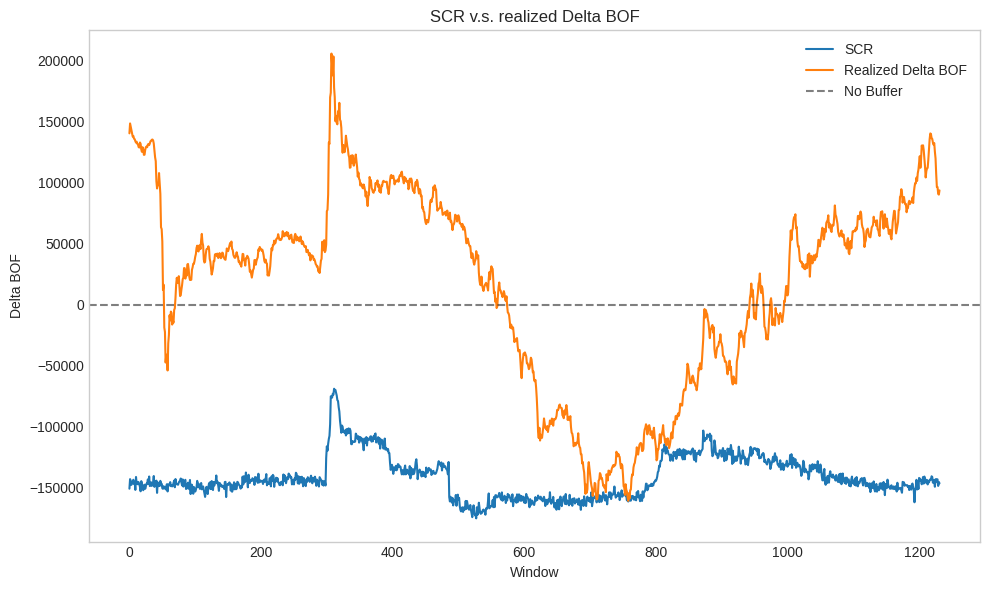

In [ ]:
# combining

# Combine with equal weights
comb = a.copy()
comb['scr_values'] = (a['scr_values'] + b['scr_values'] + c['scr_values']
                      + d['scr_values'] + e['scr_values'] + f['scr_values']
                   ) / 6

print(comb['scr_values'].var())
print(a['scr_values'].var())
print(b['scr_values'].var())
print(c['scr_values'].var())
print(d['scr_values'].var())
print(e['scr_values'].var())
print(f['scr_values'].var())
#print(g['scr_values'].var())

plt.figure(figsize=(10, 6))
plt.plot(comb['scr_values'], linestyle='-', label='SCR')
plt.plot(comb['realized_delta_bof_values_1'], linestyle='-', label='Realized Delta BOF')

# Add a vertical dashed line - you can change the position as needed
plt.axhline(y=0, color='black', linestyle='--', label='No Buffer', alpha=0.5)

plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("SCR v.s. realized Delta BOF")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

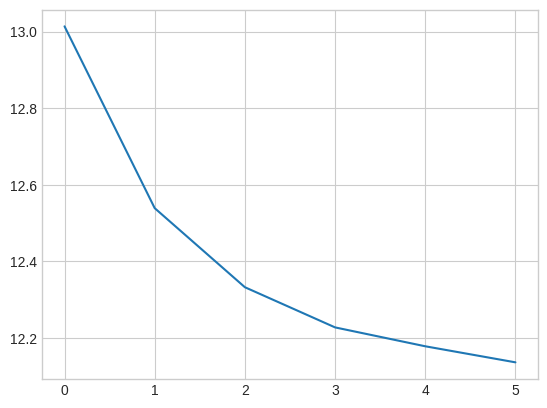

In [ ]:
all_variances = []

n = [a,b,c,d,e,f]

for q in range(len(n)):
  r = n[:q+1]

  s = a.copy()
  s['scr_values'] = 0

  for m in r:
    s['scr_values'] += m['scr_values']

  s['scr_values'] = s['scr_values'] / len(r)

  all_variances.append(abs(s['scr_values'].std() / s['scr_values'].mean() * 100))



plt.plot(all_variances)
plt.show()

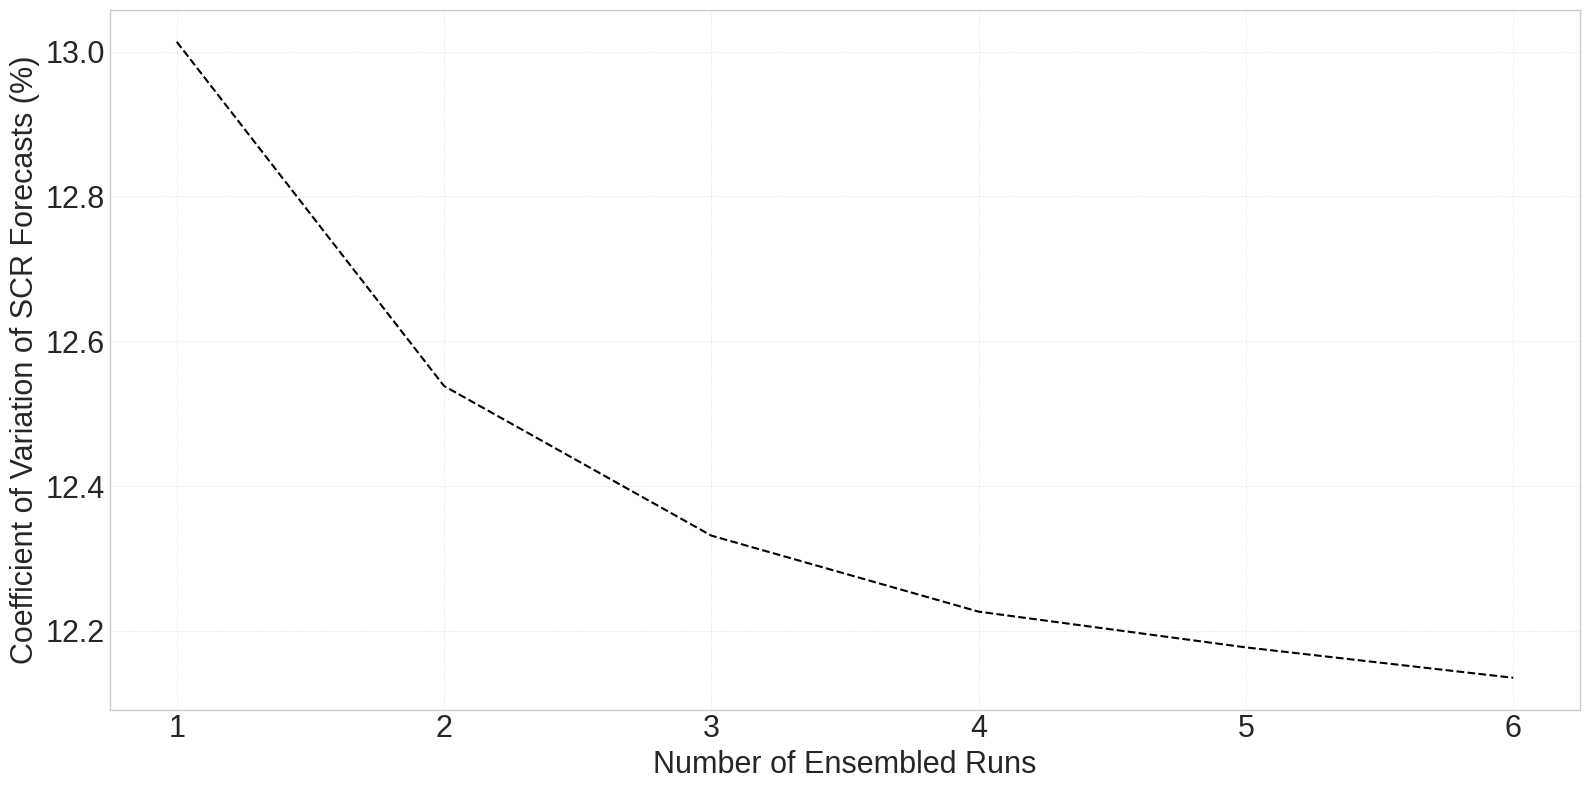

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

x_values = range(1, len(all_variances) + 1)
plt.plot(x_values, all_variances, label='Realized $\Delta$BOF',
          color='black', linestyle='--', linewidth=1.5)


plt.xlabel('Number of Ensembled Runs', fontsize=22)
plt.ylabel(
    'Coefficient of Variation of SCR Forecasts (%)', fontsize=22)


plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

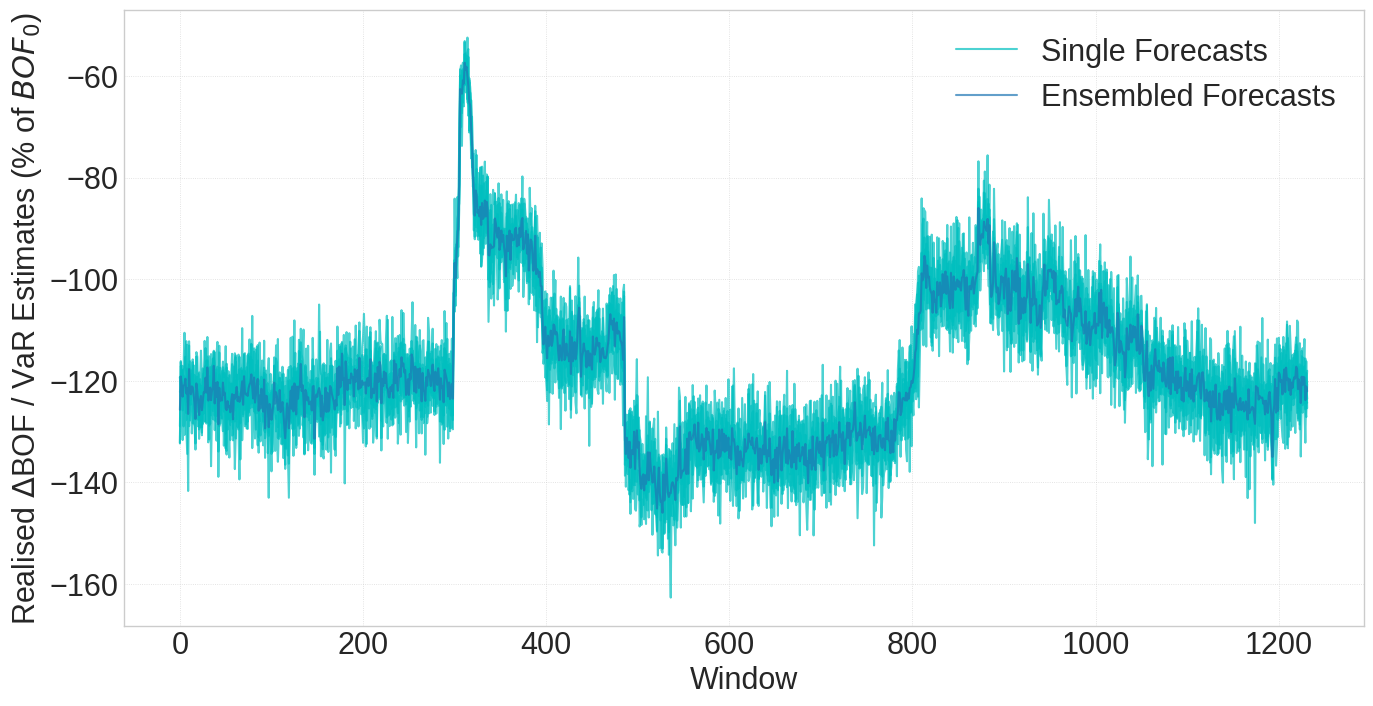

In [ ]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

plt.plot(a['scr_values'] /120000 *100, label='Single Forecasts', alpha=0.7, color='c')
plt.plot(b['scr_values'] /120000 *100, alpha=0.7, color='c')
plt.plot(c['scr_values'] /120000 *100, alpha=0.7, color='c')
plt.plot(d['scr_values'] /120000 *100, alpha=0.7, color='c')
plt.plot(e['scr_values'] /120000 *100, alpha=0.7, color='c')
plt.plot(f['scr_values'] /120000 *100, alpha=0.7, color='c')
#plt.plot(g['scr_values'], label='DF7', alpha=0.7, color='c')
plt.plot(comb['scr_values'] /120000 *100, label='Ensembled Forecasts', alpha=0.7)

plt.xlabel('Window', fontsize=22)
plt.ylabel(
    'Realised $\Delta$BOF / VaR Estimates (% of $BOF_0$)', fontsize=22)

legend = plt.legend(fontsize=22, frameon=False, fancybox=True,
                    shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.show()

In [ ]:

ep = pd.DataFrame({
    'realized_delta_bof_values_1': realized_delta_bof_values_1[:-1],
    'scr_values': scr_values
})

# Save to CSV
ep.to_csv('/content/drive/MyDrive/MasterThesis/combination_4.csv', index=False)

In [ ]:
# Checking theta

new_copula = ClaytonCopula(dim=returns_df.shape[1])

new_copula.fit(returns_df)

# 4. Access the estimated parameter
estimated_theta = new_copula.params
print(f"Estimated Theta: {estimated_theta}")

              REEL           PE    MSCIWORLD           IG          GOV  \
count  3187.000000  3187.000000  3187.000000  3187.000000  3187.000000   
mean      0.500000     0.500000     0.500000     0.500000     0.500000   
std       0.288630     0.288630     0.288630     0.288630     0.288630   
min       0.000314     0.000314     0.000314     0.000314     0.000314   
25%       0.250157     0.250157     0.250157     0.250157     0.250157   
50%       0.500000     0.500000     0.500000     0.500000     0.500000   
75%       0.749843     0.749843     0.749843     0.749843     0.749843   
max       0.999686     0.999686     0.999686     0.999686     0.999686   

                HY        EONIA  
count  3187.000000  3187.000000  
mean      0.500000     0.500000  
std       0.288630     0.288629  
min       0.000314     0.000314  
25%       0.250157     0.250157  
50%       0.500000     0.499843  
75%       0.749843     0.749843  
max       0.999686     0.999686  
Estimated Theta: 0.20810148

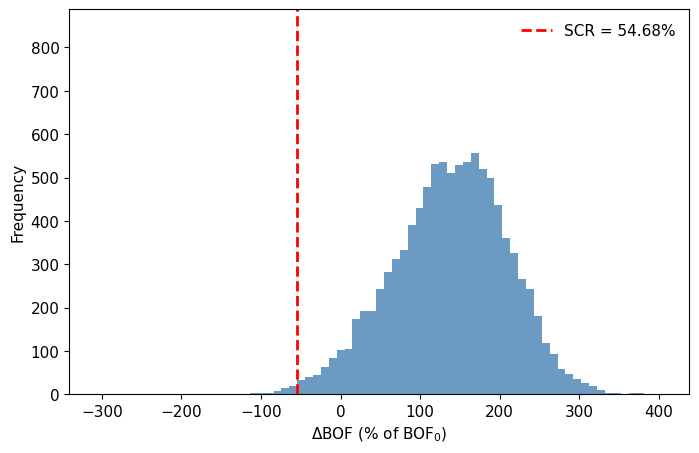

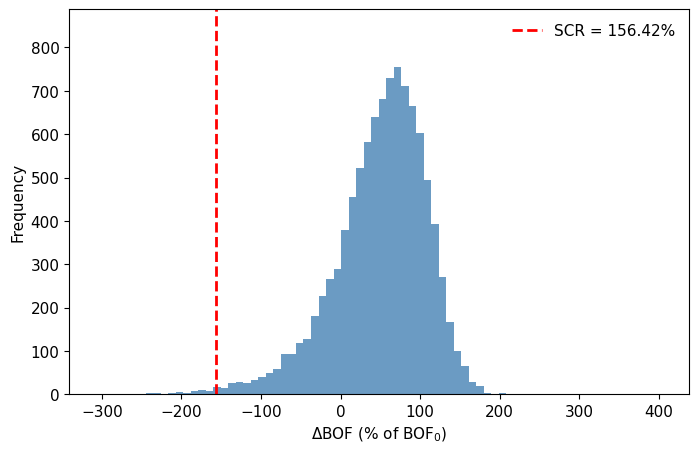

In [ ]:
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

x_min = 500
x_max = -100
y_max = 0

for timestamp, distribution in delta_bof_results.items():
   distribution = (distribution.cpu().numpy() / 120000) * 100
   if timestamp.year == 2020 and timestamp.month == 3:
       x_min = min(x_min, distribution.min())
       x_max = max(x_max, distribution.max())
       hist_counts, _ = np.histogram(distribution, bins=100)
       y_max = max(y_max, hist_counts.max())

max_dist = None
max_var = -10000
max_date = None
min_dist = None
min_var = 10000
min_date = None

for timestamp, distribution in delta_bof_results.items():
   distribution = (distribution.cpu().numpy() / 120000) * 100
   var_99_5 = np.percentile(distribution, 0.5)

   if var_99_5 > max_var:
       max_var = var_99_5
       max_dist = distribution
       max_date = timestamp

   if var_99_5 < min_var:
       min_var = var_99_5
       min_dist = distribution
       min_date = timestamp

bins = 50
plt.figure(figsize=(8, 5))
plt.hist(max_dist, bins=bins, alpha=0.8, color='steelblue')
plt.axvline(max_var, color='red', linestyle='--', linewidth=2, label=f'SCR = {-max_var:.2f}%')
plt.xlim(x_min * 1.3, x_max)
plt.ylim(0, y_max * 2)
plt.xlabel('$\Delta$BOF (% of BOF$_0$)')
plt.ylabel('Frequency')
plt.legend(frameon=False)
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(min_dist, bins=bins, alpha=0.8, color='steelblue')
plt.axvline(min_var, color='red', linestyle='--', linewidth=2, label=f'SCR = {-min_var:.2f}%')
plt.xlim(x_min * 1.3, x_max)
plt.ylim(0, y_max * 2)
plt.xlabel('$\Delta$BOF (% of BOF$_0$)')
plt.ylabel('Frequency')
plt.legend(frameon=False)
plt.grid(False)
plt.show()

In [ ]:
min_var, max_var


(np.float64(-156.41716411657072), np.float64(-54.67928257988616))

In [ ]:
# Finding window number
sorted_dates_delta_bof = dict(sorted(delta_bof_results.items()))

for i, j in enumerate(sorted_dates_delta_bof):
  if max_date == j:
    print(i)
  elif min_date == j:
    print(i)

313
507


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
from scipy.stats import gaussian_kde
import pickle

def compute_kdes(data_dict, x_range=None, n_points=100):
    if x_range is None:
        all_data = np.concatenate(list(data_dict.values()))
        x_range = (np.min(all_data), np.max(all_data))

    x_grid = np.linspace(x_range[0], x_range[1], n_points)
    kdes = {}

    for date in tqdm(data_dict.keys(), desc="Computing KDEs"):
        kde = gaussian_kde(data_dict[date])
        density = kde(x_grid)
        kdes[date] = {'x': x_grid, 'density': density}

    return kdes

def save_kdes(kdes, filename='kdes.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(kdes, f)

def load_kdes(filename='kdes.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

kdes = compute_kdes(delta_bof_results)
save_kdes(kdes)

Computing KDEs: 100%|██████████| 1232/1232 [00:43<00:00, 28.03it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd

def plot_ridgeline(kdes, every_n_months=200):
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)

    dates = sorted(kdes.keys())

    for i, date in enumerate(dates):
        x_dense = np.linspace(kdes[date]['x'].min(), kdes[date]['x'].max(), 500)
        z_dense = np.interp(x_dense, kdes[date]['x'], kdes[date]['density'])
        x = (x_dense / 120000) * 100
        y = np.full_like(x, i)
        z = z_dense

        norm_z = z / np.max(z)
        colors = cm.coolwarm(norm_z)

        ax.scatter(x, y, z, c=norm_z, cmap='coolwarm', s=50, alpha=1)

    date_indices = range(0, len(dates), every_n_months)
    date_labels = [str(i) for i in date_indices]

    ax.set_xlabel(r'$\Delta$BOF (% of $\text{BOF}_0$)', labelpad = 25, fontsize=16)
    ax.set_ylabel('Window', fontsize=16)
    ax.set_zlabel('Density', fontsize=16)

    ax.set_yticks(date_indices)
    ax.set_yticklabels(date_labels)

    ax.tick_params(axis='x', labelsize=14, pad=5)
    ax.tick_params(axis='y', labelsize=14, pad=5)
    ax.tick_params(axis='z', labelsize=14, pad=10)

    x_min = min([((kdes[date]['x'].min() / 120000) * 100) for date in dates])
    x_max = max([((kdes[date]['x'].max() / 120000) * 100) for date in dates])
    x_range = x_max - x_min

    ax.set_box_aspect([3, 1, 1])
    ax.view_init(elev=30, azim=270)

    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.savefig('plot.png', bbox_inches='tight', dpi=150, pad_inches=1.0)
    plt.show()

plot_ridgeline(kdes)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7d77cd1cfd80> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7d77cd1cd8a0> (for post_execute):


KeyboardInterrupt: 

## Saving above as CSV

In [ ]:
df = pd.DataFrame({'realized_delta_bof': realized_delta_bof_values_1[:-1], 'scr_values': scr_values})
df.to_csv("portfolio_scr_vs_realized.csv", index=False)
df.head()


from google.colab import files
files.download('portfolio_scr_vs_realized.csv')

import os
folder_path = '/content/drive/MyDrive/MasterThesis/MarginalResults'
os.makedirs(folder_path, exist_ok=True)

# Move all CSV files to Google Drive
csv_files = [f for f in os.listdir() if f.endswith('_scr_vs_realized.csv')]
for filename in csv_files:
   import shutil
   shutil.move(filename, f'{folder_path}/{filename}')

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## GAN SPESIFIC RESULTS

- Distributions
- Latent space plots
- PCAs

etc.

In [ ]:
# Plotting Distributions

# First windows

def create_rolling_empirical(returns_df, window_size=252):
    rolling_data = []
    for i in range(len(returns_df) - window_size):
        window = returns_df[i : i + window_size]
        rolling_data.append(window)
    return np.array(rolling_data)

precomputed_rolling_returns = {asset: create_rolling_empirical(returns_df[asset].values) for asset in returns_df.columns}


In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

for asset, windows in precomputed_rolling_returns.items():
    real_returns = windows.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(real_returns, bins=50, alpha=0.7, density=True, label="Real")

    gen_returns = gan_dict[asset].generate_scenarios(save=False, num_scenarios=4000)
    gen_returns = gen_returns.flatten()

    plt.hist(gen_returns, bins=50, alpha=0.7, density=True, label="Generated")

    if asset in ["IG", "HY", "GOV"]:
      plt.xlim(-0.1, 0.1)
    elif asset == "EONIA":
      plt.xlim(-0.0025, 0.0025)
    else:
      plt.xlim(-0.1, 0.1)

    ks_stat, p_value = ks_2samp(real_returns, gen_returns)
    wass_dist = wasserstein_distance(real_returns, gen_returns)

    print(f"{asset}: KS={ks_stat:.4f}, p={p_value:.4f}, Wass={wass_dist:.6f}")
    plt.grid(False)
    plt.legend(frameon=False)
    plt.show()

In [ ]:
from scipy import stats

descriptive_stats = []

for asset, windows in precomputed_rolling_returns.items():
   real_returns = windows.flatten()
   gen_returns = gan_dict[asset].generate_scenarios(save=False, num_scenarios=4000).flatten()

   real_stats = {
       'Asset': asset,
       'Type': 'Real',
       'Mean': real_returns.mean(),
       'Std': real_returns.std(),
       'Skew': stats.skew(real_returns),
       'Kurt': stats.kurtosis(real_returns),
       'VaR_99': np.percentile(real_returns, 0.5),
   }

   gen_stats = {
       'Asset': asset,
       'Type': 'Generated',
       'Mean': gen_returns.mean(),
       'Std': gen_returns.std(),
       'Skew': stats.skew(gen_returns),
       'Kurt': stats.kurtosis(gen_returns),
       'VaR_99': np.percentile(gen_returns, 0.5),
   }

   descriptive_stats.extend([real_stats, gen_stats])

df_stats = pd.DataFrame(descriptive_stats)
print(df_stats.round(6))

print("-"*100)

df_stats = pd.DataFrame(descriptive_stats)
latex_table = df_stats.to_latex(index=False, float_format='%.6f')
print(latex_table)

In [ ]:
var_stats = []

for asset, windows in precomputed_rolling_returns.items():
   real_returns = windows.flatten()
   gen_returns = gan_dict[asset].generate_scenarios(save=False, num_scenarios=4000).flatten()

   var_stats.append({
       'Asset': asset,
       'Real_VaR_99.5': np.percentile(real_returns, 0.5),
       'Generated_VaR_99.5': np.percentile(gen_returns, 0.5),
       'Difference': np.percentile(gen_returns, 0.5) - np.percentile(real_returns, 0.5)
   })

df_var = pd.DataFrame(var_stats)
print(df_var.round(6))

print("-"*50)

latex_table = df_var.to_latex(
   index=False,
   float_format='%.6f',
   column_format='|l|r|r|r|',
   caption='99.5\\% VaR Comparison: Real vs Generated Returns',
   label='tab:var_comparison'
)
print(latex_table)

## XAI

In [ ]:
from scipy.stats import wasserstein_distance

def simple_feature_importance(gan_instance, n_samples=1000):
    device = 'cuda' if gan_instance.cuda else 'cpu'
    baseline_condition = gan_instance.conditions.mean(axis=0)

    z = torch.randn(n_samples, gan_instance.latent_dim, device=device)
    baseline_cond = torch.tensor([baseline_condition] * n_samples, dtype=torch.float32, device=device)
    baseline_scenarios = gan_instance.generator(z, baseline_cond).cpu().detach().numpy().flatten()

    importances = []

    for i in range(len(baseline_condition)):
        masked_condition = baseline_condition.copy()
        masked_condition[i] = gan_instance.conditions[:, i].max()

        masked_cond = torch.tensor([masked_condition] * n_samples, dtype=torch.float32, device=device)
        perturbed_scenarios = gan_instance.generator(z, masked_cond).cpu().detach().numpy().flatten()

        distance = wasserstein_distance(baseline_scenarios, perturbed_scenarios)
        importances.append(distance)

    feature_names = []
    for lag in gan_instance.lag_periods:
        feature_names.extend([f'cum_ret_{lag}d', f'vol_{lag}d', f'kurt_{lag}d', f'dd_{lag}d'])

    return dict(zip(feature_names, importances))

In [ ]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np

def enhanced_feature_importance(gan_instance, n_samples=1000):
    device = 'cuda' if gan_instance.cuda else 'cpu'
    baseline_condition = gan_instance.conditions.mean(axis=0)

    z = torch.randn(n_samples, gan_instance.latent_dim, device=device)
    baseline_cond = torch.tensor([baseline_condition] * n_samples, dtype=torch.float32, device=device)
    baseline_scenarios = gan_instance.generator(z, baseline_cond).cpu().detach().numpy().flatten()

    max_importances = []
    min_importances = []

    for i in range(len(baseline_condition)):
        # Max perturbation
        max_condition = baseline_condition.copy()
        max_condition[i] = gan_instance.conditions[:, i].max()

        max_cond = torch.tensor([max_condition] * n_samples, dtype=torch.float32, device=device)
        max_scenarios = gan_instance.generator(z, max_cond).cpu().detach().numpy().flatten()
        max_distance = wasserstein_distance(baseline_scenarios, max_scenarios)
        max_importances.append(max_distance)

        # Min perturbation
        min_condition = baseline_condition.copy()
        min_condition[i] = gan_instance.conditions[:, i].min()

        min_cond = torch.tensor([min_condition] * n_samples, dtype=torch.float32, device=device)
        min_scenarios = gan_instance.generator(z, min_cond).cpu().detach().numpy().flatten()
        min_distance = wasserstein_distance(baseline_scenarios, min_scenarios)
        min_importances.append(min_distance)

    feature_names = []
    for lag in gan_instance.lag_periods:
        feature_names.extend([f'cum_ret_{lag}d', f'vol_{lag}d', f'kurt_{lag}d', f'dd_{lag}d'])

    return {
        'features': feature_names,
        'max_importance': max_importances,
        'min_importance': min_importances
    }

plt.rcParams['text.usetex'] = False

def plot_enhanced_feature_importance(filtered_gan_dict, top_n=14):
    symbol_map = {'cum_ret': r'$R_{\text{cum}}$', 'vol': r'$\sigma$',
                  'kurt': r'$K_{\text{tr}}$', 'dd': r'$\text{MDD}$'}

    for asset, gan_instance in filtered_gan_dict.items():
        importance_data = enhanced_feature_importance(gan_instance)

        # Combine data and sort by maximum of (max_importance, min_importance)
        combined_data = list(zip(importance_data['features'],
                               importance_data['max_importance'],
                               importance_data['min_importance']))

        # Sort by the maximum of max and min importance
        sorted_data = sorted(combined_data,
                           key=lambda x: max(x[1], x[2]),
                           reverse=True)[:top_n]

        features, max_scores, min_scores = zip(*sorted_data)

        # Convert feature names to mathematical notation
        labels = []
        for f in features:
            for old, new in symbol_map.items():
                if f.startswith(old):
                    lag = f.split("_")[-1].replace('d', '')
                    labels.append(f'{new}({lag})')
                    break

        # Create the plot
        fig, ax = plt.subplots(figsize=(16, 10))

        y_pos = np.arange(len(labels))
        bar_height = 0.35

        # Create horizontal bars
        bars_max = ax.barh(y_pos - bar_height/2, max_scores, bar_height,
                          label='Max Perturbation', color='black', alpha=0.8)
        bars_min = ax.barh(y_pos + bar_height/2, min_scores, bar_height,
                          label='Min Perturbation', color='gray', alpha=0.6)

        # Customize the plot
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=21)
        ax.set_xlabel('Wasserstein Distance', fontsize=16)
        ax.tick_params(axis='x', labelsize=20)
        ax.invert_yaxis()

        # Remove grids
        ax.grid(False)

        # Add legend
        ax.legend(loc='lower right', fontsize=21, frameon=False)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\n{asset} Summary:")
        print(f"Max perturbation range: {min(max_scores):.4f} - {max(max_scores):.4f}")
        print(f"Min perturbation range: {min(min_scores):.4f} - {max(min_scores):.4f}")
        print("-" * 50)


plot_enhanced_feature_importance(gan_dict)

## Plotting Discriminator Loss

In [ ]:
folder_path = '/content/drive/MyDrive/MasterThesis/d_losses/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

In [ ]:
label_dict = {
    "eq" : "EQ",
    "pe" : "PE",
    "re" : "RE",
    "ig" : "IG CB",
    "hy" : "HY CB",
    "gb" : "GB"
}

In [ ]:
plt.figure(figsize=(10, 5))

for file in csv_files:
  filename = file.split('/')[-1].replace('.csv', '')

  if filename not in ["ig","hy", "gb"]:
      df = pd.read_csv(os.path.join(folder_path, file))
      plt.plot(df.iloc[:, 0], label=label_dict[filename], alpha=0.7)

plt.legend(frameon=False)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Discriminator Loss', fontsize=14)
plt.ylim(0, 2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/2)}'))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

for file in csv_files:
  filename = file.split('/')[-1].replace('.csv', '')

  if filename in ["ig","hy", "gb"]:
      df = pd.read_csv(os.path.join(folder_path, file))
      plt.plot(df.iloc[:, 0], label=label_dict[filename], alpha=0.7)

plt.legend(frameon=False)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Discriminator Loss', fontsize=14)
plt.ylim(-20, 5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/2)}'))

plt.tight_layout()
plt.show()

## Making plots for the Shift Plots

In [ ]:
b1 = create_individual_asset_line("MSCIWORLD", deafult=False)[:252]
b2 = create_individual_asset_line("PE", deafult=False)[:252]
b3 = create_individual_asset_line("REEL", deafult=False)[:252]
b4 = create_individual_asset_line("IG", deafult=False)[:252]
b5 = create_individual_asset_line("HY", deafult=False)[:252]
b6 = create_individual_asset_line("GOV", deafult=False)[:252]
b7 = create_individual_asset_line("EONIA", deafult=False)[:252]

In [ ]:
data = {
   'EQ': b1,
   'PE': b2,
   'RE': b3,
   'IG CB': b4,
   'HY CB': b5,
   'GB': b6,
   'MONEY': b7
}

df = pd.DataFrame(data)

df.to_csv('/content/drive/MyDrive/MasterThesis/shifted_part_all_assets.csv.csv', index=False)

df.head()